# Analisando dados de pacientes de COVID-19 do hospital Sírio-Libanês

Notebook elaborado por [__Bruno Fontana da Silva__](https://github.com/fontanads).  (fontanads@gmail.com). <br>
**Versão**: 21 de Fevereiro de 2021  
**Tempo aproximado para executar o caderno completo (sem alterações) no Google Colab**: $\approx 6$ min.

Este trabalho foi desenvolvido para o projeto final do Bootcamp de Data Science Aplicada da Alura.

Neste projeto, estou utilizando o conjunto de dados [_COVID-19 - Clinical Data to assess diagnosis_](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), disponibilizado pelo Time de Inteligência de dados do Hospital Sírio-Libanês. São informações de pacientes cuja contaminação com o vírus COVID-19 foi confirmada. 

Esses pacientes foram admitidos no hospital e foram observados por um tempo superior a 12h. Em cinco intervalos de tempo (de durações variadas), foram coletados dados de exames de sangue e sinais vitais desses pacientes. Ao longo desse período, alguns pacientes foram internados na Unidade de Tratamento Intensivo (neste caderno vamos abreviar como ICU, do inglês _Intensive Care Unit_, para manter a nomenclatura do rótulo dos dados), enquanto outros não precisaram de internação. 

No contexto da pandemia de COVID-19, e especialmente na época de publicação desses dados, ainda não se sabe exatamente quais fatores diferenciam pacientes que precisarão de internação (devido ao comprometimento da sua capacidade respiratória) dos que não precisarão (pois manifestaram apenas sintomas leves e possíveis de tratar fora da ICU).

Portanto, mesmo após a confirmação de caso, os profissionais de saúde ainda não conseguem afirmar se o paciente vai desenvolver sintomas graves, que demandam internação.


**Objetivo Principal**: a fim de contribuir com soluções para o problema, este trabalho busca analisar os dados e encontrar características que possam distinguir pacientes que irão demandar internação na ICU dos que não irão desenvolver sintomas graves o suficiente para essa internação.

**Contexto da análise exploratória dos dados**: na análise exploratória e descritivas dos dados, o trabalho mostra como fatores como idade, gênero e comorbidades se relacionam com os casos de internação; também são analisadas algumas variáveis contínuas dos exames e sinais vitais, para ilustrar o quanto importante são algumas medidas em relação a outras nesse conjunto de dados.

**Principais Conclusões**: 
- as  <font color='blue'>**informações demográficas (idade, gênero e doenças prévias)**</font>  anotadas para cada paciente são bastante importantes, mostrando que há prevalência de internações depenendo do segmento dessas variáveis;
- há uma predominância no número de internações de <font color='blue'>**casos com idosos**</font>
- há uma predominância no número de internações de <font color='blue'>**casos do gênero $0$**</font>.

**Contexto dos modelos de aprendizagem de máquina**: considerando uma seleção prévia de características importantes, e realizando uma limpeza e pré-processamento dos dados, o trabalho compara o desempenho de alguns modelos de aprendizagem de máquina na tarefa de prever se os pacientes serão internados ou não. 

**Principais Conclusões**: 
- o modelo foi <font color='blue'>**treinado apenas as informações de exames da primeira janela de observação (``0-2``)**</font>
- apesar de alguns esforços para eliminação de variáveis, os modelos mostraram <font color='blue'>melhores resultados mantendo features de baixa dispersão e também as fortemente correlacionadas</font> (só foram eliminadas variáveis com dispersão nula nos dados da janela ``0-2``)
- dentre os modelos testados, <font color='blue'>**o melhor modelo, com maior poder de previsão de internações, foi o classificador ``RandomForest``**</font>
- aplicando o modelo treinado nos dados de validação, <font color=#DA4455>**os ``falsos positivos`` ocorrem com mais frequência usando medidas das janelas mais avançadas**</font>
- aplicando o modelo treinado nos dados de validação, <font color=#448533>**a métrica de ``recall``** (sensibilidade da classe 1, inversamente proporcional ao ``falsos negativos``) **apresentou resultados satisfatórios, entre $85\%$ e $89\%$**</font>.






<font color=#443399>**OBS.:** o caderno usa alguns formulários interativos do [Google Colab](https://colab.research.google.com/notebooks/forms.ipynb), em alguns trechos do caderno.  
Para ver os códigos desses formulários, clique duas vezes sobre a célula correspondente.</font>

<a name="toc2"></a>
# Sumário

Usando os hyperlinks abaixo, você pode navegar entre as principais seções.  
No Google Colab, você pode usar os _bookmarks_ da barra lateral esquerda (Índice) para navegar em um nível mais profundo das seções. 

- [Contexto do Dataset e Problema Principal](#problema)
- [Resumo da Análise e Principais Resultados (sem códigos)](#resumo)
- [Bibliotecas e Funções Auxiliares](#imports)
- [Carregando os Dados](#load_data)
- [Análise Exploratória](#eda)
 - [Visão Geral do Conjunto de Dados](#eda_ICU)
 - [Informações Qualitativas dos Pacientes](#eda_cat)
 - [Exames de Sangue e Sinais Vitais](#eda_cont)
- [Modelo de Previsão de Internação](#ML)
 - [Pré-processamento dos dados](#ML_preprocess)
 - [Variável de Estratificação](#ML_stratify)
 - [Treino e Previsão na Primeira Janela](#ML_train_split)
 - [Desempenho dos Modelos](#ML_results)
 - [Treinando pra valer: definindo o modelo para colocar em produção](#ML_MODELO_FINAL)
 - [Validação: pacientes não-internados nas janelas futuras](#ML_val)


<a name="problema"></a>
# Contexto do Dataset e Problema
[(voltar para o sumário)](#toc2)

O conjunto de dados reúne informações de um total de $\Large \mathbf{385}$ pacientes únicos.  

## **JANELAS DE OBSERVAÇÃO E DISTRIBUIÇÃO TEMPORAL DAS INTERNAÇÕES**  

Logo após a admissão de um paciente no hospital (caso confirmado), seus dados foram coletados repetidamente ao longo de 6 janelas de tempo:
- entre $0$ e $2$h após a admissão
- entre $2$ e $4$h após a admissão
- entre $4$ e $6$h após a admissão
- entre $6$ e $12$h após a admissão
- após mais de $12$h desde a admissão.

Em cada janela de cada paciente, temos a anotação indicando se ele estava internado na ICU ou não (rótulos $1$ e $0$, respectivamente). A Tabela abaixo mostra a distribuição do conjunto de dados em relação à pacientes que foram internados na ICU:
- $\Large 190$ dos $385$ pacientes **não** foram internados na ICU
- $\Large 195$ dos $385$ pacientes foram internados na ICU.

|   ICU |   #pacientes |
|------:|-------------:|
|     0 |          190 |
|     1 |          195 |

Como um dos objetivos da criação desse conjunto de dados é criar um modelo capaz de prever se um determinado paciente será ou não internado na ICU, é importante identificar a partir de qual janela esse paciente de fato foi internado.  

Isso porque simplesmente não faz sentido prever se o paciente vai ser internado utilizando dados coletados após a sua internação.  

As imagens abaixo ilustram dois casos de exemplo:
1. **O paciente é internado na ICU na última janela de dados** (coletas após $12$h da admissão do paciente): 
 - nesse caso, é permitido utilizar todos os dados coletados nas quatro janelas anteriores.
2. **O paciente é internado na ICU na segunda janela de dados** (coletas entre $2$ e $4$h da admissão do paciente):
 - nesse caso, só podemos usar os dados coletados na primeira janela (entre $0$ e $2$h da admissão do paciente).

<img src="https://github.com/fontanads/bootcamp_dsa_2021/raw/main/pics/Timeline%20Example%20Best.png" alt="Exemplo de paciente internado na última janela de observação." width="500px"/> 
<img src="https://github.com/fontanads/bootcamp_dsa_2021/raw/main/pics/Timeline%20Example%20No.png" alt="Exemplo de paciente internado na segunda janela de observação." width="500px"/> 
\*_Fonte original das imagens:  [_COVID-19 - Clinical Data to assess diagnosis_](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)_


Assim, é importante analisar como a internação dos 195 pacientes na ICU se distribui nas janelas de observação.  
A Tabela a seguir mostra essa relação:

| WINDOW   |   ICU = 0 |   ICU = 1 |
|:---------|----------:|----------:|
| 0-2      |       163 |        32 |
| 2-4      |       136 |        59 |
| 4-6      |        96 |        99 |
| 6-12     |        65 |       130 |
| ABOVE_12 |         0 |       195 |

Observando essa distribuição, percebe-se um fato importante:
- $\Large 32$ dos $195$ pacientes já são internados na ICU dentro do intervalo da primeira janela de observação ($0$ a $2$h) após a admissão hospital.

Infelizmente, esses dados não podem ser utilizados para treinamento dos modelos de previsão de internação na ICU. Portanto, **para fins de treino e teste dos modelos**, deve-se considerar 
- $190$ ($\approx 53{,}82\%$) pacientes não-internados e 
- $163$ ($\approx 46{,}17\%$) pacientes que foram internados em algum momento após a primeira janela de observação.  

Ou seja, nos treinamentos dos modelos, podemos aproveitar os dados de um total de $\Large 353$ pacientes ($\approx 91{,}69 \%$ do dataset disponibilizado).

## **_FEATURES_ DISPONÍVEIS**  

Para cada paciente, foram fornecidos os seguintes dados:
- $1$ número de **identificação** única
- $2$ rótulos pareados, indicando a janela de observação (string) e a condição (binária) de internação na ICU.
- $3$ variáveis categóricas de dados demográficos
 - uma variável binária indicando se o paciente tem 65 anos ou mais
 - uma variável binára indicando o gênero 
 - uma string indicando qual o percentil da idade do paciente
- $9$ variáveis binárias indicando se existe ou não comorbidade em 9 grupos distintos de doenças
- $36$ variáveis associadas a sinais vitais ($6$ tipos únicos de sinais)
- $180$ variáveis associadas a exames de sangue ($36$ exames únicos).

É importante destacar **as variáveis contínuas dos sinais vitais e exames de sangue foram pré-processadas** previamente, e seus valores encontram-se na faixa de $-1$ até $1$ (resultado do ``MinMaxScaler``). Além disso, muitos **sinais apresentam diferentes medidas estatísticas**. Por exemplo: a médida de glicose aparece 5 vezes através das _features_ ``'GLUCOSE_MEDIAN', 'GLUCOSE_MEAN', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'GLUCOSE_DIFF'`` (mediana, média, valor mínimo, valor máximo e valor diferencial, respectivamente).  

Também ressalta-se a qualidade do processo de "**anonimização**" dos dados adotado pela equipe do hospital. Mesmo as variáveis categóricas como gênero, percentil de idade e comorbidades não possuem uma correspondência aos seus significados reais. Por exemplo, não sabemos se ``GENDER`` 0 corresponde ao gênero masculino ou feminino. 



**PRINCIPAIS DESAFIOS**

Considerando o conjunto de dados fornecido e o objetivo do desenvolvimento do modelo de previsão, existem alguns desafios importantes a serem apontados.

- **Dados Ausentes (``nan``)**
   
   Existe uma quantidade considerável de dados ausentes (``nan``), sendo 
   - $\approx 57{,}35\%$ de linhas faltantes dos exames de sangue
   - entre $35.58\%$ e $38.85\%$ de linhas faltantes dos sinais vitais
   - $\approx 0.25\%$ de linhas faltantes de comorbidades (1 único paciente)

  Os motivos que levaram à falta desses dados podem ser diversos, desde a dificuldade da realização constante de todos os exames, como as demandas e rotinas que acontecem dentro do hospital, além do encaminhamento individualizado que pode ser dado a cada paciente.
   
  Devido à ausência desses dados, o time que forneceu o dataset sugeriu utilizar interpolação de repetição das medidas, considerando que muitos sinais vitais e exames de sangue se mantém constantes (em média) ao longo das janelas de observação. 
   
  Entretanto, é necessário tomar o cuidado de **não vazar para os dados de treino as medições das janelas em os pacientes foram internados**, pois esse vazamento (_data leakage_) trás uma informação futura para os dados de treino do modelo de previsão.

- **Dimensões e Urgência da Previsão** 

   Desprezando as variáveis categóricas (constantes em todas as janelas), existem $220$ variáveis contínuas que são coletadas uma vez em cada janela, ou seja, poderíamos ter até $1100$ features contínuas na entrada do modelo.  
 
   Como não há  um rótulo futuro para a última janela, esse número cai para $880$. Entretanto, não podemos usar dados de coleta a partir da janela em que o paciente é internado. Isso significa que podemos ter $880$ medidas para um paciente que só é internado na última janela ou apenas $220$ medidas para um paciente internado na segunda janela. 

   Nesse sentido, fica difícil planejar um modelo que possa usar os dados de todas as janelas, pois não é comum que os modelos aceitem um número variável de features em sua entrada.  

  Aliando esse problema com a **urgência da previsão**, ou seja, a importância de identificar o mais cedo possível que um paciente precisará de um leito de ICU, uma **estratégia conveniente** é **considerar apenas os dados da primeira janela** para o treinamento do modelo. Isso não impede que o modelo seja reutilizado com dados de janelas futuras, apenas restringe que ele utilize as medições mais atuais em vez de um histórico de cada _feature_ que poderia varia de tamanho entre os pacientes. Dessa forma, a realização de todas as medições na primeira janela se torna essencial para aplicar o modelo em um cenário real.

<a name="resumo"></a>
# Resumo da Análise e Principais Resultados (sem códigos)
[(voltar para o sumário)](#toc2)

> <font color=#DB4455> **Análise Exploratória**: </font>  
>
> - **DADOS VÁLIDOS:** $32$ dos $195$ pacientes internados **não** poderão ser usados no treino dos modelos, pois correspondem a pacientes internados desde a primeir janela de observação.
> - **JANELAS DE INTERNAÇÃO**: entre $15\%$ e $20\%$ dos pacientes são internados em cada uma das primeiras janelas de observação. Na última janela, são internados aprox. $33\%$ dos pacientes. Embora não haja discrepância significativa, isso indica que os pacientes podem ter sua admissão com casos mais ou menos graves. Ou seja, na primeira janela de observação (maior interesse para o treino do modelo), não temos garantia de que todos os sintomas já se manifestam nos resultados dos exames.
> - **IDADE DOS PACIENTES**: apenas  $32{,}10\%$  ($\approx 1/3$) dos casos que não foram internados (``ICU=0``) correspondem a pacientes com idade acima de $65$ anos, enquanto  $61{,}02\%$  ($\approx 3/5$) dos casos de internação na ICU (``ICU=1``) correspondem a pacientes com idade acima de $65$ anos. Além disso, $66,11\%$  ($\approx 2/3$) dos casos de pacientes idosos resultam em internação na ICU.  
<img src="https://github.com/fontanads/bootcamp_dsa_2021/raw/main/pics/ICU_vs_IDADE_percentil.png" alt="Interações versus idade dos pacientes." width="600px"/>  
> - **GÊNERO DOS PACIENTES**: $63.12\%$  dos pacientes são do gênero $0$, enquanto $36.88\%$ dos pacientes são do gênero $1$. Dos casos de internação (``ICU=1``), quase  $70\%$ correspondem a pacientes do gênero $0$. Pesquisando algumas fontes externas sobre o tema, suspeita-se que o gênero $0$ corresponda ao sexo masculino.
> - **COMORBIDADES**: as doenças ``DISEASE GROUPING 4`` tem uma razão de  $6$  para  $1$  entre pacientes internados vs. não internados (apesar de só haver  $7$  pacientes nesse grupo); as doenças ``DISEASE GROUPING 2`` tem uma razão de  $3{,}5$  para  $1$  entre pacientes internados vs. não internados (apesar de só haver  $9$  pacientes nesse grupo); e existem  $4$ grupos de doenças (``DISEASE GROUPING 1``, ``DISEASE GROUPING 5``, ``HTN`` e ``IMMUNOCOMPROMISED``) que têm baixa incidência nos percentis de idades mais baixos, mas passam a aumentar proporcionalmente com o aumento da idade.
> - **SINAIS VITAIS E EXAMES DE SANGUE:** existem $36$  exames de sangue únicos, cada um com  $5$  estatísticas diferentes (total:  $180$  colunas); e existem $6$ medidas únicas de sinais vitais, cada um com  $6$  estatísticas diferentes (total:  $36$  colunas). Algumas dessas variáveis contínuas têm dispersão nula na primeira janela (não terão influência no treino de um modelo). Muitas variáveis estão fortemente correlacionadas. Em uma análise preliminar de ``boxplot``, suspeita-se que ``LACTATE`` seja o exame mais determinante na diferenciação das internações, enquanto ``RESPIRATORY_RATE_`` parece ser o sinal vital mais determinante para a diferenciação. Além disso, algumas variáveis têm dispersão muito baixa, praticamente compostas por outliers (exemplos: ``CREATININ_MAX``, ``DIMER_MEDIAN``, ``FFA_MEAN``, ``POTASSIUM_``).  [Baixe aqui um boxplot gigante das variáveis contínuas selecionadas para o modelo final.](https://raw.githubusercontent.com/fontanads/bootcamp_dsa_2021/main/pics/boxplot_vars_selecionadas.png)
>
> <font color=#DB4455> **Modelo de Previsão de Internação**: </font>  
> - O **preenchimento de dados ausentes** é realizado com ``ffill`` seguido de um ``fillna`` baseado em valores aleatórios calculados sobre a distribuição das medidas dos pacientes que nunca são internados. O objetivo é não "vazar" nenhuma informação dos exames pacientes internados para as medidas ausentes do mesmo paciente nas janelas em que ele não está internado.
> - Na **validação cruzada**, os _splits_ treino/teste são **estratificados de acordo com a janela de internação dos pacientes**. Analisam-se as métricas ``roc_auc``, ``f1``, ``precision`` e ``recall`` (as duas últimas correspondentes à classe 1).
> - Apesar da seleção automática de _features_, **os melhores resultados ocorrem considerando todas as variáveis fortemente relacionadas e incluindo as variáveis de baixa dispersão** (são eliminadas apenas variáveis de dispersão nula na janela ``0-2``).
> - Além do valor médio das métricas de desempenho correspondentes aos _splits_ de teste, os principais critérios para decisão do melhor modelo envolveram **escolher um modelo cujo intervalo de dispersão das métricas apresentasse os maiores valor mínimos**, com foco nas métricas ``f1`` e ``recall``.  

| Modelo                 | f1           | roc_auc      | recall       | precision    |
|:-----------------------|:-------------|:-------------|:-------------|:-------------|
| DecisionTreeClassifier | (0.52, 0.7)  | (0.59, 0.79) | (0.5, 0.88)  | (0.44, 0.65) |
| LogisticRegression     | (0.57, 0.67) | (0.74, 0.81) | (0.6, 0.81)  | (0.5, 0.62)  |
| RandomForestClassifier | (0.67, 0.78) | (0.84, 0.9)  | (0.7, 0.91)  | (0.58, 0.73) |
| SVC                    | (0.54, 0.63) | (0.74, 0.78) | (0.53, 0.73) | (0.51, 0.6)  |

> - <font color=#448933>**O modelo com os melhores resultados na validação cruzada foi o ``RandomForestClassifier``**.</font>

<img src="https://github.com/fontanads/bootcamp_dsa_2021/raw/main/pics/modelos_f1_val.png" alt="Desempenho da métrica f1 no split de validação (comparação entre modelos)." width="1080px"/>  

> - Após essa escolha do melhor modelo, os hiperparâmetros do ``RandomForestClassifier`` são otimizados com uma **busca em grade (dos hiperparâmetros) com validação cruzada**.
> - A **análise de importância de features do ``RandomForestClassifier``** confirmou a análise exploratória quanto à idade dos pacientes. Entretanto, muitos exames de sangue que não foram destacados na análise exploratória dos dados mostram-se bastante relevantes na ordem de importância (``SAT_02``, ``LINFOCITOS``, ``INR``, etc.). Já as variáveis ``LACTATE_``, que pareciam determinantes de acordo com as conclusões preliminares da análise exploratória, não parecem tão relevantes assim no modelo final.

<img src="https://github.com/fontanads/bootcamp_dsa_2021/raw/main/pics/feature_importance.png" alt="Importância das features do modelo final (Random Forest)." width="1080px"/> 

> - Ao fim do trabalho, **elaborei uma metodologia para fazer uma validação dos resultados do modelo "acompanhando" a evolução dos pacientes**. Nessa parte, os **dados de validação** são as medições dos pacientes nas janelas que não foram usadas para o treino. Observou-se que  <font color=#448933>**o ``recall`` é satisfatório ao longo de todas as janelas**</font>, enquanto  <font color=#EA4433>**a ``precisão`` mostra um pouco de overfit na primeira janela e um aumento dos ``falsos positivos`` com o passar do tempo**</font>.

>> - Erros Parciais (pacientes não serão internados na janela futura):  

|  janela   |   0-2 |   2-4 |   4-6 |
|:----------|------:|------:|------:|
| f1        |  0.87 |  0.76 |  0.65 |
| recall    |  0.85 |  0.88 |  0.86 |
| precision |  0.91 |  0.68 |  0.53 |


>> - Erros Definitivos (pacientes serão internados na janela futura):  

| janela |   0-2 |   2-4 |   4-6 |   6-12 |
|:-------|------:|------:|------:|-------:|
| recall |  0.89 |  0.85 |  0.87 |   0.89 |

<a name="imports"></a>
# Bibliotecas e Funções Auxiliares
[(voltar para o sumário)](#toc2)

In [ ]:
# MANIPULAÇÃO DE ESTRUTURAS DE DADOS
import pandas as pd
import numpy as np 

from IPython.display import display
from itertools import product
from collections import OrderedDict

# PARA DIVISÃO TREINO/TESTE E VALIDAÇÃO CRUZADA
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit, GridSearchCV

# PRÉ-PROCESSAMENTO (uso auxiliar)
from sklearn.preprocessing import MaxAbsScaler

# MODELOS DE CLASSIFICAÇÃO BINÁRIA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# AVALIAÇÃO DE DESEMPENHO
from sklearn.metrics import get_scorer, make_scorer
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import roc_curve, auc

# VISUALIZAÇÕES GRÁFICAS
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, to_hex
from matplotlib.ticker import MultipleLocator

import seaborn as sns

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [ ]:
SEED = 45678
np.random.seed(SEED)

In [ ]:
#------------------------------------------------------------------------------------------------
# MÉTODO PARA CONFIGURAR AS FONTES DE UM GRÁFICO DO MATPLOTLIB COM BASE NOS VALORES PADRONIZADOS 
#------------------------------------------------------------------------------------------------
# Valores padronizados para tamanho de fontes em gráficos
SMALL_SIZE = 16
MEDIUM_SIZE = 24
BIGGER_SIZE = 30
def set_fontsizes_in_plot():
    plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc("legend", title_fontsize=SMALL_SIZE)
set_fontsizes_in_plot()

In [ ]:
# MÉTODO AUXILIAR PARA VISUALIZAÇÃO GRÁFICA DE COUNTPLOTS COM VARIÁVEIS CATEGÓRICAS
def countplot_x_categorico_hue_categorico(data, x, hue, xlabel=None, ylabel=None, title=None, xlabel_rotation=0, bbox_to_anchor=(1.2, 1), figsize=(14,6)):
  '''Figura de countplot do seaborn usando variáveis categóricas no eixo x e no hue.
  '''
  fig, ax = plt.subplots(1,1, figsize=(14,6))
  sns.countplot(data=data, x=x, hue=hue, order = sorted(data[x].unique()))
  ax.grid(which='major', axis='y',linestyle=':')
  if xlabel:
    ax.set_xlabel(xlabel)
  if ylabel:
    ax.set_ylabel(ylabel)
  if title:
     ax.set_title(title);
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
  ax.legend(bbox_to_anchor=bbox_to_anchor,title=hue) 

In [ ]:
# MÉTODOS AUXILIARES PARA VISUALIZAÇÃO GRÁFICA DE BOXPLOTS DE VARIÁVEIS CONTÍNUAS COMPARANDO RÓTULO BINÁRIO
def get_x1_x2(df_ICU_0_window, df_ICU_1_window, var, yvar='ICU_timeless'):
  '''Retorna dois dataframes: um com medidas da variável "var" e rótulo 0, e outro com as medidas da mesma variável e rótulo 1.
  '''
  x1 = df_ICU_0_window[var].dropna().droplevel(0).reset_index()
  x2 = df_ICU_1_window[var].dropna().droplevel(0).reset_index()
  return x1, x2

def matriz_boxplots(df_pivot, janela, lista_de_variaveis,yvar='ICU_timeless'):
  '''Gera uma matriz de boxplots comparando as medidas das variáveis selecionadas entre pacientes que foram internados e os que não foram.
  Entradas: pode ser passada uma única janela combinada com uma lista de variáveis contínuas.
  Poderia ter usado FacetGrid do seaborn. ;_;""
  '''
  N = len(lista_de_variaveis)
  ncols = min(4,np.floor(N/2).astype(int))
  nrows = max(1,np.ceil(N/ncols).astype(int))

  ax_id_list = list(product(range(nrows),range(ncols)))
  fig, ax = plt.subplots(nrows, ncols, figsize=(40,4*nrows), sharey=True)
  plt.subplots_adjust(hspace=.35)

  df_ICU_0_window = df_pivot.loc[(slice(None),0),(slice(None),[janela])].droplevel(1,axis=1)
  df_ICU_1_window = df_pivot.loc[(slice(None),1),(slice(None),[janela])].droplevel(1,axis=1)

  for var, ax_id in zip(lista_de_variaveis,ax_id_list):
    x1, x2   = get_x1_x2(df_ICU_0_window, df_ICU_1_window, var,yvar=yvar)
    df_x1_x2 = pd.concat([x1,x2])
    sns.boxplot(data=df_x1_x2, x=var, y=yvar, orient='h', ax=ax[ax_id])
    ax[ax_id].set_xlim([-1,1])
    if ax_id[1]!=0:
      ax[ax_id].set_ylabel(None)

def comparacao_de_boxplots(df_pivot, features, janela='0-2',nrows=4,hspace=2):
  '''Gera nrows subplots comparando o boxplot de várias features na janela desejada.
  '''
  df_boxplot = df_pivot.rename_axis(index={'ICU_timeless':'ICU'}).loc[:,(sorted(features),janela)].droplevel(1,axis=1).reset_index().set_index(patient_id_col)
  Ncols = df_boxplot.shape[1]
  more_cols = nrows - ((Ncols-1) % nrows)
  cols_idx = np.hstack([np.arange(1,Ncols),np.array([None]*more_cols)]).reshape(nrows,-1)
  fig, axs = plt.subplots(nrows, 1, figsize=(21, nrows*11))
  fig.subplots_adjust(hspace=hspace)

  if nrows==1:
    type(axs) == np.ndarray
    axs = np.array(axs).reshape(1)
    
  for i, ax in enumerate(axs):
    sns.boxplot(data=pd.melt(df_boxplot.iloc[:,[0]+cols_idx[i][cols_idx[i]!=None].tolist()],'ICU').dropna(), x='variable',y='value',hue='ICU', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical');
    ax.set_ylabel('Valor')
    ax.set_xlabel('')

In [ ]:
def group_same_continous_vars(vars_list):
  '''Cria um dicionário onde a chave é o tipo de variável contínua (e.g. HEART_RATE) e o valor é uma lista das estatísticas dessa variável (e.g. [MIN, MAX, MEDIAN]).
  '''
  l1 = [var.split('_') for var in sorted(vars_list)]
  l2 = [(' '.join(var[:-1]), var[-1]) if var[-1]!="REL" else (' '.join(var[:-2]), ' '.join(var[-2:])) for var in l1]
  vars, _ = list(zip(*l2)) 
  vars_dict = {var:[item[1] for item in l2 if item[0]==var] for var in set(vars)}
  vars_dict = OrderedDict(sorted(vars_dict.items()))
  return vars_dict

In [ ]:
# FUNÇÕES AUXILIARES PARA GERAR GRÁFICOS DO DESEMPENHO DOS MODELOS COM O PLOTLY

def gera_lista_de_cores(N, cmap='tab10', continua=False):
  ''' Retorna uma lista de N cores (hexadecimal) seguindo um cmap do matplotlib.
  '''
  color_map = cm.get_cmap(cmap)
  colors = color_map(range(N))
  colors = np.apply_along_axis(to_hex, 1, colors)
  if continua:
    idxs = np.linspace(0,len(colors)-1,N).astype(int).tolist() # não faz muito sentido ainda, mas é para generalizar no futuro
  else:
    idxs = range(N)
  colors = colors[idxs].tolist()
  return colors

def cria_dist_plot(data, labels, show_rug=False, show_hist=False, show_curve=True):
  '''Retorna uma figura (plotly) de distribuições apróximadas (kde) a partir de lista com diferentes séries de dados.
  '''
  colors = gera_lista_de_cores(len(labels))
  fig = ff.create_distplot(data, group_labels=labels, colors=colors,
                           histnorm='probability density', bin_size=.025, 
                           show_rug=show_rug, show_hist=show_hist, show_curve=show_curve)
  return fig

def compara_modelos(modelos_para_comparar, metrica='f1', split='train', show_rug=False, show_hist=False, show_curve=True):
  '''Retorna as distribuições aproximadas da metrica especificada e do split selecionado comparando todos os modelos da lista de entrada.
  '''
  hist_data = []
  for i, model in enumerate(modelos_para_comparar):
    trace      = results[(model, split, metrica)]
    hist_data.append(trace)
  fig = cria_dist_plot(hist_data, modelos_para_comparar, show_rug=show_rug, show_hist=show_hist, show_curve=show_curve) 
  fig.update_layout(title_text=f'Comparação de Modelos: split {split.upper()} e metrica {metrica.upper()}', xaxis_range=[0,1])
  return fig 

def compara_treino_teste(modelo, metrica='f1', splits=["train", "test", "val"], show_rug=False, show_hist=False, show_curve=True):
  '''Retorna as distribuições aproximadas da metrica e do modelo especificados comparando os splits de treino/teste/validação.
  '''
  hist_data = []
  for i, split in enumerate(splits):
    trace      = results[(modelo, split, metrica)]
    hist_data.append(trace)
  fig = cria_dist_plot(hist_data, splits, show_rug=show_rug, show_hist=show_hist, show_curve=show_curve) 
  fig.update_layout(title_text=f'Comparação de Treino/Teste: modelo {modelo.upper()} e metrica {metrica.upper()}', xaxis_range=[0,1])
  return fig 

def todas_as_figuras(dicionario_figs):
  '''Imprime todas as figuras salvas nos valores do dicionario.
  '''
  for fig in dicionario_figs.values():
    fig.show()

def figuras_param_fixo(dicionario_figs, param_fix, position_fix=0):
  '''Imprime as figuras salvas nos valores do dicionario quando a chave da posicao especificad for igual ao parâmetro de entrada.
  '''
  plot_list = [fig for params, fig in dicionario_figs.items() if params[position_fix]==param_fix]
  for fig in plot_list:
    fig.show()

In [ ]:
# FUNÇÕES AUXILIARES PARA GERAR ANALISAR OS RESULTADOS NUMÉRICOS DA VALIDAÇÃO CRUZADA

def precision_decorator(display_func):
  '''Decorador para mudar temporariamente a precisão de impressão dos floats em DataFrames do pandas.
  Usar com funções que aplicam IPython.display(df).
  '''
  def wrapper(*args, **kwargs):
    pd.set_option('precision', 3)
    display_func(*args, **kwargs)
    pd.reset_option('precision')
  return wrapper

@precision_decorator
def print_df_of_results(df_stat, metricas, split, stat, q=.8, reverse_style=1, markdown=False):
  '''Imprime os resultados obtidos pelo método organize_df_of_results.
  Usa display do IPython para mostrar um DataFrame do pandas personalizado com .style.
  reverse_style: {1: destaca os maiores valores como azul e os menores como vermelho, 
                 -1: faz o contrário}
  '''
  print(f'\nResultados de {stat} de metricas para cada modelo no split {split}: ')
  df_concat = pd.DataFrame([])
  for i, metrica in enumerate(metricas):
    df_display = df_stat.loc[metrica].rename(columns={stat:metrica})
    df_temp = df_display.sort_index()
    df_concat = pd.concat([df_concat, df_temp],axis=1) if i>0 else df_temp
  
  if stat != 'intervalo':
    lambda_threshold_good_bad = lambda x: threshold_good_bad(reverse_style*x, q=q)
    df_concat = df_concat.rename_axis(columns=stat).style.apply(lambda_threshold_good_bad)
  
  display(df_concat)
  print('-'*100)

  if markdown:
    print(df_concat.to_markdown())
  return None

def organize_df_of_results(results_df, metricas, split='test', stat='media'):
  '''Acessa os resultados agregados de validação cruzada, filtrando pelo split desejado.
  Retorna um dataframe organizado com as métricas solicitadas no índice e com os modelos ordenados pelos melhores resultados de cada métrica.
  '''
  df_groupby = results_df.query(f'Split=="{split}"').groupby(['Metrica','Modelo'])
  df_stat = df_groupby[stat].max().loc[metricas]
  df_stat = df_stat.sort_values(ascending=False).sort_index(level=0, sort_remaining=False)
  return pd.DataFrame(df_stat)

def threshold_good_bad(x, q=0.8, color_less_than_th = '#FF0000', color_greater_than_th='#0000FF'):
    """Retorna uma string com uma propriedade css (código de cor): vermelho quando abaixo do limiar, senão azul.
    Usar com df.style.apply()
    """
    s = x.copy()
    q = s.quantile(q)
    filtro1 = s<q
    filtro2 = s>=q
    s[filtro1] = f'color: {color_less_than_th}'
    s[filtro2] = f'color: {color_greater_than_th}'
    return s

<a name="load_data"></a>
# Carregando os Dados
[(voltar para o sumário)](#toc2)


######    

In [ ]:
url = 'https://github.com/fontanads/bootcamp_dsa_2021/blob/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'
df0 = pd.read_excel(url)
df0.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

<a name="eda"></a>
# Análise Exploratória
[(voltar para o sumário)](#toc2)


**Resumo da Seção:**

> <font color=#DB4455> **SPOILER ALERT**: </font>  
>
> - **DADOS VÁLIDOS:** $32$ dos $195$ pacientes internados **não** poderão ser usados no treino dos modelos, pois correspondem a pacientes internados desde a primeir janela de observação.
> - **JANELAS DE INTERNAÇÃO**: entre $15\%$ e $20\%$ dos pacientes são internados em cada uma das primeiras janelas de observação. Na última janela, são internados aprox. $33\%$ dos pacientes. Embora não haja discrepância significativa, isso indica que os pacientes podem ter sua admissão com casos mais ou menos graves. Ou seja, na primeira janela de observação (maior interesse para o treino do modelo), não temos garantia de que todos os sintomas já se manifestam nos resultados dos exames.
> - **IDADE DOS PACIENTES**: apenas  $32{,}10\%$  ($\approx 1/3$) dos casos que não foram internados (``ICU=0``) correspondem a pacientes com idade acima de $65$ anos, enquanto  $61{,}02\%$  ($\approx 3/5$) dos casos de internação na ICU (``ICU=1``) correspondem a pacientes com idade acima de $65$ anos. Além disso, $66,11\%$  ($\approx 2/3$) dos casos de pacientes idosos resultam em internação na ICU.
> - **GÊNERO DOS PACIENTES**: $63.12\%$  dos pacientes são do gênero $0$, enquanto $36.88\%$ dos pacientes são do gênero $1$. Dos casos de internação (``ICU=1``), quase  $70\%$ correspondem a pacientes do gênero $0$. Pesquisando algumas fontes externas sobre o tema, suspeita-se que o gênero $0$ corresponda ao sexo masculino.
> - **COMORBIDADES**: as doenças ``DISEASE GROUPING 4`` tem uma razão de  $6$  para  $1$  entre pacientes internados vs. não internados (apesar de só haver  $7$  pacientes nesse grupo); as doenças ``DISEASE GROUPING 2`` tem uma razão de  $3{,}5$  para  $1$  entre pacientes internados vs. não internados (apesar de só haver  $9$  pacientes nesse grupo); e existem  $4$ grupos de doenças (``DISEASE GROUPING 1``, ``DISEASE GROUPING 5``, ``HTN`` e ``IMMUNOCOMPROMISED``) que têm baixa incidência nos percentis de idades mais baixos, mas passam a aumentar proporcionalmente com o aumento da idade.
> - **SINAIS VITAIS E EXAMES DE SANGUE:** existem $36$  exames de sangue únicos, cada um com  $5$  estatísticas diferentes (total:  $180$  colunas); e existem $6$ medidas únicas de sinais vitais, cada um com  $6$  estatísticas diferentes (total:  $36$  colunas). Algumas dessas variáveis contínuas têm dispersão nula na primeira janela (não terão influência no treino de um modelo). Muitas variáveis estão fortemente correlacionadas. Em uma análise preliminar de ``boxplot``, suspeita-se que ``LACTATE`` seja o exame mais determinante na diferenciação das internações, enquanto ``RESPIRATORY_RATE_`` parece ser o sinal vital mais determinante para a diferenciação. Além disso, algumas variáveis têm dispersão muito baixa, praticamente compostas por outliers (exemplos: ``CREATININ_MAX``, ``DIMER_MEDIAN``, ``FFA_MEAN``, ``POTASSIUM_``).

**Início**

Para facilitar algumas manipulações, são criadas algumas listas com os nomes das colunas do _dataset_.  

A intenção principal é principalmenter ter uma lista das variáveis contínuas e outra das categóricas.  
Das contínuas, temos ainda uma lista para exames de sangue e outra para sinais vitais.  
As categóricas também se dividem em duas: dados demográficos e comorbidades.

In [ ]:
# Separando as colunas por agrupamentos (realizado logo após a primeira exploração)
# ID
patient_id_col              = 'PATIENT_VISIT_IDENTIFIER'                 # 0

# CATEGÓRICAS
patient_demo_cols           = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER'] # 1:4
patient_prev_group_dis_cols = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
                               'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
                               'HTN', 'IMMUNOCOMPROMISED', 'OTHER']      # 4:13

categorical_vars = patient_demo_cols + patient_prev_group_dis_cols

# CONTÍNUAS
patient_blood_cols          =  df0.columns[13:193].tolist() # 13:193 
patient_vitals_cols         =  df0.columns[193:-2].tolist() # 193:-2 

continuous_vars = patient_blood_cols + patient_vitals_cols

# RÓTULOS
window_id_col               = 'WINDOW' # -2
target_col                  = 'ICU'    # -1

lista_de_janelas            = df0['WINDOW'].unique().tolist() # gerando a lista ['0-2', '2-4', '4-6', '6-12', 'ABOVE_12']

A partir daqui, o dado original segue no objeto ``df0``.  
Manipulações serão feitas sobre a cópia ``df``.

In [ ]:
df = df0.copy() # criando uma cópia para manter o dado original disponível

<a name="eda_ICU"></a>
## Visão Geral do Conjunto de Dados
[(voltar para o sumário)](#toc2)


### **DISTRIBUIÇÃO ICU (GERAL) E VISUALIZAÇÕES DO DATAFRAME**  

Usando ``groupby`` pela coluna do ID de cada paciente e aplicando a função ``max`` na coluna ``ICU`` de cada grupo (ou seja, entre as 5 janelas de cada paciente) podemos montar um vetor binário que indica qual paciente foi internado, mesmo sem saber em qual janela isso aconteceu.

In [ ]:
# Identificando IDs dos pacientes que foram para ICU e dos que NÃO foram (a qualquer instante)
ICU_by_patient   = df.groupby(patient_id_col)['ICU'].max() 

Esse vetor pode ser usado como filtro para separar o ID dos pacientes que nunca foram internados dos IDs dos demais pacientes que são internados em algum momento das janelas de observação.

In [ ]:
ICU_patients     = ICU_by_patient[ICU_by_patient==1]
NOT_ICU_patients = ICU_by_patient[ICU_by_patient==0]
print(f'    Pacientes que entraram na ICU durante o período de observação: {len(ICU_patients)}')
print(f'Pacientes que NÃO entraram na ICU durante o período de observação: {len(NOT_ICU_patients)}')

    Pacientes que entraram na ICU durante o período de observação: 195
Pacientes que NÃO entraram na ICU durante o período de observação: 190


Usando essa informação, é possível criar **uma nova coluna para _dataset_** (``ICU_timeless``) com um rótulo binário que está pareado com o ID do paciente.  

Assim, mesmo que estejamos analisando os dados de uma janela onde o paciente "X" não foi internado, temos acesso ao rótulo que indica se ele vai ser internado em uma janela futura. Isso será muito importante na hora de determinar os rótulos de treinamento do modelo com base nas medidas da janela ``"0-2"``. 

In [ ]:
# NOVA COLUNA: um novo rótulo atemporal para identificar se o paciente é um caso que entra na ICU em pelo menos uma das janelas de observação
df['ICU_timeless'] = 0                              # inicializa uma coluna de zeros
df = df.set_index(patient_id_col)                   # transforma os IDs dos pacientes em índice do DataFrame
df.loc[ICU_patients.index,'ICU_timeless'] = 1       # atribui o valor 1 na nova coluna apenas nas linhas de ID dos pacientes que são internados em algum momento
df = df.reset_index()                               # reinicia o índice para que os IDs dos pacientes voltem a ser uma coluna do DataFrame

Uma outra forma de organização dos dados que me ajudou muito nas análise foi **transformar o _DataFrame_ (``df``) de forma que cada linha corresponda a um único paciente (``df_pivot``), mantendo todas as informações de cada paciente**.  

A causa da repetição dos pacientes em várias linhas são as medições (exames, sinais vitais) realizadas em 5 janelas consecutivas. Isso é comum de ocorrer quando fazemos a operação ``melt()`` do Pandas para transformar colunas em variáveis categóricas. O processo inverso disso seria o ``pivot()``, o qual transforma os valores únicos de uma coluna categórica em múltiplas colunas.  

Nesse caso, minha escolha para o ``pivot()`` foi:
- usar como index o par do ID do paciente com o rótulo ``ICU_timeless``
- "pivotar" (mal aê) a coluna ``WINDOW``, multiplicando o número total de colunas por 5.

In [ ]:
# PIVOT para organizar os DataFrames da seguinte maneira: 
# -- LINHAS MULTI-ÍNDICE "(ID, ICU_timeless) " 
# -- COLUNAS MULTI-ÍNDICE "(VARIAVEL, JANELA)"
df_pivot = df.pivot(index=[patient_id_col,'ICU_timeless'], columns=[window_id_col])
df_pivot.head(10)

AGE_ABOVE65          ... ICU              
WINDOW                                        0-2 2-4 4-6  ... 4-6 6-12 ABOVE_12
PATIENT_VISIT_IDENTIFIER ICU_timeless                      ...                  
0                        1                      1   1   1  ...   0    0        1
1                        1                      1   1   1  ...   1    1        1
2                        1                      0   0   0  ...   0    0        1
3                        0                      0   0   0  ...   0    0        0
4                        0                      0   0   0  ...   0    0        0
5                        0                      0   0   0  ...   0    0        0
6                        0                      1   1   1  ...   0    0        0
7                        0                      0   0   0  ...   0    0        0
8                        0                      0   0   0  ...   0    0        0
9                        0                      1   1   1  ...   0    0        0

[10 rows x 1145 columns]

### **TRABALHANDO COM ``MultiIndex`` NO _DataFrame_ "PIVOT"**

Como pode ser visto no exemplo acima, os índices agora não são valores únicos, são tuplas de duas dimensões.  

No ``pandas``, isso é chamado de ``MultiIndex`` ([veja mais aqui](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)).  

Para dar alguns exemplos:

- podemos acessar elementos diretamente pelas tuplas dos índices
 - como o paciente $2$ que é internado na ``"ICU"`` na última janela:

In [ ]:
df_pivot.loc[(2,1),('ICU','ABOVE_12')]

1

- podemos filtrar apenas o primeiro nível de cada multi-índice, como se fosse um DataFrame comum
 - no caso do paciente $2$, coluna ``"ICU"``, o resultado é um _DataFrame_ com as 5 colunas correspondente às janelas que foram "pivotadas" e o segundo nível do multi-índice das linhas, o rótulo de ``"ICU_TIMELESS"``.

In [ ]:
df_pivot.loc[2,'ICU']

WINDOW,0-2,2-4,4-6,6-12,ABOVE_12
ICU_timeless,,,,,
1,0,0,0,0,1


- e para acessar todos os elementos do primeiro nível filtrando pelo segundo nível do multi-índice, precisamos usar o método [``slice``](https://docs.python.org/3/library/functions.html?highlight=slice#slice):
 - no caso, dos $30$ primeiros pacientes, apenas os que são internados, todas as colunas da janela ``'0-2'``

In [ ]:
df_pivot.loc[(slice(0,30),1),(slice(None),'0-2')]

,,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
,WINDOW,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,...,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2,0-2
PATIENT_VISIT_IDENTIFIER,ICU_timeless,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.283951,-0.046154,0.188679,0.830508,-0.107143,1.000000,-0.283951,-0.046154,0.188679,0.862069,-0.107143,1.000000,-0.072165,0.1500,0.264957,1.000000,0.318681,1.000000,-0.504274,-0.329730,-0.059701,0.636364,-0.275362,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,1,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.978029,-0.978029,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
11,1,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
13,1,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.944532,-0.944532,-0.944532,...,-0.956289,-0.956289,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

- adicionalmente, usando o método ``droplevel(n)`` dos _DataFrames_, ainda podemos remover um nível ($n$-ésimo ou uma lista) de multi-índice após fazer uma seleção
 - no exemplo anterior, não é necessário manter ``ICU_timeless`` nos índices de linha e nem as janelas ``"0-2"`` nos índices de coluna, pois já filtramos essas variáveis para um único valor

In [ ]:
df_pivot.loc[(slice(0,30),1),(slice(None),'0-2')].droplevel(1).droplevel(1,axis=1)

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.283951,-0.046154,0.188679,0.830508,-0.107143,1.000000,-0.283951,-0.046154,0.188679,0.862069,-0.107143,1.000000,-0.072165,0.1500,0.264957,1.000000,0.318681,1.000000,-0.504274,-0.329730,-0.059701,0.636364,-0.275362,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.978029,-0.978029,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
11,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
13,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.944532,-0.944532,-0.944532,...,-0.956289,-0.956289,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
14,1,60th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.895288,-0.895288,-0.895288,-0.895288,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.268293,-0.268293,-0.268293,-0.268293,

Repetindo o exemplo de contagem dos pacientes que são internados em alguma janela ou nunca são internados, mas agora filtrando diretamente no novo DataFrame ``df_pivot``:

In [ ]:
print(df_pivot.index.get_level_values(1).to_series().reset_index(drop=True).value_counts().rename_axis(index='ICU').rename('#pacientes').to_markdown())
# get_level_values(1) recebe um objeto de todos os índices do nível 1 de multi-índice de linha
# to_series() é uma foram de converter o objeto de índices do pandas para uma Series (porque em geral os índices são um tipo de objeto diferente de colunas comuns)
# value_counts() faz a contagem de 0's e 1's de ICU_timeless
# o restante é apenas manipulação de DataFrame para uma impressão legível e organizada

|   ICU |   #pacientes |
|------:|-------------:|
|     1 |          195 |
|     0 |          190 |


É importante observar que as variáveis categóricas ficaram com 5 colunas repetidas (já eram repetidas entre as 5 linhas de cada paciente, pois são informações que nunca mudam). Entretanto isso não vai afetar em nada o restante das análises e manipulações.

### **DISTRIBUIÇÃO ICU POR JANELA**  

Existem $195$ pacientes do conjunto de dados que são internados.  
Conforme visto na Figura da Seção de Contexto, a admissão na ICU acontece a partir da primeira janela rotulada como ``ICU=1``.  

A seguir, filtramos os $195$ pacientes e mostramos **quantos pacientes, ao todo, estão admitidos na ICU em cada uma das janelas**.  

In [ ]:
df_ICU_1_WINDOW = df_pivot.loc[(slice(None),1), ['ICU']].droplevel(1).droplevel(0,axis=1).melt(value_vars=lista_de_janelas)
df_ICU_1_WINDOW['WINDOW'] = df_ICU_1_WINDOW['WINDOW'].apply(str)
df_temp = df_ICU_1_WINDOW.value_counts(sort=False).reset_index().rename(columns={0:'quant', 'value':'ICU'}).groupby(['WINDOW','ICU']).agg({'quant':'sum'}).reset_index().pivot(index='WINDOW',columns=['ICU']).droplevel(0,axis=1).fillna(0).rename(columns={0:'ICU = 0',1:'ICU = 1'})

print('Valores absolutos (soma das linhas cte)', df_temp.to_markdown(), sep='\n',end='\n\n')        
print('Valores % por linha', df_temp.mul(100/195).round(2).to_markdown(),sep='\n',end='\n\n')   
print('Valores % (por linha) das diferenças entre linhas', df_temp.mul(100/195).round(2).diff(1).to_markdown(),sep='\n',end='\n\n')

Valores absolutos (soma das linhas cte)
| WINDOW   |   ICU = 0 |   ICU = 1 |
|:---------|----------:|----------:|
| 0-2      |       163 |        32 |
| 2-4      |       136 |        59 |
| 4-6      |        96 |        99 |
| 6-12     |        65 |       130 |
| ABOVE_12 |         0 |       195 |

Valores % por linha
| WINDOW   |   ICU = 0 |   ICU = 1 |
|:---------|----------:|----------:|
| 0-2      |     83.59 |     16.41 |
| 2-4      |     69.74 |     30.26 |
| 4-6      |     49.23 |     50.77 |
| 6-12     |     33.33 |     66.67 |
| ABOVE_12 |      0    |    100    |

Valores % (por linha) das diferenças entre linhas
| WINDOW   |   ICU = 0 |   ICU = 1 |
|:---------|----------:|----------:|
| 0-2      |    nan    |    nan    |
| 2-4      |    -13.85 |     13.85 |
| 4-6      |    -20.51 |     20.51 |
| 6-12     |    -15.9  |     15.9  |
| ABOVE_12 |    -33.33 |     33.33 |



Os dados dessa tabela são transformados no gráfico de barras empilhadas mostrado a seguir.  
O gráfico está normalizado de forma que as barras empilhadas sempre somam $100%$ (valor absoluto 195) em cada coluna.  

Note **a evolução das barras vermelhas**:
- $16\%$ dos pacientes internados já estão internados a primeira janela
- na segunda janela, há um acréscimo de $13{,}84\%$ ($27$) de internações
- na terceira janela, há um acréscimo de $20{,}51\%$ ($40$) de internações
- na quarta janela, há um acréscimo de $15{,}89\%$ ($31$) de internações
- na última janela, há um acréscimo de $33{,}33\%$ ($65$) de internações.

Essa estatística permite ver que não muita diferença no acréscimo de pacientes internados ao longo das janelas de observação, sugerindo que talvez nenhuma janela seja mais crítica do que outra, e sim de que alguns casos de pacientes já estão mais avançados do que outros.

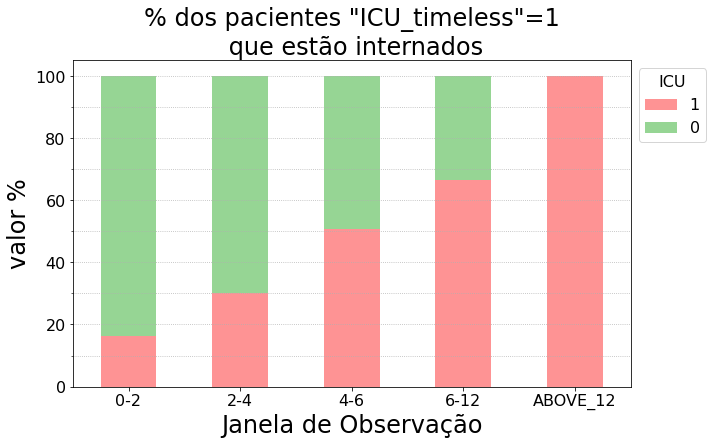

In [ ]:
df_ICU_1_normalized_by_window = df_ICU_1_WINDOW.value_counts(sort=False).reset_index().rename(columns={0:'quant', 'value':'ICU'}).groupby(['WINDOW','ICU']).agg({'quant':'sum'}).groupby('WINDOW').transform(lambda x: x/x.sum()).mul(100).reset_index()
df_ICU_1_normalized_by_window_pivot = df_ICU_1_normalized_by_window.pivot(index='WINDOW',columns=['ICU']).droplevel(0,axis=1) 

ax = df_ICU_1_normalized_by_window_pivot[[1,0]].plot.bar(stacked=True, colormap=ListedColormap(['#FE9394','#96D594']), figsize=(10,6))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.grid(which='both', axis='y',linestyle=':')
ax.set_xlabel('Janela de Observação')
ax.set_ylabel('valor %')
ax.set_title('% dos pacientes "ICU_timeless"=1\n que estão internados');
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(bbox_to_anchor=(1.15, 1),title='ICU')

<a name="eda_cat"></a>
## Informações Qualitativas dos Pacientes
[(voltar para o sumário)](#toc2)


Nesta seção vamos entender como é o perfil majoritário dos pacientes que são internados. Para isso, precisamos explorar as variáveis categóricas (demográficas e de comorbidade) presentes no conjunto de dados.

### **RELAÇÃO ENTRE IDADE DO PACIENTE E CASOS DE INTERNAÇÃO**

Analisando o perfil de idade dos pacientes, conforme mostra o gráfico de barras abaixo, é notável que **conforme o percentil de idade aumenta também aumenta a proporção de casos de internação**.  

A inversão de maioria de casos de internação ocorre no $50^\circ$ percentil. Essa é exatamente a **MEDIANA** das idades dos pacientes. Ou seja, podemos levantar a seguinte hipótese:
> **pacientes confirmados com COVID-19 que possuem idade acima da mediana da população têm mais chances de necessitar de internação na ICU do que de não precisarem.** 

Outra forma de explorar essa relação é considerar que:
> **quanto mais distante da mediana (para uma idade maior), mais provável será a necessidade de internação**.

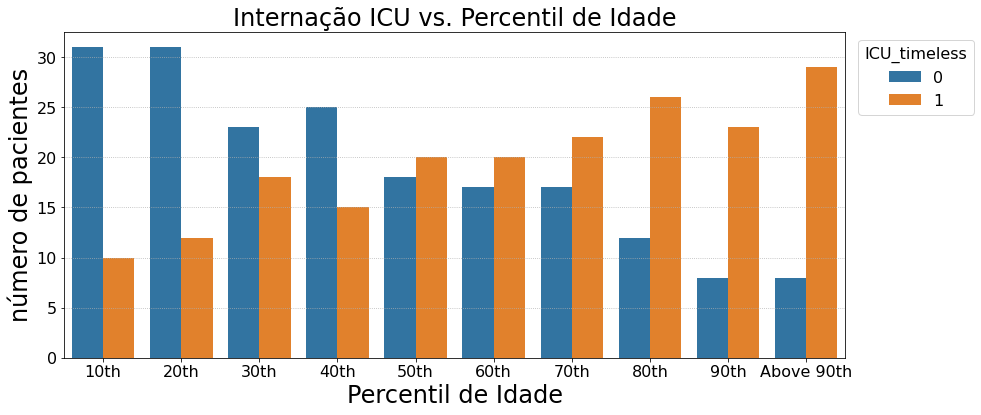

In [ ]:
age_percentil_by_ICU = df_pivot[('AGE_PERCENTIL','0-2')].droplevel(0).reset_index().droplevel(1,axis=1)


countplot_x_categorico_hue_categorico(data=age_percentil_by_ICU,
                                    x='AGE_PERCENTIL', hue='ICU_timeless',
                                    xlabel='Percentil de Idade', ylabel='número de pacientes', 
                                    title='Internação ICU vs. Percentil de Idade',
                                    bbox_to_anchor=(1.175, 1))

# plt.savefig('./ICU_vs_IDADE_percentil.png', dpi=300, transparent=True, bbox_inches='tight')

Provavelmente esse foi o motivo que levou os pesquisadores do Hospital a incluírem uma variável binária ``"AGE_ABOVE65"`` no _dataset_, indicando se o paciente é mais idoso.  

Trocando os percentis de idade por essa variável, temos o resultado gráfico de barras abaixo.



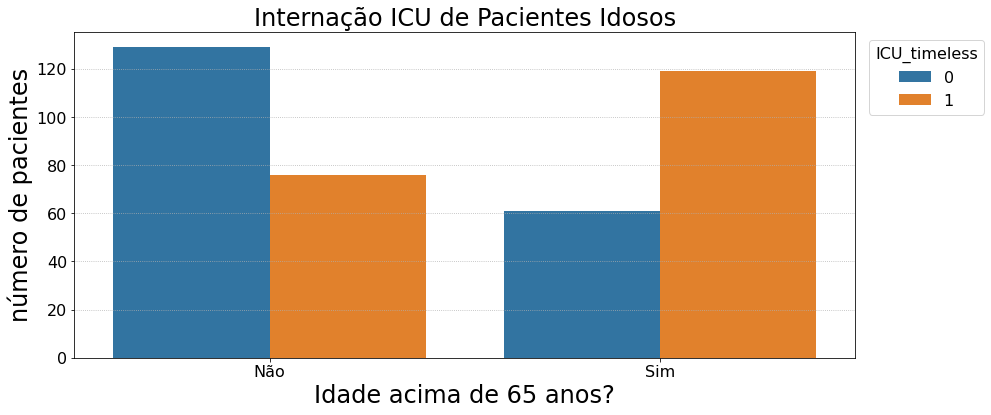

In [ ]:
age_above_65_by_ICU = df_pivot[('AGE_ABOVE65','0-2')].droplevel(0).reset_index().droplevel(1,axis=1).replace({'AGE_ABOVE65':{0:'Não',1:'Sim'}})


countplot_x_categorico_hue_categorico(data=age_above_65_by_ICU,
                                    x='AGE_ABOVE65', hue='ICU_timeless',
                                    xlabel='Idade acima de 65 anos?', ylabel='número de pacientes', 
                                    title='Internação ICU de Pacientes Idosos',
                                    bbox_to_anchor=(1.175, 1))

Fica clara a diferença:
- apenas $32{,}10\%$ ($\approx 1/3$) dos casos que não foram internados (``ICU=0``) correspondem a pacientes com idade acima de 65 anos
- enquanto $61{,}02\%$ ($\approx 3/5$) dos casos de internação na ICU (``ICU=1``) correspondem a pacientes com idade acima de 65 anos

In [ ]:
print('Casos sem internação:')
print(age_above_65_by_ICU.value_counts(sort=False)[0].mul(100/190).rename('%').to_markdown())
print('\nCasos com internação:')
print(age_above_65_by_ICU.value_counts(sort=False)[1].mul(100/195).rename('%').to_markdown())

Casos sem internação:
| AGE_ABOVE65   |       % |
|:--------------|--------:|
| Não           | 67.8947 |
| Sim           | 32.1053 |

Casos com internação:
| AGE_ABOVE65   |       % |
|:--------------|--------:|
| Não           | 38.9744 |
| Sim           | 61.0256 |


E por fim, **filtrando apenas os casos de pacientes idosos**, tambem chegamos na seguinte estatística:
- **$66{,}11\%$ ($\approx 2/3$) dos casos de pacientes idosos resultam em internação na ICU**.

| Internado?   |   % dos Idosos |
|:-------------|---------------:|
| Sim          |        66.1111 |
| Não          |        33.8889 |


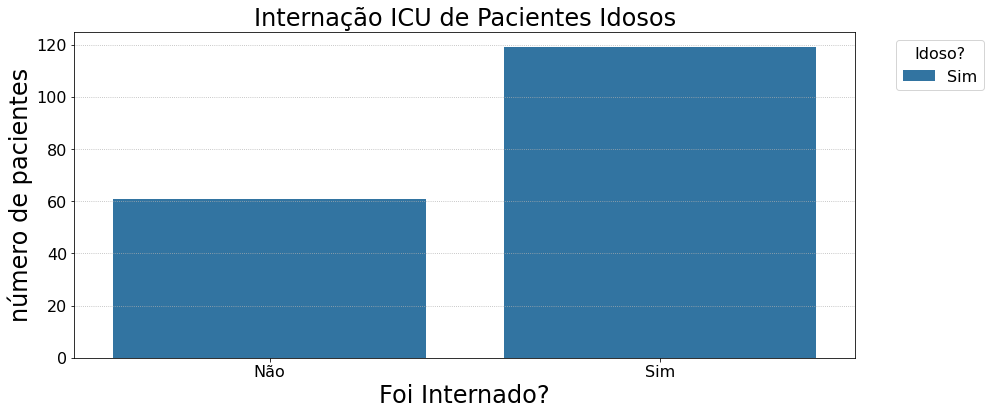

In [ ]:
age_above_65_SIM_by_ICU = age_above_65_by_ICU.query('AGE_ABOVE65 == "Sim"').replace({'ICU_timeless':{0:'Não',1:'Sim'}})
print(age_above_65_SIM_by_ICU['ICU_timeless'].value_counts(normalize=True).mul(100).rename_axis(index='Internado?').rename('% dos Idosos').to_markdown())
countplot_x_categorico_hue_categorico(data=age_above_65_SIM_by_ICU,
                                    x='ICU_timeless', hue='AGE_ABOVE65',
                                    xlabel='Foi Internado?', ylabel='número de pacientes', 
                                    title='Internação ICU de Pacientes Idosos',
                                    bbox_to_anchor=(1.175, 1))
plt.legend(title='Idoso?',bbox_to_anchor=(1.175, 1))

### **RELAÇÃO DO GÊNERO COM AS INTERNAÇÕES**

Ao analisar os casos por gênero, é necessário entender primeiro que também há um desbalanço de número de pacientes entre os dois gêneros rotulados no _dataset_:
- $63.12\%$ dos pacientes são do gênero $0$
- $36.88\%$ dos pacientes são do gênero $1$.


In [ ]:
gender_by_ICU = df_pivot[('GENDER','0-2')].droplevel(0).reset_index().droplevel(1,axis=1)
gender_by_ICU_group_count = gender_by_ICU.groupby('GENDER').count()
print(pd.concat([gender_by_ICU_group_count.rename(columns={'ICU_timeless':'TOTAL'}),
                 gender_by_ICU_group_count.mul(100/385).round(2).rename(columns={'ICU_timeless':'%'})],
                axis=1))

        TOTAL      %
GENDER              
0         243  63.12
1         142  36.88


Analisando o gráfico de barras abaixo, e as tabelas geradas, podemos sugerir as seguintes conclusões:
- dos casos que não necessitam de internação (``ICU=0``), a proporção entre gêneros é bastante próxima;
- **dos casos de internação (``ICU=1``), quase $70\%$ são do gênero $0$**
- dentro de cada grupo,  
  o gênero $0$ tem mais casos de internação ($135$ de $243$, ou seja, $55\%$ das amostras do grupo)  
  do que o gênero $1$ ($60$ de $142$, ou seja, $42\%$ das amostras do grupo)

Em um artigo recente da revista Nature, [pesquisadores do Reino Unido apontam que pacientes do **sexo masculino possuem quase 3 vezes mais chances de morte ou internação na ICU**](https://www.nature.com/articles/s41467-020-19741-6). Analisando os dados discutidos, talvez o gênero $0$ corresponda ao sexo masculino.

Casos sem internação:
        Total      %
GENDER              
0         108  56.84
1          82  43.16

Casos com internação:
        Total      %
GENDER              
0         135  69.23
1          60  30.77


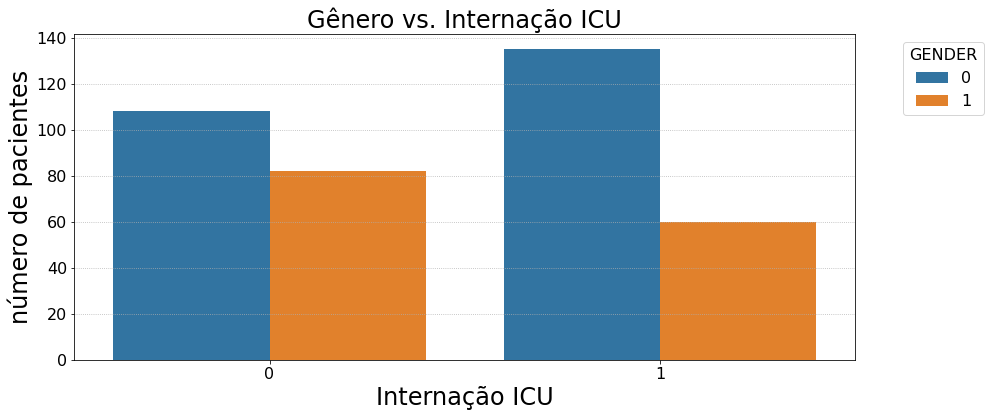

In [ ]:
df_ICU_0_by_gender = gender_by_ICU.query('ICU_timeless==0').drop('ICU_timeless',axis=1).value_counts(sort=False)
df_ICU_1_by_gender = gender_by_ICU.query('ICU_timeless==1').drop('ICU_timeless',axis=1).value_counts(sort=False)
print('Casos sem internação:')
print(pd.concat([df_ICU_0_by_gender.rename('Total'),df_ICU_0_by_gender.mul(100/190).round(2).rename('%')],axis=1))
print('\nCasos com internação:')
print(pd.concat([df_ICU_1_by_gender.rename('Total'),df_ICU_1_by_gender.mul(100/195).round(2).rename('%')],axis=1))

countplot_x_categorico_hue_categorico(data=gender_by_ICU,
                                    x='ICU_timeless', hue='GENDER',
                                    xlabel='Internação ICU', ylabel='número de pacientes', 
                                    title='Gênero vs. Internação ICU',
                                    bbox_to_anchor=(1.175, 1))

### **RELAÇÃO ENTRE INTERNAÇÕES E COMORBIDADES**

O conjunto de dados possui $9$ variáveis categóricas indicando a existência de doenças prévias do paciente:
- $6$ grupos de doenças ``"DISEASE_GROUP_1"`` até ``"DISEASE_GROUP_6"``
- $1$ indicação de hipertensão (``"HTN"``)
- $1$ indicação de doenças que causam comprometimento do sistema imune (``"IMMUNOCOMPROMISED"``)
- $1$ uma indicação para outras doenças (``"OTHER"``).  

Nesta seção, vamos explorar se há alguma indicação forte de relação entre a internação e o fato do paciente possuir alguma dessas doenças prévias.

Inicialmente, podemos observar que possuir pelo menos uma doença prévia não é um fator relevante que diferencia pessoas internadas das demais.

In [ ]:
disease_groups = categorical_vars[3:]
df_disease_groups = df_pivot.loc[:,(disease_groups,'0-2')].droplevel(1,axis=1).droplevel(0)
# df_disease_groups

pacientes_ICU_0_num_comorbidades = df_disease_groups.loc[0].reset_index(drop=True).sum(axis=1)
pacientes_ICU_1_num_comorbidades = df_disease_groups.loc[1].reset_index(drop=True).sum(axis=1)

pacientes_ICU_0_com_alguma_comorbidade = ( pacientes_ICU_0_num_comorbidades > 0 ).sum()
pacientes_ICU_1_com_alguma_comorbidade = ( pacientes_ICU_1_num_comorbidades > 0 ).sum()

print(f'Dos pacientes ICU=0 (nunca são internados), {pacientes_ICU_0_com_alguma_comorbidade} ({pacientes_ICU_0_com_alguma_comorbidade*100/190:3.2f}%) tem pelo menos uma comorbidade')
print(f'Dos pacientes ICU=1 (são internados em algum momento), {pacientes_ICU_1_com_alguma_comorbidade} ({pacientes_ICU_1_com_alguma_comorbidade*100/195:3.2f}%) tem pelo menos uma comorbidade') 

Dos pacientes ICU=0 (nunca são internados), 155 (81.58%) tem pelo menos uma comorbidade
Dos pacientes ICU=1 (são internados em algum momento), 166 (85.13%) tem pelo menos uma comorbidade


Buscando detalhar melhor se a **quantidade de doenças prévias** tem alguma influência, observa-se que pacientes que tem entre 2 e 5 doenças prévias podem sugerir maior chance de internação.  

Entretanto, talvez isso esteja mais associado ao tipo de doença, e não às quantidades.

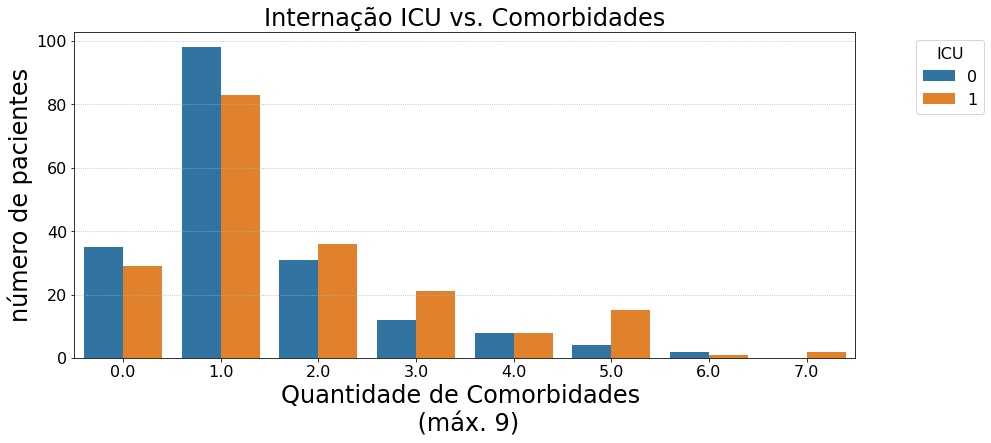

In [ ]:
quantidade_comorbidades = pd.concat([pd.concat([df_disease_groups.loc[0].index.to_series().reset_index(drop=True),pacientes_ICU_0_num_comorbidades],axis=1),
                                     pd.concat([df_disease_groups.loc[1].index.to_series().reset_index(drop=True),pacientes_ICU_1_num_comorbidades],axis=1)
                                     ]).rename(columns={'ICU_timeless':'ICU',0:'#DIS'})

countplot_x_categorico_hue_categorico(data=quantidade_comorbidades,
                                      x='#DIS', hue='ICU',
                                      xlabel='Quantidade de Comorbidades \n (máx. 9)', ylabel='número de pacientes', 
                                      title='Internação ICU vs. Comorbidades',
                                      bbox_to_anchor=(1.175, 1))

Ao listar os **tipos de doença e separar entre os grupos de pacientes** que não foram internados (``ICU=0``) e os que foram (``ICU=1``), já se observam algumas relações mais interessantes:
- as doenças ``DISEASE GROUPING 4`` tem uma razão de $6$ para $1$ entre pacientes internados vs. não internados  
 (apesar de só haver $7$ pacientes nesse grupo)
- as doenças ``DISEASE GROUPING 2`` tem uma razão de $3{,}5$ para $1$ entre pacientes internados vs. não internados  
 (apesar de só haver $9$ pacientes nesse grupo)
- pacientes hipertensos (``HTN``) tem uma razão aprox. de $2{,}1$ para $1$ entre pacientes internados vs. não internados  
 (nesse caso a amostra tem $75$ casos)
- as doenças ``DISEASE GROUPING 3`` tem uma razão aprox. de $2{,}1$ para $1$ entre pacientes internados vs. não internados  
 (nesse caso a amostra tem $34$ casos)

In [ ]:
df_disease_groups_sum_by_ICU = pd.concat([df_disease_groups.loc[0].sum().rename('ICU=0'),
                                          df_disease_groups.loc[1].sum().rename('ICU=1')],
                                         axis=1)
df_disease_groups_sum_by_ICU['ratio ICU1/ICU0'] = (df_disease_groups_sum_by_ICU['ICU=1']/df_disease_groups_sum_by_ICU['ICU=0']).round(2)
print(df_disease_groups_sum_by_ICU.to_markdown())


|                    |   ICU=0 |   ICU=1 |   ratio ICU1/ICU0 |
|:-------------------|--------:|--------:|------------------:|
| DISEASE GROUPING 1 |      16 |      23 |              1.44 |
| DISEASE GROUPING 2 |       2 |       7 |              3.5  |
| DISEASE GROUPING 3 |      11 |      23 |              2.09 |
| DISEASE GROUPING 4 |       1 |       6 |              6    |
| DISEASE GROUPING 5 |      17 |      30 |              1.76 |
| DISEASE GROUPING 6 |       9 |       6 |              0.67 |
| HTN                |      24 |      51 |              2.12 |
| IMMUNOCOMPROMISED  |      26 |      34 |              1.31 |
| OTHER              |     154 |     165 |              1.07 |


O gráfico abaixo mostra as mesmas relações em números absolutos, evidenciando que os grupos "``OTHER``", "``HTN``" e ``"DISEASE GROUPING 5"`` parecem ser mais prevalentes na população em geral.

Text(0, 0.5, 'número de pacientes')

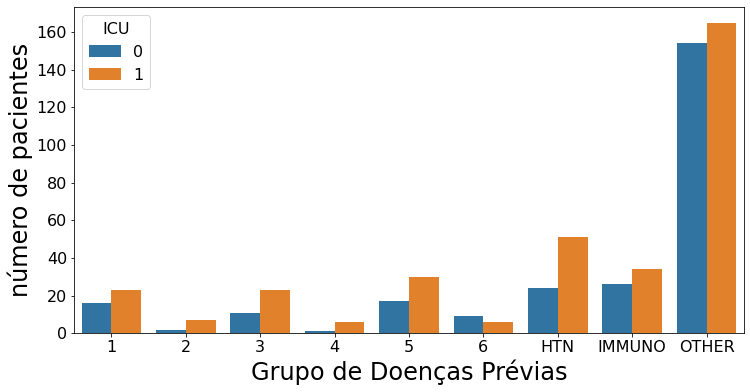

In [ ]:
df_disease_groups_sum_by_ICU_barplot = df_disease_groups_sum_by_ICU.reset_index().rename(columns={'index':'disease group'}).replace(
    {'disease group':{f'DISEASE GROUPING {i}':i for i in range(1,7)}}).replace({'disease group':{'IMMUNOCOMPROMISED':'IMMUNO'}})
df_disease_groups_sum_by_ICU_barplot = df_disease_groups_sum_by_ICU_barplot.melt(id_vars='disease group',value_vars=['ICU=0','ICU=1']).rename(columns={'variable':'ICU'}).replace({'ICU':{f'ICU={i}':i for i in [0,1]}})
# df_disease_groups_sum_by_ICU_barplot['value'].sum() # SANITY CHECK

plt.figure(figsize=(12,6))
sns.barplot(data=df_disease_groups_sum_by_ICU_barplot,
            y='value', x='disease group',hue='ICU')
plt.xlabel('Grupo de Doenças Prévias')
plt.ylabel('número de pacientes')

Uma **curiosidade**: investigando a distribuição dos pacientes nos grupos de doenças prévias, resolvi cruzar a informaçao com o percentil de idade. Observando as tabelas abaixo, podemos observar que esses 4 grupos de doenças (``'DISEASE GROUPING 1'``, ``'DISEASE GROUPING 5'``, ``'HTN'`` e `` 'IMMUNOCOMPROMISED'``) têm baixa incidência nos percentis de idades mais baixos, mas passam a aumentar proporcionalmente com o aumento da idade. É importante observar isso porque mostra uma correlação entre a o avanço da idade e potenciais comorbidades do paciente. 

In [ ]:
 for dis_name in ['DISEASE GROUPING 1','DISEASE GROUPING 5','HTN','IMMUNOCOMPROMISED']:
  df_dis = df_pivot.loc[:,([dis_name,'AGE_PERCENTIL'],'0-2')].droplevel(0).droplevel(1,axis=1).replace({dis_name:{0:'Não',1:'Sim'}}).dropna()
  # print(dis_name)
  print(pd.crosstab(df_dis[dis_name],df_dis['AGE_PERCENTIL'],normalize='columns').mul(100).round(2).to_markdown(),end='\n\n')

| DISEASE GROUPING 1   |   10th |   20th |   30th |   40th |   50th |   60th |   70th |   80th |   90th |   Above 90th |
|:---------------------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------------:|
| Não                  |     95 |  97.67 |  97.56 |   97.5 |    100 |  91.89 |  87.18 |  86.84 |  74.19 |        64.86 |
| Sim                  |      5 |   2.33 |   2.44 |    2.5 |      0 |   8.11 |  12.82 |  13.16 |  25.81 |        35.14 |

| DISEASE GROUPING 5   |   10th |   20th |   30th |   40th |   50th |   60th |   70th |   80th |   90th |   Above 90th |
|:---------------------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------------:|
| Não                  |    100 |  97.67 |  92.68 |   97.5 |  94.74 |  89.19 |  84.62 |  73.68 |  74.19 |        67.57 |
| Sim                  |      0 |   2.33 |   7.32 |    2.5 |   5.26 |  10.81 |  15.38 |  26.32 |  25.81 |        32.43 |

| HTN   |   10th |   20th |   

In [ ]:
# Esse trecho é uma forma de fazer uma relação de prevalência de uma doença por gênero
# entretanto não revelou nenhuma distorção significativa que pudesse mostrar algum grupo de doenças com maior prevalência em algum gênero
# 
# for dis_name in disease_groups:
#   df_dis = df_pivot.loc[:,([dis_name,'GENDER'],'0-2')].droplevel(0).droplevel(1,axis=1).replace({dis_name:{0:'Não',1:'Sim'}}).dropna()
#   print(dis_name)
#   print(pd.crosstab(df_dis['GENDER'],df_dis[dis_name],normalize='index').mul(100).round(2).to_markdown(),end='\n\n')

<a name="eda_cont"></a>
## Exames de Sangue e Sinais Vitais
[(voltar para o sumário)](#toc2)


Após a análise das variáveis categóricas, passamos a dar atenção para o conteúdo das **variáveis contínuas** do conjunto de dados.  

É importante reforçar que temos um número grande de variáveis contínuas, divididas entre exames de sangue e sinais vitais, além de muitas estatísticas da mesma variável (valores médios, medianas, mínimos, máximos, diferenciais):
- $36$ exames de sangue únicos, cada um com $5$ estatísticas diferentes (total: $180$ colunas) 
- $6$ medidas únicas de sinais vitais, cada um com $6$ estatísticas diferentes (total: $36$ colunas)

In [ ]:
vitals_dict = group_same_continous_vars(patient_vitals_cols)
blood_dict  = group_same_continous_vars(patient_blood_cols)

print(f'Sinais vitais: {len(vitals_dict)} tipos presentes em {len(patient_vitals_cols)} colunas')
print(*enumerate(sorted(vitals_dict.keys())), sep='\n')

print(f'Exames de sangue: {len(blood_dict)} tipos presentes em {len(patient_blood_cols)} colunas')
print(*enumerate(sorted(blood_dict.keys())), sep='\n')

Sinais vitais: 6 tipos presentes em 36 colunas
(0, 'BLOODPRESSURE DIASTOLIC')
(1, 'BLOODPRESSURE SISTOLIC')
(2, 'HEART RATE')
(3, 'OXYGEN SATURATION')
(4, 'RESPIRATORY RATE')
(5, 'TEMPERATURE')
Exames de sangue: 36 tipos presentes em 180 colunas
(0, 'ALBUMIN')
(1, 'BE ARTERIAL')
(2, 'BE VENOUS')
(3, 'BIC ARTERIAL')
(4, 'BIC VENOUS')
(5, 'BILLIRUBIN')
(6, 'BLAST')
(7, 'CALCIUM')
(8, 'CREATININ')
(9, 'DIMER')
(10, 'FFA')
(11, 'GGT')
(12, 'GLUCOSE')
(13, 'HEMATOCRITE')
(14, 'HEMOGLOBIN')
(15, 'INR')
(16, 'LACTATE')
(17, 'LEUKOCYTES')
(18, 'LINFOCITOS')
(19, 'NEUTROPHILES')
(20, 'P02 ARTERIAL')
(21, 'P02 VENOUS')
(22, 'PC02 ARTERIAL')
(23, 'PC02 VENOUS')
(24, 'PCR')
(25, 'PH ARTERIAL')
(26, 'PH VENOUS')
(27, 'PLATELETS')
(28, 'POTASSIUM')
(29, 'SAT02 ARTERIAL')
(30, 'SAT02 VENOUS')
(31, 'SODIUM')
(32, 'TGO')
(33, 'TGP')
(34, 'TTPA')
(35, 'UREA')


Para analisar a importância de tantas variáveis contínuas, optei por criar alguns critérios automáticos de eliminação. Nas próximas etapas, vou analisar:
- variáveis com variância nula
- variáveis com baixa variância
- variáveis fortemente correlacionadas.  

É importante reforçar ainda que essas análise serão feitas **considerando as medidas apenas da primeira janela de observação (``'0-2'``)**. Isso porque já observei que algumas variáveis com baixíssima dispersão de valores da primeira janela acabam por dispersar mais em janelas futuras. Entretanto, não é possível garantir que teremos janelas futuras de todos os pacientes. Portanto, optei por descartar essas informações **pensando em treinar o melhor modelo possível capaz de fazer as previsões já na primeira janela**, com variáveis que sirvam pra separar os casos de internação dos que não irão internar.

### **VARIÁVEIS COM VARIÂNCIA NULA OU MUITO BAIXA (NA JANELA ``'0-2'``)**

Após algumas explorações, pode-se notar que existem algumas variáveis que são iguais em todos os exames da janela ``"0-2"`` para todos os pacientes com dados presentes. Um exemplo é a ``'BE_ARTERIAL_MEAN'`` :

In [ ]:
df_pivot.loc[:,('BE_ARTERIAL_MEAN','0-2')].dropna().std()

0.0

Outros casos são quase todas as variáveis ``'DIFF'``, as quais quando não estão presentes possuem um único valor $-1$.  
Por exemplo:

In [ ]:
df_pivot.loc[:,(['PH_VENOUS_DIFF','PLATELETS_DIFF','POTASSIUM_DIFF'],'0-2')].describe().loc[['count','mean','std']]

,PH_VENOUS_DIFF,PLATELETS_DIFF,POTASSIUM_DIFF
WINDOW,0-2,0-2,0-2
count,172.0,172.0,172.0
mean,-1.0,-1.0,-1.0
std,0.0,0.0,0.0


Esse fato para as variáveis ``"DIFF"`` se justifica pela necessidade de pelo menos duas amostras (ou seja, duas janelas) para calcular o valor diferencial. Portanto, pode-se esperar que o desvio vá aumentando com o tempo. Entretanto, isso não acontece com muitas delas.  

Para exemplificar, veja a evolução do desvio padrão das variáveis a seguir:
- ``'PLATELETS_DIFF'`` possui variância nula em todas as janelas
- ``'BE_ARTERIAL_MEAN'`` possui variância apenas na primeira janela, mas sua dispersão aumenta um pouco até a última janela de observação
- ``'RESPIRATORY_RATE_DIFF'`` possui variância muito baixa nas primeiras janelas, mas a dispersão aumenta significativamente nas últimas.

In [ ]:
df_pivot.loc[:,['PLATELETS_DIFF','BE_ARTERIAL_MEAN','RESPIRATORY_RATE_DIFF']].describe().loc[['std']].T

std
                      WINDOW            
PLATELETS_DIFF        0-2       0.000000
                      2-4       0.000000
                      4-6       0.000000
                      6-12      0.000000
                      ABOVE_12  0.000000
BE_ARTERIAL_MEAN      0-2       0.000000
                      2-4       0.003216
                      4-6       0.093330
                      6-12      0.072409
                      ABOVE_12  0.229087
RESPIRATORY_RATE_DIFF 0-2       0.077726
                      2-4       0.072937
                      4-6       0.115371
                      6-12      0.187374
                      ABOVE_12  0.553537

Com base na análise anterior, **vamos montar uma lista das variáveis com dispersão (desvio padrão, variância) nula ou muito baixa na primeira janela**.  

A ideia principal é usar essa lista para **remover essas variáveis do modelo**.  
Uma variável ``low_std_th``$\in \left[0, 1\right]$ com  o limiar do desvio padrão pode ser ajustada conforme o critério desejado. Quanto mais baixo o valor do limiar, menos variáveis são eliminadas (igualdade em zero só remove as de dispersão nula).

In [ ]:
#@title Limiar de eliminação de variáveis de baixa de dispersão 

#@markdown Manter apenas variáveis contíuas com desvio padrão superior ao valor selecionado para o limiar.
low_std_th = 0 #@param {type:"slider", min:0, max:1, step:0.01}
print(f'low_std_th: {low_std_th}')
print('OBS: para alterar o valor, é necessário usar o slider E rodar a célula novamente.')

low_std_th: 0
OBS: para alterar o valor, é necessário usar o slider E rodar a célula novamente.


In [ ]:
# cria um dataframe do desvio padrão das variáveis contínuas 
df_std = df_pivot[continuous_vars].std()
# filtra as variáveis de baixa dispersão na janela '0-2' e salva seus nomes numa lista
vars_to_drop = df_std[ df_std<= low_std_th ].loc[(slice(None),'0-2')].index.tolist()

# salva em uma nova lista apenas as variáveis que não foram eliminadas
continuous_vars_std = list(set(continuous_vars).difference(set(vars_to_drop)))

print(f'{len(continuous_vars_std)} variáveis contínuas (de um total de {len(continuous_vars)}) não possuem baixa dispersão na janela analisada.')

176 variáveis contínuas (de um total de 216) não possuem baixa dispersão na janela analisada.


Note que foram **eliminadas $40$** variáveis de baixa dispersão! (``low_std_th=0.00``)  

In [ ]:
print(f'Variáveis de baixa dispersão para eliminar ({len(vars_to_drop)}):\n')
print(*[f'{k} ({len(v)}): {", ".join(v)}' for k, v in group_same_continous_vars(vars_to_drop).items()],sep='\n')

Variáveis de baixa dispersão para eliminar (40):

ALBUMIN (1): DIFF
BE ARTERIAL (5): DIFF, MAX, MEAN, MEDIAN, MIN
BE VENOUS (1): DIFF
BIC ARTERIAL (1): DIFF
BIC VENOUS (1): DIFF
BILLIRUBIN (1): DIFF
BLAST (1): DIFF
CALCIUM (1): DIFF
CREATININ (1): DIFF
DIMER (1): DIFF
FFA (1): DIFF
GGT (1): DIFF
GLUCOSE (1): DIFF
HEMATOCRITE (1): DIFF
HEMOGLOBIN (1): DIFF
INR (1): DIFF
LACTATE (1): DIFF
LEUKOCYTES (1): DIFF
LINFOCITOS (1): DIFF
NEUTROPHILES (1): DIFF
P02 ARTERIAL (1): DIFF
P02 VENOUS (1): DIFF
PC02 ARTERIAL (1): DIFF
PC02 VENOUS (1): DIFF
PCR (1): DIFF
PH ARTERIAL (1): DIFF
PH VENOUS (1): DIFF
PLATELETS (1): DIFF
POTASSIUM (1): DIFF
SAT02 ARTERIAL (1): DIFF
SAT02 VENOUS (1): DIFF
SODIUM (1): DIFF
TGO (1): DIFF
TGP (1): DIFF
TTPA (1): DIFF
UREA (1): DIFF


**Restam agora $176$** variáveis para o modelo.

In [ ]:
print(f'Variáveis não-eliminadas (dispersão significativa) ({len(continuous_vars_std)}):\n')
print(*[f'{k} ({len(v)}): {", ".join(v)}' for k, v in group_same_continous_vars(continuous_vars_std).items()],sep='\n')

Variáveis não-eliminadas (dispersão significativa) (176):

ALBUMIN (4): MAX, MEAN, MEDIAN, MIN
BE VENOUS (4): MAX, MEAN, MEDIAN, MIN
BIC ARTERIAL (4): MAX, MEAN, MEDIAN, MIN
BIC VENOUS (4): MAX, MEAN, MEDIAN, MIN
BILLIRUBIN (4): MAX, MEAN, MEDIAN, MIN
BLAST (4): MAX, MEAN, MEDIAN, MIN
BLOODPRESSURE DIASTOLIC (6): DIFF, DIFF REL, MAX, MEAN, MEDIAN, MIN
BLOODPRESSURE SISTOLIC (6): DIFF, DIFF REL, MAX, MEAN, MEDIAN, MIN
CALCIUM (4): MAX, MEAN, MEDIAN, MIN
CREATININ (4): MAX, MEAN, MEDIAN, MIN
DIMER (4): MAX, MEAN, MEDIAN, MIN
FFA (4): MAX, MEAN, MEDIAN, MIN
GGT (4): MAX, MEAN, MEDIAN, MIN
GLUCOSE (4): MAX, MEAN, MEDIAN, MIN
HEART RATE (6): DIFF, DIFF REL, MAX, MEAN, MEDIAN, MIN
HEMATOCRITE (4): MAX, MEAN, MEDIAN, MIN
HEMOGLOBIN (4): MAX, MEAN, MEDIAN, MIN
INR (4): MAX, MEAN, MEDIAN, MIN
LACTATE (4): MAX, MEAN, MEDIAN, MIN
LEUKOCYTES (4): MAX, MEAN, MEDIAN, MIN
LINFOCITOS (4): MAX, MEAN, MEDIAN, MIN
NEUTROPHILES (4): MAX, MEAN, MEDIAN, MIN
OXYGEN SATURATION (6): DIFF, DIFF REL, MAX, MEAN, 

### **VARIÁVEIS ALTAMENTE CORRELACIONADAS (NA JANELA ``'0-2'``)**

Em problemas de regressão linear, queremos explicar o comportamento de uma variável dependente a partir das observações de um conjunto de variáveis independentes.  

Nesse contexto, é preciso ficar atento ao problema da **multicolinearidade**.  
De maneira simples, é **um fenômeno que ocorre quando há correção de uma das variáveis explicativas com outra variável explicativa (ou com uma combinação de outras delas)** [veja mais nesse artigo do Towards Data Science](https://towardsdatascience.com/multicollinearity-why-is-it-a-problem-398b010b77ac).  

O ponto negativo é que **a significância estatística dos coeficientes da regressão é "inflada"** por causa dessas correlações. Ou seja, o coeficiente não pode ser usado para explicar diretamente a influência daquela variável no comportamento da variável dependente.

Uma forma de minimizar os efeitos da multicolinearidade é **remover variáveis fortemente correlacionadas do modelo (manter apenas uma delas)**. Isso não garante que não haverá multicolinearidade devido a correlação entre combinações de variáveis, mas facilita o processo de análise para encontrar as variáveis que podem causar esse efeito.



A função a seguir realiza um procedimento para eliminar variáveis fortemente correlacionadas, mantendo apenas uma de cada grupo com forte correlação.  

Novamente, um limiar de decisão precisa ser definido para julgar se duas variáveis são fortemente correlacionadas.  
Aqui, usamos a variável ``"high_corr_th"``.

In [ ]:
#@title Limiar de eliminação de variáveis altamente correlacionadas 
#@markdown Manter apenas uma por grupo fortemente correlacionado (correlação forte com base no limiar selecionado).
high_corr_th = 1 #@param {type:"slider", min:0, max:1, step:0.01}
print(f'high_corr_th: {high_corr_th}')
print('OBS: para alterar o valor, é necessário usar o slider E rodar a célula novamente.')

high_corr_th: 1
OBS: para alterar o valor, é necessário usar o slider E rodar a célula novamente.


In [ ]:
# cria a matriz de correlação
corr_matrix = df[continuous_vars_std].dropna().corr()
# cria uma máscara diagonal no shape da matriz de correlação
mask = np.diag(np.diag(corr_matrix))
# usa a máscara para zerar os valores da diagonal princial (não devemos analisar o pareamento da variável com ela mesma, pois a corr. é sempre 1)
masked_corr_matrix = corr_matrix*(mask==0)
# transforma os valores de correlação em valores absolutos (o sinal não é relevante nesse procedimento)
masked_corr_matrix_abs = masked_corr_matrix.abs()

# procedimento para identificar os grupos de variáveis fortemente correlacionadas, sem repetição de nomes de colunas
walk_vars_set = set()
drop_vars_set = set()
print('Varíaveis fortemente correlacionadas: \n')
for col in masked_corr_matrix_abs: # percorre os nomes das colunas que geraram a matriz de correlação
    var_col = masked_corr_matrix_abs[col] # seleciona a coluna da matriz
    filtro_bool = var_col>high_corr_th    # verifica as linhas onde o limiar é satisfeito 
    if any(filtro_bool):                  # se houver alguma correlação forte, faz o próximo procedimento
        corr_vars_list = var_col[filtro_bool].index.tolist()      # lista o nome das variáveis fortemente correlacionadas com a da coluna atual
        corr_vars_set  = set(corr_vars_list)                      # transforma a lista em um conjunto
        new_vars       = corr_vars_set.difference(walk_vars_set)  # identificia novas variáveis que não foram filtradas nas iterações anteriores
        walk_vars_set  = walk_vars_set.union(corr_vars_set).union(set([col])) # salva as novas variáveis no conjunto de todas as variáveis já identificadas, incluindo a coluna atual
        if len(new_vars)>0: # se houver novas variáveis
            drop_vars_set  = drop_vars_set.union(new_vars) # acrescentá-las no conjunto de variáveis para serem removidas
            print(col,'\n\t'.join(new_vars),sep='\n\t')    # imprime o nome da coluna atual e a lista de variáveis correlacionadas com ela

Varíaveis fortemente correlacionadas: 



In [ ]:
# SAÍDA DA CÉLULA ACIMA QUANDO high_corr_th: 0.9

'''Varíaveis fortemente correlacionadas: 

PH_VENOUS_MAX
	PH_VENOUS_MEDIAN
	PH_VENOUS_MEAN
	PH_VENOUS_MIN
LINFOCITOS_MAX
	LINFOCITOS_MEDIAN
	LINFOCITOS_MIN
	LINFOCITOS_MEAN
GLUCOSE_MEAN
	GLUCOSE_MAX
	GLUCOSE_MEDIAN
	GLUCOSE_MIN
RESPIRATORY_RATE_MEDIAN
	RESPIRATORY_RATE_MEAN
DIMER_MEAN
	DIMER_MIN
	DIMER_MAX
	DIMER_MEDIAN
LEUKOCYTES_MEAN
	NEUTROPHILES_MEDIAN
	LEUKOCYTES_MAX
	NEUTROPHILES_MEAN
	LEUKOCYTES_MIN
	LEUKOCYTES_MEDIAN
	NEUTROPHILES_MIN
	NEUTROPHILES_MAX
TEMPERATURE_DIFF_REL
	TEMPERATURE_DIFF
BLAST_MEAN
	BLAST_MEDIAN
	BLAST_MIN
	BLAST_MAX
P02_VENOUS_MAX
	P02_VENOUS_MIN
	P02_VENOUS_MEAN
	P02_VENOUS_MEDIAN
INR_MAX
	INR_MIN
	INR_MEDIAN
	INR_MEAN
P02_ARTERIAL_MEAN
	P02_ARTERIAL_MIN
	P02_ARTERIAL_MAX
	P02_ARTERIAL_MEDIAN
PH_ARTERIAL_MEDIAN
	PH_ARTERIAL_MAX
	PH_ARTERIAL_MEAN
	PH_ARTERIAL_MIN
HEMOGLOBIN_MAX
	HEMOGLOBIN_MIN
	HEMATOCRITE_MEAN
	HEMATOCRITE_MEDIAN
	HEMOGLOBIN_MEAN
	HEMOGLOBIN_MEDIAN
	HEMATOCRITE_MAX
	HEMATOCRITE_MIN
TGO_MIN
	TGO_MEAN
	TGO_MEDIAN
	TGP_MEDIAN
	TGP_MEAN
	TGP_MIN
	TGO_MAX
	TGP_MAX
HEART_RATE_MEAN
	HEART_RATE_MEDIAN
OXYGEN_SATURATION_MIN
	OXYGEN_SATURATION_DIFF
	OXYGEN_SATURATION_DIFF_REL
BILLIRUBIN_MEDIAN
	BILLIRUBIN_MIN
	BILLIRUBIN_MEAN
	BILLIRUBIN_MAX
BE_VENOUS_MEDIAN
	BE_VENOUS_MIN
	BE_VENOUS_MEAN
	BE_VENOUS_MAX
BLOODPRESSURE_SISTOLIC_MEDIAN
	BLOODPRESSURE_SISTOLIC_MEAN
ALBUMIN_MIN
	ALBUMIN_MAX
	ALBUMIN_MEAN
	ALBUMIN_MEDIAN
BIC_ARTERIAL_MEAN
	BIC_ARTERIAL_MAX
	BIC_ARTERIAL_MEDIAN
	BIC_ARTERIAL_MIN
BLOODPRESSURE_DIASTOLIC_DIFF_REL
	BLOODPRESSURE_DIASTOLIC_DIFF
BLOODPRESSURE_SISTOLIC_DIFF_REL
	BLOODPRESSURE_SISTOLIC_DIFF
GGT_MEDIAN
	GGT_MIN
	GGT_MAX
	GGT_MEAN
UREA_MAX
	UREA_MEAN
	UREA_MEDIAN
	UREA_MIN
BIC_VENOUS_MEAN
	BIC_VENOUS_MIN
	BIC_VENOUS_MEDIAN
	BIC_VENOUS_MAX
POTASSIUM_MAX
	POTASSIUM_MIN
	POTASSIUM_MEAN
	POTASSIUM_MEDIAN
LACTATE_MEAN
	LACTATE_MEDIAN
	LACTATE_MIN
	LACTATE_MAX
PLATELETS_MIN
	PLATELETS_MEAN
	PLATELETS_MEDIAN
	PLATELETS_MAX
SAT02_ARTERIAL_MIN
	SAT02_ARTERIAL_MEDIAN
	SAT02_ARTERIAL_MAX
	SAT02_ARTERIAL_MEAN
SODIUM_MAX
	SODIUM_MIN
	SODIUM_MEAN
	SODIUM_MEDIAN
CREATININ_MEDIAN
	CREATININ_MEAN
	CREATININ_MIN
	CREATININ_MAX
BLOODPRESSURE_DIASTOLIC_MEDIAN
	BLOODPRESSURE_DIASTOLIC_MEAN
SAT02_VENOUS_MEAN
	SAT02_VENOUS_MIN
	SAT02_VENOUS_MAX
	SAT02_VENOUS_MEDIAN
CALCIUM_MIN
	CALCIUM_MEAN
	CALCIUM_MAX
	CALCIUM_MEDIAN
TEMPERATURE_MEDIAN
	TEMPERATURE_MEAN
RESPIRATORY_RATE_DIFF
	RESPIRATORY_RATE_MAX
	RESPIRATORY_RATE_DIFF_REL
PC02_ARTERIAL_MIN
	PC02_ARTERIAL_MEAN
	PC02_ARTERIAL_MAX
	PC02_ARTERIAL_MEDIAN
PCR_MIN
	PCR_MEAN
	PCR_MAX
	PCR_MEDIAN
PC02_VENOUS_MIN
	PC02_VENOUS_MEAN
	PC02_VENOUS_MEDIAN
	PC02_VENOUS_MAX
TTPA_MIN
	TTPA_MEDIAN
	TTPA_MAX
	TTPA_MEAN
HEART_RATE_DIFF
	HEART_RATE_DIFF_REL
FFA_MIN
	FFA_MEAN
	FFA_MAX
	FFA_MEDIAN'''

'Varíaveis fortemente correlacionadas: \n\nPH_VENOUS_MAX\n\tPH_VENOUS_MEDIAN\n\tPH_VENOUS_MEAN\n\tPH_VENOUS_MIN\nLINFOCITOS_MAX\n\tLINFOCITOS_MEDIAN\n\tLINFOCITOS_MIN\n\tLINFOCITOS_MEAN\nGLUCOSE_MEAN\n\tGLUCOSE_MAX\n\tGLUCOSE_MEDIAN\n\tGLUCOSE_MIN\nRESPIRATORY_RATE_MEDIAN\n\tRESPIRATORY_RATE_MEAN\nDIMER_MEAN\n\tDIMER_MIN\n\tDIMER_MAX\n\tDIMER_MEDIAN\nLEUKOCYTES_MEAN\n\tNEUTROPHILES_MEDIAN\n\tLEUKOCYTES_MAX\n\tNEUTROPHILES_MEAN\n\tLEUKOCYTES_MIN\n\tLEUKOCYTES_MEDIAN\n\tNEUTROPHILES_MIN\n\tNEUTROPHILES_MAX\nTEMPERATURE_DIFF_REL\n\tTEMPERATURE_DIFF\nBLAST_MEAN\n\tBLAST_MEDIAN\n\tBLAST_MIN\n\tBLAST_MAX\nP02_VENOUS_MAX\n\tP02_VENOUS_MIN\n\tP02_VENOUS_MEAN\n\tP02_VENOUS_MEDIAN\nINR_MAX\n\tINR_MIN\n\tINR_MEDIAN\n\tINR_MEAN\nP02_ARTERIAL_MEAN\n\tP02_ARTERIAL_MIN\n\tP02_ARTERIAL_MAX\n\tP02_ARTERIAL_MEDIAN\nPH_ARTERIAL_MEDIAN\n\tPH_ARTERIAL_MAX\n\tPH_ARTERIAL_MEAN\n\tPH_ARTERIAL_MIN\nHEMOGLOBIN_MAX\n\tHEMOGLOBIN_MIN\n\tHEMATOCRITE_MEAN\n\tHEMATOCRITE_MEDIAN\n\tHEMOGLOBIN_MEAN\n\tHEMOGLOBIN_MEDIA

Após esse procedimento, faz-se a diferença entre o conjunto das variáveis contínuas que tínhamos até então e o conjunto das novas variáveis a serem removidas.  

> <font color=#FF0000> **NOTA**: quando foram usados os limiares ``low_std_th=0.15`` e ``high_corr_th: 0.75``, restaram agora apenas $26$ variáveis para o modelo.</font> <font color=#338833> sendo que **todos os sinais vitais permaneceram e com mais de uma estatística de cada um.**</font>
> 
> <font color=#FF0000> Entretanto, **após muitos testes**, observou-se que os modelos conseguem fazer melhores previsões mantendo o maior número possível de variáveis. </font>
>
> <font color=#338844> Portanto, em função disso, optei por manter no resultado final os limiares ``low_std_th=0.0`` (elimina apenas variáveis de dispersão nula) e ``high_corr_th: 1`` (não elimina variáveis fortemente correlacionadas). Isso pode ser um problema para confiança na sensibilidade da variável dependente em relação aos coeficientes da variável indepdendente (no caso da regressão logística), mas vai garantir o maior poder de previsão do modelo. 
>
> Por isso, a lista de variáveis fortemente correlacionadas acima ficou vazia, como resultado, ainda se tem $176$ variáveis selecionadas. Se desejar testar o caderno para um caso diferente, use um valor de ``high_corr_th < 1``.

In [ ]:
# conjunto de variáveis independentes que restaram
continuous_vars_std_uncorr = set(continuous_vars_std).difference(drop_vars_set)
print(f'\nVaríaveis independentes (analisadas em pares) restantes {len(continuous_vars_std_uncorr)}: \n')
print(*[f'{k} ({len(v)}): {", ".join(v)}' for k, v in group_same_continous_vars(list(continuous_vars_std_uncorr)).items()],sep='\n')


Varíaveis independentes (analisadas em pares) restantes 176: 

ALBUMIN (4): MAX, MEAN, MEDIAN, MIN
BE VENOUS (4): MAX, MEAN, MEDIAN, MIN
BIC ARTERIAL (4): MAX, MEAN, MEDIAN, MIN
BIC VENOUS (4): MAX, MEAN, MEDIAN, MIN
BILLIRUBIN (4): MAX, MEAN, MEDIAN, MIN
BLAST (4): MAX, MEAN, MEDIAN, MIN
BLOODPRESSURE DIASTOLIC (6): DIFF, DIFF REL, MAX, MEAN, MEDIAN, MIN
BLOODPRESSURE SISTOLIC (6): DIFF, DIFF REL, MAX, MEAN, MEDIAN, MIN
CALCIUM (4): MAX, MEAN, MEDIAN, MIN
CREATININ (4): MAX, MEAN, MEDIAN, MIN
DIMER (4): MAX, MEAN, MEDIAN, MIN
FFA (4): MAX, MEAN, MEDIAN, MIN
GGT (4): MAX, MEAN, MEDIAN, MIN
GLUCOSE (4): MAX, MEAN, MEDIAN, MIN
HEART RATE (6): DIFF, DIFF REL, MAX, MEAN, MEDIAN, MIN
HEMATOCRITE (4): MAX, MEAN, MEDIAN, MIN
HEMOGLOBIN (4): MAX, MEAN, MEDIAN, MIN
INR (4): MAX, MEAN, MEDIAN, MIN
LACTATE (4): MAX, MEAN, MEDIAN, MIN
LEUKOCYTES (4): MAX, MEAN, MEDIAN, MIN
LINFOCITOS (4): MAX, MEAN, MEDIAN, MIN
NEUTROPHILES (4): MAX, MEAN, MEDIAN, MIN
OXYGEN SATURATION (6): DIFF, DIFF REL, MAX, M

### **BOXPLOT PARA ANÁLISE DE ALGUMAS MEDIDAS ESPECÍFICAS**

Agora que sabemos quais variáveis possuem baixa dispersão, e quais são fortemente correlacionadas, podemos fazer algumas comparações mais pontuais.  

Vamos aproveitar algumas das listas geradas nos procedimentos anteriores para observar a distribuição de variáveis de interesse, sejam elas de baixa dispersão ou até fortemente correlacionadas.  

**A ideia agora é conferir se o procedimentos selecionou medidas que realmente tem potencial para diferenciar pacientes internados dos demais a partir dos dados da primeira janela.**

#### **Variáveis Selecionadas**

Analisando as variáveis que restam, podemos tentar analisar qual a sua influência na determinação de internação dos pacientes.  

A grade de _boxplots_ abaixo mostra o comportamento dessas variáveis para cada grupo (``ICU_timeless`` está renomeada como ``ICU``, para fins de visualização). Podemos dar destaque para os seguintes pontos:
- em muitas delas, a mediana (e também a média, possivelmente) parece ser bastante diferente para cada grupo
- mesmo quando a mediana é próxima, muitas se diferenciam em dispersão (e em geral, maior dispersão no grupo ``ICU=1``)
- <font color=#338833>**``LACTATE`` parece ser o exame mais determinante na diferenciação!**</font>
- <font color=#338833>**``RESPIRATORY_RATE_`` parece ser o sinal vital mais determinante na diferenciação!**</font>  
 (veja a Mediana do grupo ``ICU=1`` alinhada com o quartil Q3 do grupo ``ICU=0``
- algumas variáveis talvez não estejam ajudando muito   
 <font color=#BB3333>(exemplos: ``CREATININ_MAX``, ``DIMER_MEDIAN``, ``FFA_MEAN``, ``POTASSIUM_``).</font>  

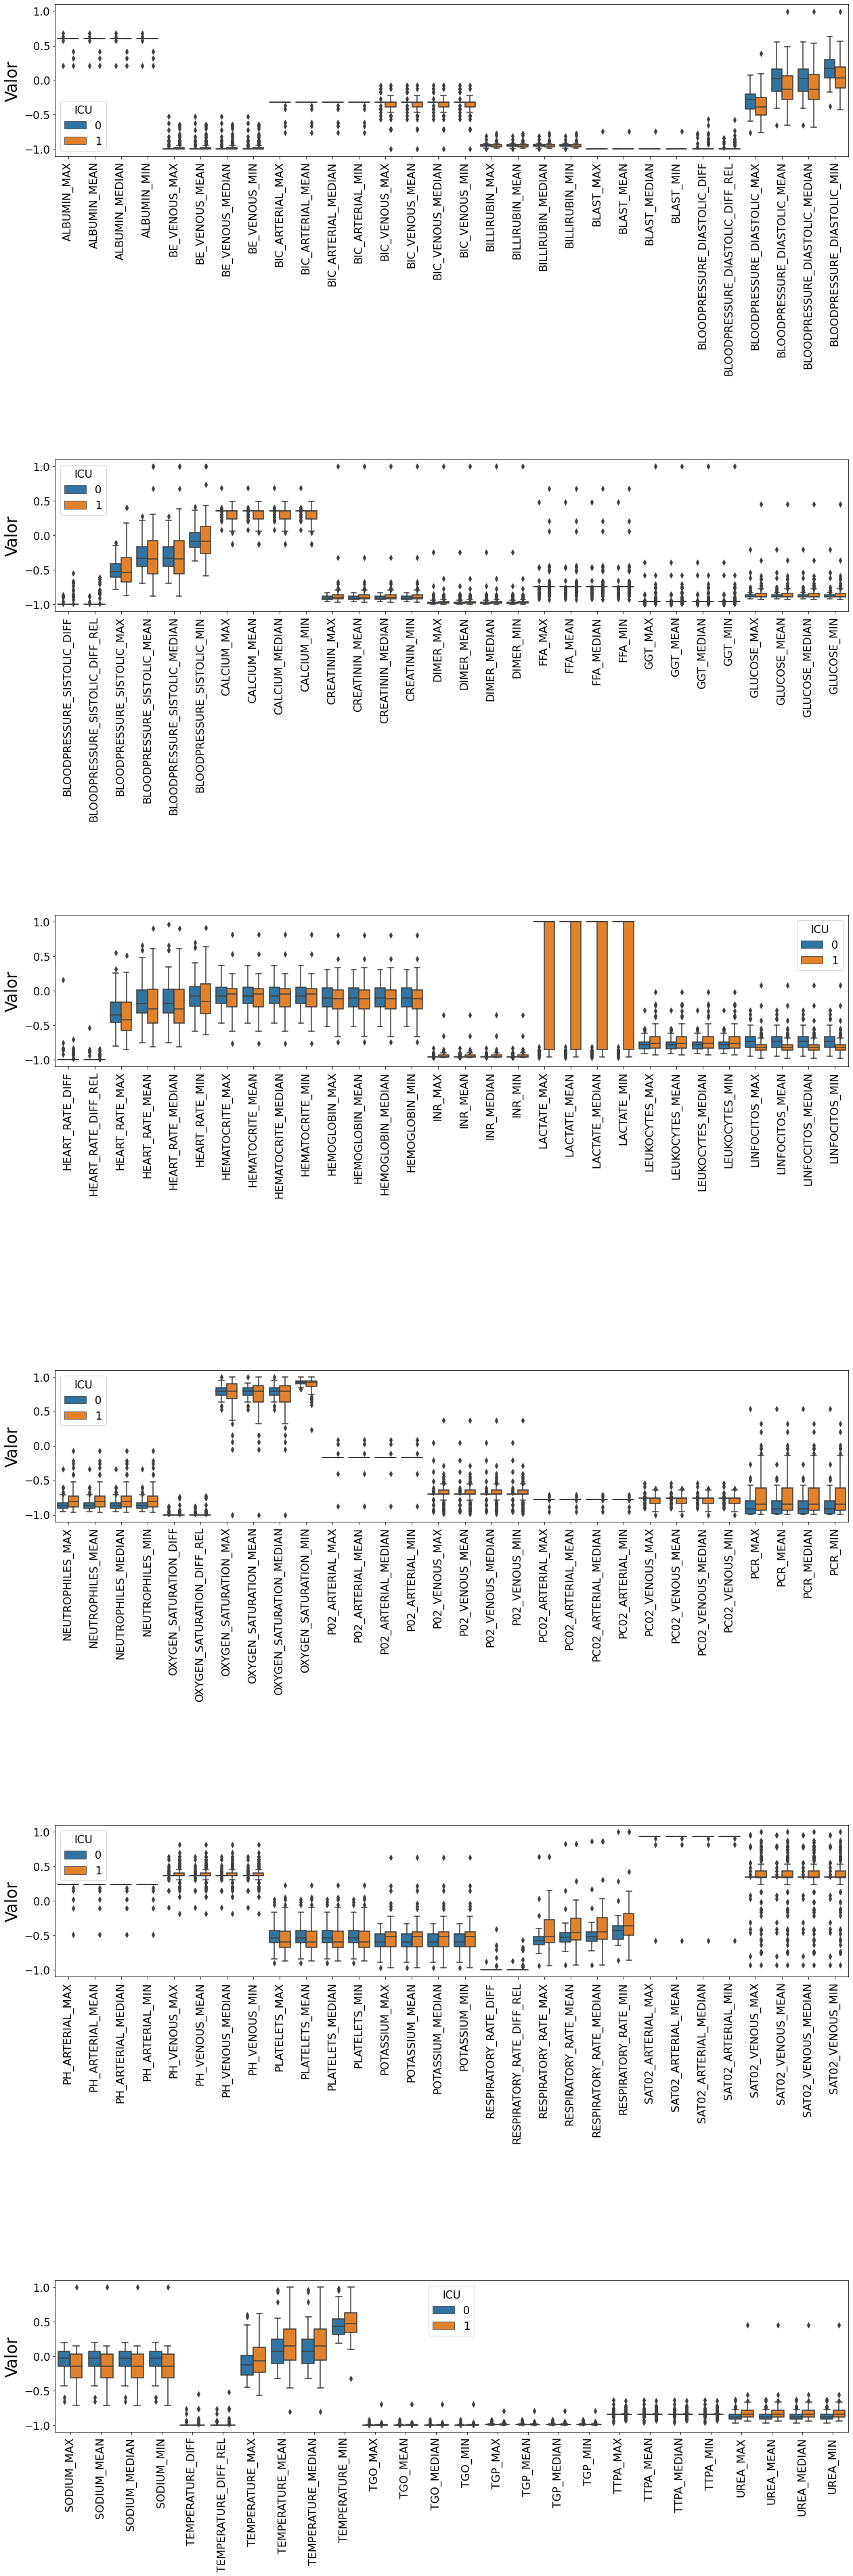

In [ ]:
# matriz_boxplots(df_pivot.rename_axis(index={'ICU_timeless':'ICU'}),yvar='ICU', janela='0-2', lista_de_variaveis=sorted(continuous_vars_std_uncorr))
# plt.subplots_adjust(wspace=0.1)

nrows_subplot = 6
comparacao_de_boxplots(df_pivot,features=continuous_vars_std_uncorr, janela='0-2', nrows=nrows_subplot)
# plt.savefig('./boxplot_vars_selecionadas.png', dpi=300, transparent=True, bbox_inches='tight')

#### **Variáveis Eliminadas por Alta Correlação**

Selecionando algumas das variáveis eliminadas por alta correlação, podemos notar que **todas apresentam medidas correspondentes no grupo de variáveis selecionadas**, assim como comportamentos muito parecidos.  

Isso sugere que a eliminição dessas variáveis apenas **reduziu redundâncias e complexidades do modelo**.

> <font color=#FF0000> **NOTA**: conforme mencionado na discussão anterior, **após muitos testes**, observou-se que os modelos conseguem fazer melhores previsões mantendo o maior número possível de variáveis, independente de serem fortemente correlacionadas. 
>
> Os resultados a seguir apenas ilustram a faixa de dispersão de algumas variáveis altamente correlacionadas, como ``'PCR_MAX'``, ``'PCR_MEAN'`` e ``'PCR_MEDIAN'``, por exemplo.</font>

In [ ]:
# observar e selecionar algumas para observar
# 
if len(drop_vars_set)>0:
  group_same_continous_vars(drop_vars_set)

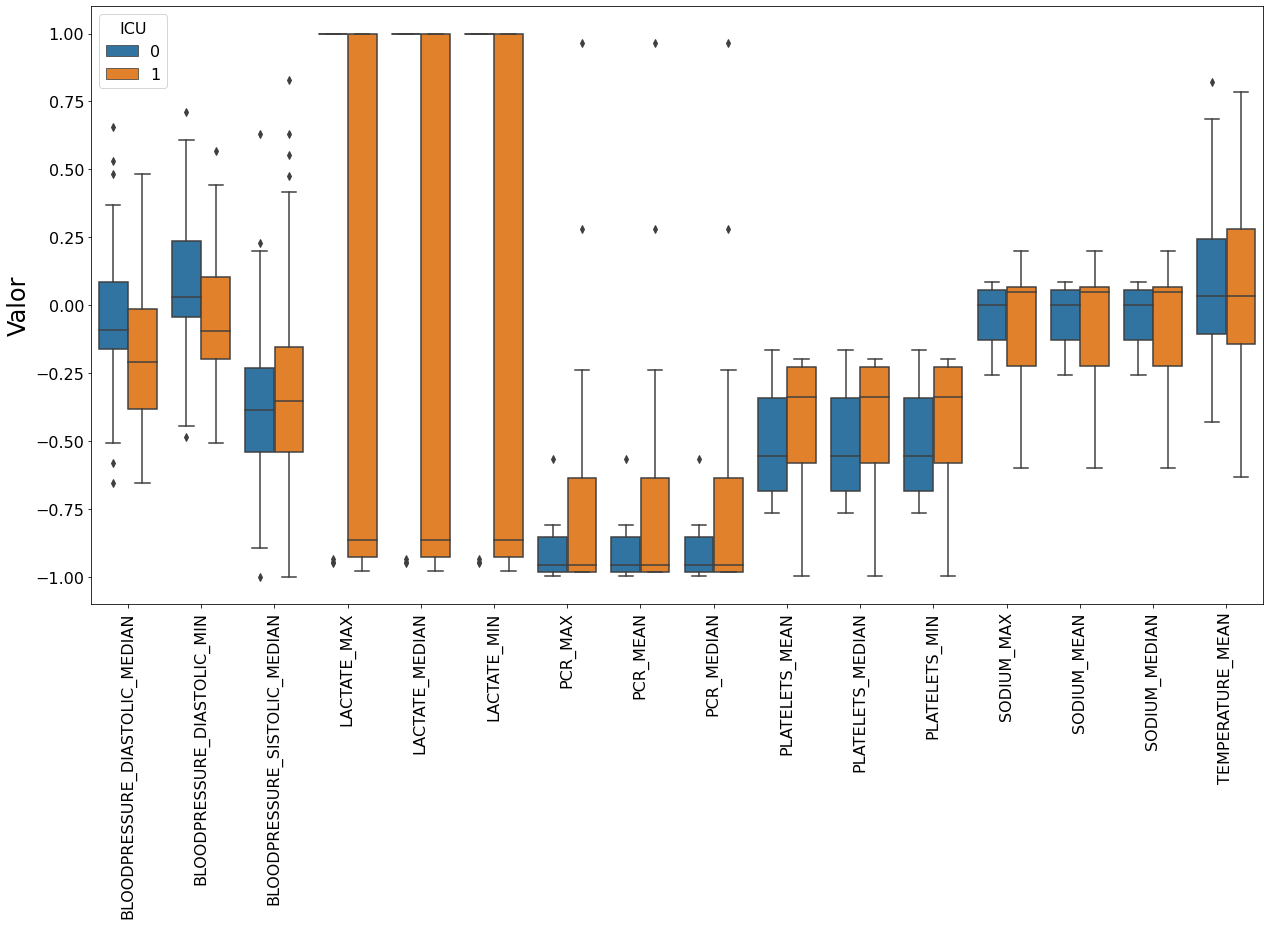

In [ ]:
vars_high_corr = ['BLOODPRESSURE_DIASTOLIC_MEDIAN','BLOODPRESSURE_DIASTOLIC_MIN','BLOODPRESSURE_SISTOLIC_MEDIAN',
                  'LACTATE_MAX','LACTATE_MIN','LACTATE_MEDIAN',
                  'PCR_MAX','PCR_MEAN','PCR_MEDIAN',
                  'PLATELETS_MEAN', 'PLATELETS_MEDIAN', 'PLATELETS_MIN',
                  'SODIUM_MAX', 'SODIUM_MEAN', 'SODIUM_MEDIAN',
                  'TEMPERATURE_MEAN']

# matriz_boxplots(df_pivot.rename_axis(index={'ICU_timeless':'ICU'}),yvar='ICU', janela='0-2', lista_de_variaveis=vars_high_corr)
# plt.subplots_adjust(wspace=0.1)

nrows_subplot = 1
comparacao_de_boxplots(df_pivot,features=vars_high_corr, janela='6-12', nrows=nrows_subplot, hspace=1)

#### **Variáveis Eliminadas por Baixa Dispersão**  

Observando algumas das variáveis removidas por apresentarem baixa dispersão na primeira janela, pode-se concluir que a medida está adequada.  

Mesmo aquelas que não apresentam variância nula ou quase nula **não demonstram uma grande diferença de comportamento entre os grupos ``ICU=1`` e ``ICU=0``**.

> <font color=#FF0000> **NOTA**: conforme mencionado na discussão anterior, **após muitos testes**, observou-se que os modelos conseguem fazer melhores previsões mantendo o maior número possível de variáveis, **mesmo quando a dispersão das variáveis na primeira janela é baixa**. </font>
>
> <font color=#FF0000>Portanto, os resultados abaixo, na lista ``vars_baixa_dispersao``, ilustram algumas variávies da saída de ``low_std_th=0.15``.</font>
>
> <font color=#339544>Note que nem todas são variáveis de dispersão nula!</font>

In [ ]:
# observar e selecionar algumas para observar
group_same_continous_vars(vars_to_drop)

OrderedDict([('ALBUMIN', ['DIFF']),
             ('BE ARTERIAL', ['DIFF', 'MAX', 'MEAN', 'MEDIAN', 'MIN']),
             ('BE VENOUS', ['DIFF']),
             ('BIC ARTERIAL', ['DIFF']),
             ('BIC VENOUS', ['DIFF']),
             ('BILLIRUBIN', ['DIFF']),
             ('BLAST', ['DIFF']),
             ('CALCIUM', ['DIFF']),
             ('CREATININ', ['DIFF']),
             ('DIMER', ['DIFF']),
             ('FFA', ['DIFF']),
             ('GGT', ['DIFF']),
             ('GLUCOSE', ['DIFF']),
             ('HEMATOCRITE', ['DIFF']),
             ('HEMOGLOBIN', ['DIFF']),
             ('INR', ['DIFF']),
             ('LACTATE', ['DIFF']),
             ('LEUKOCYTES', ['DIFF']),
             ('LINFOCITOS', ['DIFF']),
             ('NEUTROPHILES', ['DIFF']),
             ('P02 ARTERIAL', ['DIFF']),
             ('P02 VENOUS', ['DIFF']),
             ('PC02 ARTERIAL', ['DIFF']),
             ('PC02 VENOUS', ['DIFF']),
             ('PCR', ['DIFF']),
             ('PH ARTERIAL', ['DI

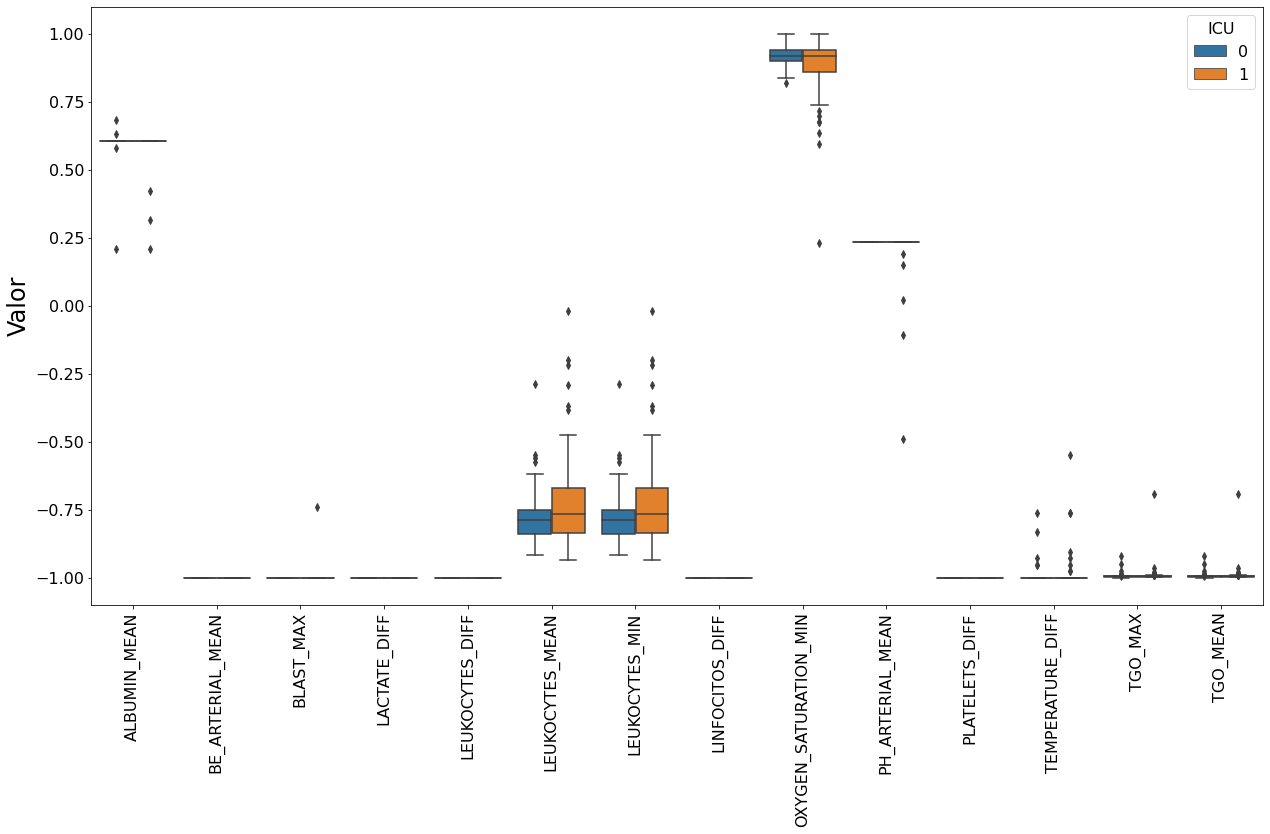

In [ ]:
vars_baixa_dispersao = ['ALBUMIN_MEAN','BE_ARTERIAL_MEAN','BLAST_MAX',
                        'LACTATE_DIFF','LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF',
                        'LEUKOCYTES_MEAN','LEUKOCYTES_MIN',
                        'PLATELETS_DIFF','PH_ARTERIAL_MEAN',
                        'TEMPERATURE_DIFF','TGO_MEAN','TGO_MAX','OXYGEN_SATURATION_MIN']
# matriz_boxplots(df_pivot.rename_axis(index={'ICU_timeless':'ICU'}),yvar='ICU', janela='0-2', lista_de_variaveis=vars_baixa_dispersao)
# plt.subplots_adjust(wspace=0.1)

nrows_subplot = 1
comparacao_de_boxplots(df_pivot,features=vars_baixa_dispersao, janela='0-2', nrows=nrows_subplot, hspace=1)

<a name="ML"></a>
# Modelo de Previsão de Internação
[(voltar para o sumário)](#toc2)



Usando todas as análise anteriores, vamos preparar o conjunto de dados para a escolha do modelo mais adequado de previsão de internações.  
Reforçando: **para fins de treino/teste só serão usados os dados da janela ``0-2``**.  

Para os pacientes que não foram internados em janelas posteriores, vamos aplicar os modelos nesses dados como forma de **validação**.  

**Resumo da Seção**

> <font color=#DB4455> **SPOILER ALERT**: </font>  
> - O **preenchimento de dados ausentes** é realizado com ``ffill`` seguido de um ``fillna`` baseado em valores aleatórios calculados sobre a distribuição das medidas dos pacientes que nunca são internados. O objetivo é não "vazar" nenhuma informação dos exames pacientes internados para as medidas ausentes do mesmo paciente nas janelas em que ele não está internado.
- Na **validação cruzada**, os _splits_ treino/teste são **estratificados de acordo com a janela de internação dos pacientes**. Analisam-se as métricas ``roc_auc``, ``f1``, ``precision`` e ``recall`` (as duas últimas correspondentes à classe 1).
- Apesar da seleção automática de _features_, **os melhores resultados ocorrem considerando todas as variáveis fortemente relacionadas e incluindo as variáveis de baixa dispersão** (são eliminadas apenas variáveis de dispersão nula na janela ``0-2``).
- Além do valor médio das métricas de desempenho correspondentes aos _splits_ de teste, os principais critérios para decisão do melhor modelo envolveram **escolher um modelo cujo intervalo de dispersão das métricas apresentasse os maiores valor mínimos**, com foco nas métricas f1 e recall.
- <font color=#448933>**O modelo com os melhores resultados na validação cruzada foi o ``RandomForestClassifier``**.</font>
- Após essa escolha do melhor modelo, os hiperparâmetros do ``RandomForestClassifier`` são otimizados com uma **busca em grade (dos hiperparâmetros) com validação cruzada**.
- A **análise de importância de features do ``RandomForestClassifier``** confirmou a análise exploratória quanto à idade dos pacientes. Entretanto, muitos exames de sangue que não foram destacados na análise exploratória dos dados mostram-se bastante relevantes na ordem de importância (``SAT_02``, ``LINFOCITOS``, ``INR``, etc.). Já as variáveis ``LACTATE_``, que pareciam determinantes de acordo com as conclusões preliminares da análise exploratória, não parecem tão relevantes assim no modelo final.
- Ao fim do trabalho, **elaborei uma metodologia para fazer uma validação dos resultados do modelo "acompanhando" a evolução dos pacientes**. Nessa parte, os **dados de validação** são as medições dos pacientes nas janelas que não foram usadas para o treino. Observou-se que  <font color=#448933>**o ``recall`` é satisfatório ao longo de todas as janelas**</font>, enquanto  <font color=#EA4433>**a ``precisão`` mostra um pouco de overfit na primeira janela e um aumento dos ``falsos positivos`` com o passar do tempo**</font>.

**Início**

As primeiras seções antes do treino correspondem ao tratamento dos dados transformando o dataset ``df`` no _dataset_ final de treino/teste, denominado ``df_ML``.

<a name="ML_preprocess"></a>
## Pré-processamento dos dados
[(voltar para o sumário)](#toc2)


### **REMOVENDO PACIENTES**

O primeiro passo é **descartar os pacientes que não podem ser usados para avaliação do modelo**. 

In [ ]:
# Veja os rótulos dos 32 pacientes que foram internados desde a primeira janela
print(df_pivot[df_pivot[('ICU','0-2')]==1]['ICU'].droplevel(1).to_markdown())

# DESCARTAR PACIENTES ICU=1 da janela 0-2
patients_to_drop = df_pivot[df_pivot[('ICU','0-2')]==1].droplevel(1).index
# print(patients_to_drop)

# OBSERVAR que fazemos os filtros sobre o DataFrame df, não df_pivot
df_ML_drop = df.set_index('PATIENT_VISIT_IDENTIFIER').drop(patients_to_drop).reset_index() 

|   PATIENT_VISIT_IDENTIFIER |   0-2 |   2-4 |   4-6 |   6-12 |   ABOVE_12 |
|---------------------------:|------:|------:|------:|-------:|-----------:|
|                          1 |     1 |     1 |     1 |      1 |          1 |
|                         17 |     1 |     1 |     1 |      1 |          1 |
|                         27 |     1 |     1 |     1 |      1 |          1 |
|                         41 |     1 |     1 |     1 |      1 |          1 |
|                         47 |     1 |     1 |     1 |      1 |          1 |
|                         48 |     1 |     1 |     1 |      1 |          1 |
|                         54 |     1 |     1 |     1 |      1 |          1 |
|                         62 |     1 |     1 |     1 |      1 |          1 |
|                         85 |     1 |     1 |     1 |      1 |          1 |
|                         90 |     1 |     1 |     1 |      1 |          1 |
|                        104 |     1 |     1 |     1 |      1 |          1 |

### **PREENCHENDO DADOS AUSENTES (``ffill`` e ``fillna``)**

O trecho de código abaixo mostra o percentual de linhas nulas do DataFrame original de acordo com cada uma das colunas.

In [ ]:
# ENUMERANDO QUANTIDADE DE LINHAS NULAS POR FEATURE
print(df0.isna().sum().mul(100/df0.shape[0]).reset_index().sort_values(by=[0,'index'],ascending=False).to_markdown())

|     | index                            |        0 |
|----:|:---------------------------------|---------:|
| 185 | UREA_MIN                         | 57.3506  |
| 183 | UREA_MEDIAN                      | 57.3506  |
| 184 | UREA_MEAN                        | 57.3506  |
| 186 | UREA_MAX                         | 57.3506  |
| 187 | UREA_DIFF                        | 57.3506  |
| 180 | TTPA_MIN                         | 57.3506  |
| 178 | TTPA_MEDIAN                      | 57.3506  |
| 179 | TTPA_MEAN                        | 57.3506  |
| 181 | TTPA_MAX                         | 57.3506  |
| 182 | TTPA_DIFF                        | 57.3506  |
| 175 | TGP_MIN                          | 57.3506  |
| 173 | TGP_MEDIAN                       | 57.3506  |
| 174 | TGP_MEAN                         | 57.3506  |
| 176 | TGP_MAX                          | 57.3506  |
| 177 | TGP_DIFF                         | 57.3506  |
| 170 | TGO_MIN                          | 57.3506  |
| 168 | TGO_MEDIAN          

Para completar as linhas ausentes do _DataFrame_, vamos utilizar a seguinte estratégia:
1. propagar para os dados ausentes do futuro as últimas medições válidas do passado ([método ``ffill``](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ffill.html))
2. quando não há dados anteriores para propagar, <font color=#137633>**preencher informações iniciais com um valor aleatório dentro da distribuição de pacientes que nunca são internados**</font>.  

**Lembrando que cada preenchimento é realizado agrupando os dados por paciente, com as janelas ordenadas.**

A estratégia **1.** dá preferência para o preenchimento de informações futuras a partir das janelas iniciais com medições válidas. Assim, mesmo quando um dado rotulado como ``ICU=1`` for propagado para o futuro, este paciente jamais voltará a ter o rótulo ``ICU=0`` (janelas que ainda podem ser usados para previsão e não sofrerão com vazamento de dados).

In [ ]:
def ffill_by_patient(df):
    '''Interpolação de missing-values (nan) com o método foward-fill. Os dados são interpolados por cada ID única de paciente.
    '''
    df_ffill_by_patient = df.groupby(patient_id_col).ffill()
    df_ffill_by_patient = pd.concat([df[patient_id_col], df_ffill_by_patient], join='outer',axis=1) # concatenation to recover id columns lost because of groupby
    return df_ffill_by_patient
    
df_ML_ffill = ffill_by_patient(df_ML_drop)
df_ML_ffill

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_timeless
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0,1
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0,1
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-

A estratégia **2.** foi uma alternativa para **evitar o uso de interpolação com ``bfill``**. Nesse caso, entendo que preencher os dados iniciais ausentes usando um valor aleatório sorteado dentro de uma distribuição Normal gerada com a média e desvio padrão dos pacientes ``ICU=0`` é uma forma conservadora de não vazar dados ``ICU=1`` para o passado e, de certa forma, dificulta a detecção de internação (**como se fosse um ruído substituindo os dados ausentes**).

In [ ]:
# HIPÓTESE: 
# :::: FFILL não faz mal porque nunca vai propagar dados do paciente ICU=1 para ICU=0
# :::: ainda assim, pode haver nans que precisariam de BFILL, mas aí se corre o risco de propagar medidas de ICU=1 para janelas onde ICU=0
# :::: em vez de BFILL, vou completar os dados NaN que não foram preenchidos com FFILL usando valores aleatórios usando média e desvio padrão das medidas de pacientes ICU=0
# :::: (assumindo dist gauss)

dict_media_std_ICU_0 = dict()
df_ffill_ICU_0 = df_ML_ffill[df_ML_ffill['ICU']==0]
for col in continuous_vars:
    media  = df_ffill_ICU_0[col].dropna().mean()
    desvio =  df_ffill_ICU_0[col].dropna().std()
    dict_media_std_ICU_0[col] = (media, desvio)

# EXEMPLO de como acessar (média, desvio) de uma variável
dict_media_std_ICU_0['PCR_MEAN']

(-0.8339354110788895, 0.2139212373926331)

In [ ]:
np.random.seed(SEED)                         # fixa semente dos números pseudo-aleatórios
df_ML_fillna_randn = df_ML_ffill.copy()      
for col in continuous_vars:
    media, desvio   = dict_media_std_ICU_0[col] # acessa a média e desvio padrão da variável de interesse (calculada apenas com dados de pacientes ICU_timeless=0)                        
    valor_aleatorio = np.clip( np.random.normal(media, desvio), -1, 1) # gera um número aleatório para essa medida, truncado no intervalo entre -1 e 1
    df_ML_fillna_randn[col] = df_ML_ffill.groupby(patient_id_col)[col].fillna( valor_aleatorio ) # preenche os valores ausentes que restaram com esse valor aleatório
# df_ML_fillna_randn

Mesmo após os passos anteriores, ainda existem valores ausentes.  
Porém, não são devido às variáveis contínuas, mas sim devido a falta de preenchimento de algumas variáveis categóricas.  
**Trata-se do paciente com ID $199$. Não há registro das suas doenças prévias.**

In [ ]:
# AINDA ASSIM, EXISTEM ALGUMAS LINHAS nan DEVIDO À AUSÊNCIA DA INFORMAÇÃO DE COMORBIDADES DO PACIENTE 199
df_ML_fillna_randn[df_ML_fillna_randn.isna().sum(axis=1)>0]
# [disease_groups]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_timeless
915,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495215,0.683375,0.603925,0.43286,-1.0,-0.99194,-0.982669,-0.971308,-0.983928,-1.0,-1.0,-0.92413,-0.938403,-0.879904,-1.0,-0.326085,-0.322271,-0.323195,-0.321262,-1.0,-0.237142,-0.373918,-0.290329,-0.20455,-1.0,-0.946623,-0.895396,...,-1.0,0.387055,-0.214824,-0.46926,-0.604008,0.240321,0.698117,-0.429707,-0.099616,-0.13738,-0.96946,0.34451,0.818632,-0.255188,-0.134233,-0.127494,-0.337665,0.186806,0.832215,-0.199208,-0.3481,-0.661861,-0.420532,-0.092336,0.861153,-0.650103,-0.653509,-0.686572,-0.881505,-0.806729,-1.0,-1.0,-0.986864,-0.838478,-0.921683,-0.503442,-1.0,0-2,0,0
916,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495215,0.683375,0.603925,0.43286,-1.0,-0.99194,-0.982669,-0.971308,-0.983928,-1.0,-1.0,-0.92413,-0.938403,-0.879904,-1.0,-0.326085,-0.322271,-0.323195,-0.321262,-1.0,-0.237142,-0.373918,-0.290329,-0.20455,-1.0,-0.946623,-0.895396,...,-1.0,0.387055,-0.214824,-0.46926,-0.604008,0.240321,0.698117,-0.429707,-0.099616,-0.13738,-0.96946,0.34451,0.818632,-0.255188,-0.134233,-0.127494,-0.337665,0.186806,0.832215,-0.199208,-0.3481,-0.661861,-0.420532,-0.092336,0.861153,-0.650103,-0.653509,-0.686572,-0.881505,-0.806729,-1.0,-1.0,-0.986864,-0.838478,-0.921683,-0.503442,-1.0,2-4,0,0
917,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495215,0.683375,0.603925,0.43286,-1.0,-0.99194,-0.982669,-0.971308,-0.983928,-1.0,-1.0,-0.92413,-0.938403,-0.879904,-1.0,-0.326085,-0.322271,-0.323195,-0.321262,-1.0,-0.237142,-0.373918,-0.290329,-0.20455,-1.0,-0.946623,-0.895396,...,-1.0,0.387055,-0.214824,-0.46926,-0.604008,0.240321,0.698117,-0.429707,-0.099616,-0.13738,-0.96946,0.34451,0.818632,-0.255188,-0.134233,-0.127494,-0.337665,0.186806,0.832215,-0.199208,-0.3481,-0.661861,-0.420532,-0.092336,0.861153,-0.650103,-0.653509,-0.686572,-0.881505,-0.806729,-1.0,-1.0,-0.986864,-0.838478,-0.921683,-0.503442,-1.0,4-6,0,0
918,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495215,0.683375,0.603925,0.43286,-1.0,-0.99194,-0.982669,-0.971308,-0.983928,-1.0,-1.0,-0.92413,-0.938403,-0.879904,-1.0,-0.326085,-0.322271,-0.323195,-0.321262,-1.0,-0.237142,-0.373918,-0.290329,-0.20455,-1.0,-0.946623,-0.895396,...,-1.0,0.387055,-0.214824,-0.46926,-0.604008,0.240321,0.698117,-0.429707,-0.099616,-0.13738,-0.96946,0.34451,0.818632,-0.255188,-0.134233,-0.127494,-0.337665,0.186806,0.832215,-0.199208,-0.3481,-0.661861,-0.420532,-0.092336,0.861153,-0.650103,-0.653509,-0.686572,-0.881505,-0.806729,-1.0,-1.0,-0.986864,-0.83847

**Como solução conservadora, em vez de descartá-lo, optei por indicar que esse paciente não possui nenhuma doença prévia.**  

In [ ]:
# SOLUÇÃO PROPOSTA: ASSUMIR QUE O PACIENTE 199 NÃO TEM NENHUMA COMORBIDADE DOS GRUPOS ANOTADOS
df_ML_fillna_randn[disease_groups] = df_ML_fillna_randn[disease_groups].fillna(0)

Agora não resta mais nenhum valor ausente no _DataFrame_.

In [ ]:
df_ML_fillna_randn[df_ML_fillna_randn.isna().sum(axis=1)>0]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_timeless


<a name="ML_stratify"></a>
## Variável de Estratificação
[(voltar para o sumário)](#toc2)


Antes de dividir o conjunto de dados para o treino, precisamos entender uma questão particular deste problema.  

Geralmente divisões de dados entre treino/teste consideram uma **estratificação** sobre a variável alvo, a fim de manter a distribuição de exemplos semelhante tanto na parcela usada no treino quanto na parcela usada no teste.  

Entretanto, no caso dos nosso pacientes, embora a variável ``ICU_timeless`` seja útil para rotular quais pacientes serão internados no futuro (a qualquer momento depois da janela `0-2`), ela **não carrega a informação de qual janela o paciente foi internado**.  

A preocupação aqui diz respeito à seguinte situação: imagine que ao estratificar apenas com o rótulo ``ICU_timeless``, a maioria dos pacientes internados do conjunto de treino seja de pacientes internados na janela ``2-4``, ou seja, que já estavam num estado mais próximo da internação. Ao mesmo tempo, a maior parte dos pacientes que vão ser internados apenas nas janelas ``ABOVE_12`` ficaram de fora do treinamento. Portanto, existe uma chance que os dados desses pacientes durante a janela ``0-2``, o modelo não tenha aprendido o suficiente para classificá-los como casos de internação.  

Para não criar esse tipo de situação, optei por **criar uma nova variável categórica (``WINDOW_CAT_LABEL``) indicando em qual janela de observação o paciente foi internado**. Essa variável pode assumir os seguintes valores:
- $0$: o paciente nunca é internado
- $1$: o paciente é internado na janela `2-4`
- $2$: o paciente é internado na janela `4-6`
- $3$: o paciente é internado na janela `6-12`
- $4$: o paciente é internado na janela `ABOVE_12`.

A intenção é **estratificar os dados de treino/teste de acordo com essa nova variável, garantindo que a distribuição dos pacientes `ICU_timeless=1` em relação às janelas de internação seja respeitada**. Assim, sempre vamos ter exemplos de casos mais avançados e casos que ainda não estão próximos da janela de internação, tanto no treino quanto nos testes.

In [ ]:
# transforma as strings das janelas em categorias representadas por números inteiros  {'0-2', '2-4', '4-6', '6-12', 'ABOVE_12'} --> {0,1,2,3,4}
df_ML_fillna_randn['WINDOW_CAT'] = df_ML_fillna_randn['WINDOW'].astype('category').cat.codes
# agrupa por (ID do paciente, ICU no instante da janela)
# seleciona a coluna com os valores categóricos das janelas e extrai o valor máximo
# filtra todos os pacientes apenas pelo instante de ICU=0 (retornando o número da última janela em que o paciente estava com ICU=0)
paciente_ultima_janela_ICU_0 = df_ML_fillna_randn.groupby(['PATIENT_VISIT_IDENTIFIER','ICU'])['WINDOW_CAT'].max().loc[(slice(None),0)]
# se a última janela que o paciente estava ICU=0 tem o código 0, esse paciente vai pra ICU na janela '2-4'
# ...
# se a última janela que o paciente estava ICU=0 tem o código 4, esse paciente nunca foi pra ICU
# então transformamos os códigos usando um código de permutação: 0->1, 1->2, 2->3, 3->4 e 4->0
ICU_1_WINDOW_by_patient      = paciente_ultima_janela_ICU_0.apply(lambda x: (x+1) % 5)
ICU_1_WINDOW_by_patient      = ICU_1_WINDOW_by_patient.rename('ICU_1_WINDOW')
WINDOW_CAT_LABEL             = ICU_1_WINDOW_by_patient.copy()

Observe agora que usando ``WINDOW_CAT_LABEL==i``, onde $i\in \left\lbrace 0, 1, 2, 3, 4 \right\rbrace$, **conseguimos filtrar os pacientes que foram internados na janela de interesse**, conforme o código apresentado anteriormente.  

Abaixo veja um exemplo com uma amostra de cada tipo de paciente.  


In [ ]:
df_sample=pd.DataFrame()
for i in range(5):
  df_sample_i = df_pivot.loc[WINDOW_CAT_LABEL[WINDOW_CAT_LABEL==i].index]['ICU'].sample(1).droplevel(1)
  df_sample=pd.concat([df_sample, df_sample_i])
print(df_sample.to_markdown())

|   PATIENT_VISIT_IDENTIFIER |   0-2 |   2-4 |   4-6 |   6-12 |   ABOVE_12 |
|---------------------------:|------:|------:|------:|-------:|-----------:|
|                        110 |     0 |     0 |     0 |      0 |          0 |
|                         82 |     0 |     1 |     1 |      1 |          1 |
|                        164 |     0 |     0 |     1 |      1 |          1 |
|                         89 |     0 |     0 |     0 |      1 |          1 |
|                        309 |     0 |     0 |     0 |      0 |          1 |


Agora que temos essa variável para cada paciente, podemos incluí-la no _dataset_ e **usá-la como referência de estratificação para as divisões treino/teste**.  

Tanto nos dados de treino quanto nos dados de teste, a proporção esperada do % de pacientes internados em cada janela deve se manter semelhante aos percentuais mostrados na Tabela abaixo (e ilustrados na Figura a seguir).

In [ ]:
dist_abs = WINDOW_CAT_LABEL.value_counts(sort=False).rename_axis(index='janela ICU=1').rename('# pacientes')
dist_rel = WINDOW_CAT_LABEL[WINDOW_CAT_LABEL>0].value_counts(sort=False,normalize=True).mul(100).round(2).rename_axis(index='janela ICU=1').rename('% pacientes internados')
print(pd.concat([dist_abs,dist_rel],axis=1).to_markdown())

|   janela ICU=1 |   # pacientes |   % pacientes internados |
|---------------:|--------------:|-------------------------:|
|              0 |           190 |                   nan    |
|              1 |            27 |                    16.56 |
|              2 |            40 |                    24.54 |
|              3 |            31 |                    19.02 |
|              4 |            65 |                    39.88 |


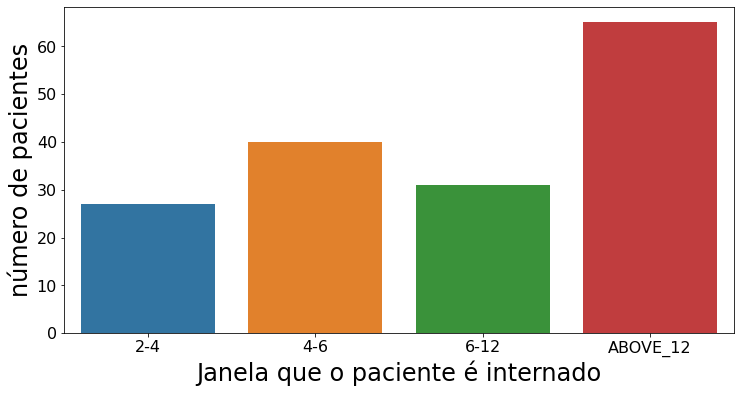

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=WINDOW_CAT_LABEL[WINDOW_CAT_LABEL>0].replace({i:lista_de_janelas[i] for i in range(1,5)}).reset_index(), 
              x=WINDOW_CAT_LABEL.name, order=lista_de_janelas[1:])
plt.xlabel('Janela que o paciente é internado')
plt.ylabel('número de pacientes');

## **Ajuste Manual das Features Selecionadas**  

>
> <font color=#888888>Antes de prosseguir, optei por substituir manualmente algumas das medidas selecionadas.  
Isso se aplica para os casos de variáveis contínuas fortemente correlacionadas (exemplo: média, mediana e valor máximo de um mesmo exame).</font>
>
> <font color=#888888>Não sei dizer ao certo qual é a melhor estatística para ser usada em cada uma delas, mas do ponto de vista matemático, talvez o valor médio (``MEAN``) seja mais adequado e mais fácil de ser calculado em medições consecutivas do que os demais, principalmente em medições de tempo real. </font>
>
> <font color=#888888>Para exemplicar o raciocínio, imagine o valor médio de batimentos cardíacos. É possível atualizar o valor médio da série passada inteira recursivamente a cada nova amostra coletada. Já para a mediana, eu não sei dizer se o algoritmo de atualização é tão simples assim (pode ser desconhecimento meu). Por outro lado, valores mínimos e máximos são facilmente atualizados comparando o atual com a nova mostra; entretanto, são muito sensíveis a ruídos e outliers!</font>
>
><font color=#888888>**Portanto, optei por substituir variáveis únicas dos grupos fortemente correlacionados que haviam sido seleciadas como ``MEDIAN``, ``MAX`` ou ``MIN`` pelo seu correspondente ``MEAN``.**</font>

<font color=#DC4444>**NOTA**: o procedimento acima havia sido realizado quando ``low_std_th=0.15`` e ``high_corr_th: 0.75``, o que resultava em apenas $26$ variáveis. </font>
 
<font color=#4444DC> Conforme as observações anteriores, ao mudar para ``low_std_th=0.0`` e ``high_corr_th: 1.0``, as variáveis fortanto correlacionadas não são eliminadas. Logo, torna-se desnecessário realizar essa substituição manual (e seria mais trabalhoso, necessitando de uma função, pois agora são $176$ _features_.</font> 

No código abaixo, deixei o ajuste manual comentado, mantendo a seleção automática.  

Caso rode o notebook com ``high_corr_th``$<1$, vai funcionar normalmente, com a única diferença que **algumas medidas** ficarão com seus valores ``_MAX``, ``_MIN``, ``_MEDIAN`` ou ``_DIFF`` em vez de ``_MEAN``.

In [ ]:
# low_std_th=0.15 e high_corr_th: 0.75
# # AJUSTE MANUAL: DAS VARIÁVEIS FORTEMENTE CORRELACIONADAS, SUBSTITUÍ {MEDIAN, MAX OU MIN} POR {MEAN}
# continuous_vars_std_uncorr_manual =[
#  'BLOODPRESSURE_DIASTOLIC_MEAN', # substitui 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
#  'BLOODPRESSURE_DIASTOLIC_MIN',
#  'BLOODPRESSURE_SISTOLIC_MAX',
#  'BLOODPRESSURE_SISTOLIC_MEAN',
#  'HEART_RATE_MAX',
#  'HEART_RATE_MEAN', # substitui 'HEART_RATE_MEDIAN',
#  'HEART_RATE_MIN',
#  'HEMOGLOBIN_MEAN', # substitui 'HEMOGLOBIN_MAX',
#  'LACTATE_MEAN', # substitui 'LACTATE_MEDIAN',
#  'OTHER',
#  'OXYGEN_SATURATION_MAX',
#  'OXYGEN_SATURATION_MEAN', # substitui 'OXYGEN_SATURATION_MEDIAN',
#  'PCR_MEAN',
#  'RESPIRATORY_RATE_MAX',
#  'RESPIRATORY_RATE_MEAN', # substitui 'RESPIRATORY_RATE_MEDIAN',
#  'RESPIRATORY_RATE_MIN',
#  'SAT02_VENOUS_MEAN', # substitui 'SAT02_VENOUS_MAX',
#  'SODIUM_MEAN', # substitui 'SODIUM_MEDIAN',
#  'TEMPERATURE_MAX',
#  'TEMPERATURE_MEAN', # substitui 'TEMPERATURE_MEDIAN',
#  'TEMPERATURE_MIN']

# SEM AJUSTE MANUAL
continuous_vars_std_uncorr_manual = list(continuous_vars_std_uncorr)

# SE DESEJAR FAZER AJUSTES MANUAIS NAS VARIÁVEIS CATEGÓRICAS, COMENTE UMA LINHA DA LISTA
categorical_vars_manual = [ 
'AGE_ABOVE65',
'AGE_PERCENTIL',
'GENDER',
'DISEASE GROUPING 1',
'DISEASE GROUPING 2',
'DISEASE GROUPING 3',
'DISEASE GROUPING 4',
'DISEASE GROUPING 5',
'DISEASE GROUPING 6',
'HTN',
'IMMUNOCOMPROMISED'
]

rotulos = ['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU','ICU_timeless'] 
# OBS: 
# - no df original, não foi incluída WINDOW_CAT_LABEL
# - no df_pivot, WINDOW de df não existe mais, então WINDOW_CAT_LABEL será renomeada para WINDOW

## BIFROST: momento iterativo do caderno

Aqui é o momento onde foi necessário realizar diversos testes para confirmar os resultados finais.  

Neste ponto, você deve:
1. optar pela seleção de features desejada
2. realizar o treino e validação cruzada dos modelos
3. avaliar o desempenho comparando modelos e métricas
4. treinar os modelos com todos os dados disponíveis
5. validar os modelos com dados de janelas após ``'0-2'``.

Ao fim do processo, chega-se a conclusão da melhor estratégia que deve ser adotada para atingir o objetivo proposto (melhor _call-to action_).  

**A versão final deste caderno está utilizando a solução que foi julgada mais adequada para o problema.**  

Sinta-se livre para reproduzir os resultados trocando entre as opções disponíveis ou manipulando o caderno à sua maneira.

In [ ]:
#@title PARAMETRIZANDO A SEÇÃO DE TREINO/TESTE

#@markdown <font color=#993333>_**OBS:** após selecionar novos valores é necessário **rodar a célula novamente.**_
_

#@markdown Defina o método seleção das features
feature_selection_method = "1. Automatic" #@param ["1. Automatic", "2. TODAS AS FEATURES", "3. Override Manual"]

class_weight_opt = 'none' #@param ['none', "balanced", "custom"]

#@markdown Defina a importância dos erros da classe 1 (será usado no ``class_weight`` se ``class_weight_opt=="custom"``):
w1 = 0.6 #@param {type:"slider", min:0, max:1, step:0.01}

#@markdown Das opções abaixo, selecione os modelos que você deseja avaliar.
use_LogisticRegression = True #@param {type:"boolean"}
use_GaussianNB = False #@param {type:"boolean"}
use_SVC = True #@param {type:"boolean"}
use_LinearSVC = False #@param {type:"boolean"}
use_DecisionTreeClassifier = True #@param {type:"boolean"}
use_RandomForestClassifier = True #@param {type:"boolean"}

In [ ]:
switch_var = feature_selection_method.split(' ')[0]

# FEATURES OPÇÃO 1: USAR SELEÇÃO AUTOMÁTICA QUE REMOVEU VARIÁVEIS POR BAIXA DISPERSÃO E ALTA CORRELAÇÃO
if switch_var=="1.":
  cat_vars_train        = categorical_vars_manual
  cont_vars_train       = continuous_vars_std_uncorr_manual

# FEATURES OPÇÃO 2: USAR TODAS AS FEATURES DISPONÍVEIS NO DATASET
elif switch_var=="2.":
  cat_vars_train        = categorical_vars
  cont_vars_train       = continuous_vars

# FEATURES OPÇÃO 3: OVERRIDE MANUAL (CRIE SUAS LISTAS PERSONALIZADAS DE FEATURES CONTINUAS E CATEGORICAS)
elif switch_var=="3.":
  continuous_vars_override =[
 'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
 'BLOODPRESSURE_SISTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MEAN',
 'HEART_RATE_MAX','HEART_RATE_MEAN', 'HEART_RATE_MIN',
 'OXYGEN_SATURATION_MAX', 'OXYGEN_SATURATION_MEAN', 
 'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MIN',
 'TEMPERATURE_MAX', 'TEMPERATURE_MEAN', 'TEMPERATURE_MIN',
 'LACTATE_MEAN', 'LACTATE_MAX', 'LACTATE_MIN', 'LACTATE_MEDIAN', 'LACTATE_DIFF']

  categorical_vars_override = [ 
  'AGE_ABOVE65', 'GENDER', 'HTN', 'DISEASE GROUPING 4']

  cat_vars_train        = categorical_vars_override
  cont_vars_train       = continuous_vars_override

# NÃO ALTERAR DAQUI PRA BAIXO
features_selecionadas = rotulos + cat_vars_train + cont_vars_train

# OPÇÃO DE PESOS DE CLASSE "balanced": modelos ajustam pesos de forma inversamente proporiconal à freq. da classe
if class_weight_opt=='balanced':
  class_weight = class_weight_opt

# OPÇÃO DE PESOS DE CLASSE "custom": dicionário de pesos, sendo w1 o peso da classe 1 e (1-w1) o peso da classe 0
elif class_weight_opt=="custom":
  class_weight =  dict({0:1-w1, 1: w1})

# OPÇÃO DE PESOS DE CLASSE "none": classes terão pesos idênticos
else:
  class_weight = None

Com base na seleção de features adotada, o código a seguir vai:
- filtrar as features selecionadas da última versão pré-processada no _DataFrame_
- transformar para o formato ``pivot`` a fim de ter um paciente por linha, com todas as informações disponíveis
- anexar a coluna que indica em qual janela o paciente é internado
- converter a variável ``AGE_PERCENTIL`` (se estiver presente) para categorias binárias com o ``pd.get_dummies()``
- eliminar colunas duplicadas das variáveis categóricas (efeito colateral do ``pivot`` da coluna ``WINDOW``)
- obter ``X``e ``Y`` apenas com inforamações disponíveis na primeira janela ``0-2``.

In [ ]:
# FILTRANDO FEATURES SELECIONADAS
df_ML = df_ML_fillna_randn[features_selecionadas]

# PIVOT DA COLUNA DE JANELAS
df_ML_pivot = df_ML.pivot(index=[patient_id_col,'ICU_timeless'], columns=[window_id_col])

# ANEXANDO A COLUNA WINDOW_CAT_LABEL PARA ESTRATIFICAÇÃO ADEQUADA DOS DADOS
WINDOW_CAT_LABEL_MultiIndex = WINDOW_CAT_LABEL.copy()
WINDOW_CAT_LABEL_MultiIndex.index = zip(WINDOW_CAT_LABEL_MultiIndex.index.tolist(),df_ML_pivot.index.get_level_values(1))
df_ML_pivot[('WINDOW','')] = WINDOW_CAT_LABEL_MultiIndex
df_ML_pivot = df_ML_pivot.reset_index().set_index('PATIENT_VISIT_IDENTIFIER')

# SANITY CHECKS
# df_ML_pivot
# df_ML_pivot[categorical_vars_manual]
# print(*df_ML_pivot.columns.tolist(),sep='\n')

# CONVERSÃO DE VARIÁVEIS CATEGÓRICAS PARA DUMMIES BINARIZADAS
cat_col = 'AGE_PERCENTIL'
if cat_col in cat_vars_train:
  dummies = pd.get_dummies(df_ML_pivot[(cat_col,'0-2')])
  dummies.columns = [(cat_col,i) for i in dummies.columns] # cria lista de colunas (AGE_PERCENTIL, 10th), ... , (AGE_PERCENTIL, Above 90th)
  df_ML_pivot = pd.concat([df_ML_pivot,dummies],axis=1)


# CONJUNTO DE TREINO/TESTE

# ELIMINA DUPLICATAS DOS DADOS CATEGÓRICOS DOS PACIENTES (geradas por causa do pivot sobre 'WINDOW')
for cat_col in cat_vars_train:
    if cat_col!='AGE_PERCENTIL':
      df_ML_pivot[(cat_col,'dummy')] = df_ML_pivot[(cat_col,'0-2')]
    cat_cols_to_drop = [(cat_col,lista_de_janelas[i]) for i in range(0, len(lista_de_janelas))] # 
    df_ML_pivot = df_ML_pivot.drop(cat_cols_to_drop,axis=1)

# SELEÇÃO DE COLUNAS CUJO MULTIINDEX LEVEL 1 NÃO CORRESPONDE ÀS JANELAS ('2-4' EM DIANTE)
cols_to_select_train_test = sorted([(x,y) for x, y in df_ML_pivot.columns.tolist() if y not in lista_de_janelas[1:]])

# ENTRADA DO MODELO (PD DATAFRAME)
X = df_ML_pivot[cols_to_select_train_test].reset_index().drop(rotulos,axis=1)
print('COLUNAS SELECIONADAS PARA X:', *X.columns.tolist(),sep='\n -- ')

# SAÍDA DO MODELO (y1) (PD SERIES)
Y = df_ML_pivot[['WINDOW','ICU_timeless']].droplevel(1,axis=1)
y1 = Y['ICU_timeless'] # VARIÁVEL ALVO: RÓTULO BINÁRIO DE INTERNAÇÃO
y2 = Y['WINDOW']       # VARIÁVEL DE ESTRATIFICAÇÃO: NÚM. DA JANELA NA QUAL O PACIENTE É INTERNADO

COLUNAS SELECIONADAS PARA X:
 -- ('AGE_ABOVE65', 'dummy')
 -- ('AGE_PERCENTIL', '10th')
 -- ('AGE_PERCENTIL', '20th')
 -- ('AGE_PERCENTIL', '30th')
 -- ('AGE_PERCENTIL', '40th')
 -- ('AGE_PERCENTIL', '50th')
 -- ('AGE_PERCENTIL', '60th')
 -- ('AGE_PERCENTIL', '70th')
 -- ('AGE_PERCENTIL', '80th')
 -- ('AGE_PERCENTIL', '90th')
 -- ('AGE_PERCENTIL', 'Above 90th')
 -- ('ALBUMIN_MAX', '0-2')
 -- ('ALBUMIN_MEAN', '0-2')
 -- ('ALBUMIN_MEDIAN', '0-2')
 -- ('ALBUMIN_MIN', '0-2')
 -- ('BE_VENOUS_MAX', '0-2')
 -- ('BE_VENOUS_MEAN', '0-2')
 -- ('BE_VENOUS_MEDIAN', '0-2')
 -- ('BE_VENOUS_MIN', '0-2')
 -- ('BIC_ARTERIAL_MAX', '0-2')
 -- ('BIC_ARTERIAL_MEAN', '0-2')
 -- ('BIC_ARTERIAL_MEDIAN', '0-2')
 -- ('BIC_ARTERIAL_MIN', '0-2')
 -- ('BIC_VENOUS_MAX', '0-2')
 -- ('BIC_VENOUS_MEAN', '0-2')
 -- ('BIC_VENOUS_MEDIAN', '0-2')
 -- ('BIC_VENOUS_MIN', '0-2')
 -- ('BILLIRUBIN_MAX', '0-2')
 -- ('BILLIRUBIN_MEAN', '0-2')
 -- ('BILLIRUBIN_MEDIAN', '0-2')
 -- ('BILLIRUBIN_MIN', '0-2')
 -- ('BLAST_MAX', '0-2')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3889: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



### Conjunto de Validação

Devido à natureza do problema, existe uma parcela de dados que não pode ser usada para treinar o modelo.  

Entretanto, podemos usar essas informações para criar um **conjunto de dados de validação**, ou seja, uma parcela dos dados que nunca será usada no treino, nem mesmo durante testes de validação cruzada.

Existem **três janelas de exames e sinais vitais dos pacientes que podem ser usadas como conjunto de validação**: ``2-4``, ``4-6`` e ``6-12``.  

Cada uma dessas janelas pode ser usada como validação **usando dados de pacientes que só serão internados nas janelas posteriores** (ou que nunca serão internados).  

No código abaixo, usa-se a informação da **janela de internação** do paciente para montar o conjunto de validação conforme as regras a seguir.

Janela de internação categoria $2$ (``4-6``):
- usa os dados de exames e sinais vitais da janela ``2-4``
- ``X`` e ``y`` incluem pacientes que são internados nas janelas ``4-6``, ``6-12`` ou ``ABOVE_12``
- ``X`` e ``y`` incluemtodos os pacientes que nunca foram internados

Janela de internação categoria $3$ (``6-12``):
- usa os dados de exames e sinais vitais da janela ``4-6``
- ``X`` e ``y`` incluem pacientes que são internados nas janelas ``6-12`` ou ``ABOVE_12``
- ``X`` e ``y`` incluem todos os pacientes que nunca foram internados

Janela de internação categoria $4$ (``ABOVE_12``):
- usa os dados de exames e sinais vitais da janela ``6-12``
- ``X`` e ``y`` incluem pacientes que são internados nas janelas ``ABOVE_12``
- ``X`` e ``y`` incluem todos os pacientes que nunca foram internados

Por fim, tudo é empilhado num único dataset com repetição de pacientes (repetições correspondem ao mesmo paciente em janelas diferentes). As features são idênticas as que serão usadas para treino/teste.

In [ ]:
# CONJUNTO DE VALIDAÇÃO 

X_val = pd.DataFrame([])
Y_val = pd.DataFrame([])

for i, janela_internacao in enumerate(range(2,5)):
  cols_to_select_val = sorted([(x,y) for x, y in df_ML_pivot.columns.tolist() if y not in lista_de_janelas[:janela_internacao-1]+lista_de_janelas[janela_internacao:]])
  
  df_temp_Y = df_ML_pivot[['WINDOW','ICU_timeless']].droplevel(1,axis=1)
  df_temp_Y = df_temp_Y.query(f'WINDOW in {[0] + list(range(janela_internacao,5))}') # entram pacientes WINDOW={0, i, i+1, i+2, ..., N} (no caso, N=4 e i muda de 2 até 4)
  df_temp_X = df_ML_pivot[cols_to_select_val].loc[df_temp_Y.index].reset_index().drop(rotulos,axis=1)
  
  print(df_temp_X.shape, df_temp_Y.shape, df_temp_Y['ICU_timeless'].sum())
  
  if i==0:
    X_val = df_temp_X.droplevel(1,axis=1)
    Y_val = df_temp_Y
  else:
    X_val = pd.concat([X_val, df_temp_X.droplevel(1,axis=1)])
    Y_val = pd.concat([Y_val, df_temp_Y])
  # print(f'COLUNAS SELECIONADAS PARA X_val (janela intern. {janela_internacao} ({lista_de_janelas[janela_internacao]})):', *cols_to_select_val,sep='\n -- ')

y1_val = Y_val['ICU_timeless'] # VARIÁVEL ALVO: RÓTULO BINÁRIO DE INTERNAÇÃO
y2_val = Y_val['WINDOW']       # VARIÁVEL DE ESTRATIFICAÇÃO: NÚM. DA JANELA NA QUAL O PACIENTE É INTERNADO

(326, 196) (326, 2) 136
(286, 196) (286, 2) 96
(255, 196) (255, 2) 65


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3889: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Idealmente, o algoritmo não deveria fazer previsões diferentes para o mesmo paciente. Mas também espera-se que o algoritmo tenha uma chance de acertar novamente caso tenha errado na primeira janela, ao menos com os pacientes que demoram mais pra ser internados.  

Durante os testes de validação cruzada, vamos usar o conjunto de validação para ter uma noção geral de como o os modelos se comportam com esses dados que não entram no treino. Ao fim do caderno, vamos usar a validação para acompanhar as previsões do modelo durante a trajetória de observação dos pacientes.

<a name="ML_train_split"></a>
### Treino e Previsão na Primeira Janela
[(voltar para o sumário)](#toc2)


No código abaixo, os modelos selecionados na BIFROST são armazenados em um **dicionário de modelos**.  

<font color=#BB3344>**OBS.:** infelizmente eu não implementei nenhuma otimização de hiperparâmetros nessa parte, então é necessário sempre atualizar os parâmetros aqui diretamente.</font>

In [ ]:
# INSTANCIAS DOS MODELOS A TESTAR
modelos = dict()
if use_LogisticRegression:
  modelos['LogisticRegression'] = LogisticRegression(class_weight=class_weight, solver='liblinear', penalty='l2', 
                                                     tol=0.0001, C=1.0, intercept_scaling=1, max_iter=100, fit_intercept=True,
                                                     dual=False,  multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None,random_state=SEED)
if use_GaussianNB:
  modelos['GaussianNB'] = GaussianNB()
if use_SVC:
  modelos['SVC'] = SVC(class_weight=class_weight, C=1.0, kernel='rbf', degree=3, 
                       gamma='scale', coef0=0.0, shrinking=True, probability=False, 
                       tol=0.001, cache_size=200,  verbose=False, decision_function_shape='ovr', break_ties=False,
                       max_iter=-1, random_state=SEED)
if use_LinearSVC:
  modelos['LinearSVC'] = LinearSVC(class_weight=class_weight, penalty='l2', loss='squared_hinge', 
                                   dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, 
                                   intercept_scaling=1, verbose=0, max_iter=5000, random_state=SEED)
if use_DecisionTreeClassifier:
  modelos['DecisionTreeClassifier'] = DecisionTreeClassifier(class_weight=class_weight, criterion='gini', splitter='best', 
                                                             max_depth=6, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                                             max_features=None,  max_leaf_nodes=None, 
                                                             min_impurity_decrease=0.0, min_impurity_split=None, 
                                                             ccp_alpha=0.0, random_state=SEED)
if use_RandomForestClassifier:
  modelos['RandomForestClassifier'] = RandomForestClassifier(class_weight=class_weight, criterion='gini', 
                                                 n_estimators=100, max_depth=8, 
                                                 min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                                                 max_features='auto', min_impurity_decrease=0.0, min_impurity_split=None, 
                                                 bootstrap=True, oob_score=False, n_jobs=None,  verbose=0, warm_start=False, 
                                                 ccp_alpha=0.0, max_samples=None, random_state=SEED,)

#### Validação Cruzada

Modelos de aprendizagem de máquina aprendem através dos dados fornecidos no treino. Para ter uma ideia de como será seu desempenho em produção, é comum realizarmos um procedimento de **validação cruzada**.  

Basicamente, dividimos os dados disponívels em 2 "pedaços" (_splits_): treino e teste, seguindo uma proporção arbitrária para o tamanho de cada _split_. 

Entretanto, não é só o tamanho dos _splits_ que influencia.  
Se não tomarmos cuidado, podemos acabar separando os exemplos mais fáceis para o treino, e os mais difíceis para o teste. O contrário também é verdade. Portanto, é importante realizar diversas **permutações dos dados entre os _splits_ de treino e teste**, buscando entender o **comportamento médio e a dispersão** das métricas de interesse nos dados de teste.  

Esse é o papel da validação cruzada, como se fosse uma "simulação" do modelo em produção.

Optei por utilizar o ``StratifiedShuffleSplit``, pois além de embaralhar o modelo, permite gerar separações que tentam manter a mesma distribuição das classes alvo entre os _splits_ de treino e teste.

<font color=#BB3344>**OBS.:** os resultados foram analisados usando ``n_splits=200``.</font>

In [ ]:
test_size = .2
cv_instance = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=SEED) # VALIDAÇÃO CRUZADA
# rodar com n_splits=200 ou mais para maior precisão nas distribuições

Durante a validação cruzada, são coletadas as **métricas** (_scoring_) desejadas dos modelos que estão sendo avaliados.  

Neste trabalho, observo quatro métricas (todas assumem valores entre $0$ e $1$):
- [``precision``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): intuitivamente, é a capacidade do modelo de **não** gerar _falsos alarmes_, ou seja, em contexto, a capacidade de não rotular como ``ICU=1`` um paciente que tem rótulo ``ICU=0``.
- [``recall``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score): intuitivamente, é a sensibilidade para detectar verdadeiros positivos; no nosso caso, a taxa de acerto na previsão dos pacientes ``ICU=1`` (em $\%$, de todos os pacientes que realmente vão ser intenados, quantos eu consigo detectar?).
- [``f1-score``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score): é a média harmônica entre ``precision`` e ``recall``; portanto, a tendência é resultar num valor mais próximo da pior entre as duas métricas.
- [``roc_auc``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): "área sob a curva característica de operação do receptor" é uma métrica popular para avaliação de classificadores binários; ao variar o limiar de decisão dos valores de saída (antes da decisão _hard_ entre $0$ e $1$), podemos deixar o modelo mais ou menos sensível a dar classificações positivas; para cada limiar de decisão $\in \left[0 ,1 \right]$ vamos traçando pontos de operação ``(taxa de verdadeiros positivos, taxa de falsos positivos)`` e quanto maior a área dessa curva, melhor o desempenho do modelo; a diagonal da curva divide os bons resultados (acima da diagonal) dos resultados ruins (abaixo da diagonal, pior que um palpite aleatório).

In [ ]:
lista_de_metricas = ['roc_auc','f1','precision','recall']
score_funcs       = dict({metrica:get_scorer(metrica) for metrica in lista_de_metricas})
results           = OrderedDict({i:[] for i in product(list(modelos.keys()),['train','test','val'],lista_de_metricas)})
# results

Abaixo está o laço de treinamento de validação cruzada.  
Observe que os dados são estratificados em função de ``y2`` (valor categórico que indica a janela de internação do paciente), mas o treino é realizado com ``y1`` (rótulo binário ``ICU_timeless``). A instância ``cv_instance`` apenas retorna os índices dos _splits_ em cada geração.

In [ ]:
for modelo_name, modelo_instance in modelos.items():
  print(f"[...] AVALIANDO MODELO {modelo_name}")
  print(modelo_instance)

  # para usar o método "cross_validate" com cv estratificado, só é possível estratificar em função da variável alvo
  # results[modelo_name] = cross_validate(modelo, X.values, y1.values,cv=cv_instance, scoring=lista_de_metricas, return_train_score=True)

# única forma que encontrei para estratificar sobre uma variável diferente do rótulo alvo
  for split_num, (train_index, test_index) in enumerate(cv_instance.split(X.values, y2.values)): 
    if (split_num % 10) ==0 :
      print(f'Split Number: {split_num}')
    # print("TRAIN:", train_index, "TEST:", test_index)

    X_train, X_test = X.values[train_index],  X.values[test_index]
    y_train, y_test = y1.values[train_index], y1.values[test_index]

    modelo_treinado = modelo_instance.fit(X_train, y_train)
    for metrica in lista_de_metricas:
      train_score = score_funcs[metrica](modelo_treinado, X_train, y_train)
      test_score  = score_funcs[metrica](modelo_treinado, X_test, y_test)
      val_score   = score_funcs[metrica](modelo_treinado, X_val.values, y1_val.values)
      results[(modelo_name,'train',metrica)].append(train_score)
      results[(modelo_name,'test',metrica)].append(test_score)
      results[(modelo_name,'val',metrica)].append(val_score)

# results

[...] AVALIANDO MODELO LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=45678, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Split Number: 0
Split Number: 10
Split Number: 20
Split Number: 30
Split Number: 40
Split Number: 50
Split Number: 60
Split Number: 70
Split Number: 80
Split Number: 90
[...] AVALIANDO MODELO SVC
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=45678, shrinking=True,
    tol=0.001, verbose=False)
Split Number: 0
Split Number: 10
Split Number: 20
Split Number: 30
Split Number: 40
Split Number: 50
Split Number: 60
Split Number: 70
Split Number: 80
Split Number: 90
[...] AVALI

<a name="ML_results"></a>
### Desempenho dos Modelos
[(voltar para o sumário)](#toc2)



Depois da validação cruzada, conseguimos **acessar todos os resultados com o dicionário ``results``**, usando uma chave em formato de tupla:
- `` (nome_do_modelo, nome_do_split, nome_da_metrica)``

O valor de cada chave retorna uma lista com ``n_splits`` valores (esse valor pode ser alterado na instância de validação cruzada ``cv_instance``).  

Essa lista pode ser usada para gerar um histograma ou uma distribuição aproximada de cada métrica, conforme veremos a seguir.  

Além disso, abaixo são calculados alguns valores agregados de cada lista:
- valor médio ($\mu$)
- desvio padrão ($\sigma$)
- intervalo de dispersão, usando a relação $\mu \pm 3\sigma$ (truncado entre $0$ e $1$).

In [ ]:
for modelo_name, metrica, split in product(list(modelos.keys()), lista_de_metricas, ['train', 'test', 'val']):
    results[(modelo_name, split, metrica + '_mean')] = np.array(results[(modelo_name, split, metrica)]).mean()
    results[(modelo_name, split, metrica + '_std')] = np.array(results[(modelo_name, split, metrica)]).std()
  
results_df = pd.DataFrame()
for (modelo_name, modelo_instance), metrica, split in product(modelos.items(), lista_de_metricas, ['train', 'test', 'val']):
  media     = results[(modelo_name, split, metrica + '_mean')]
  desvio    = results[(modelo_name, split, metrica + '_std')]
  intervalo = (round(max(media - 3*desvio, 0),2), 
               round(min(media + 3*desvio, 1),2))
  df_temp = pd.DataFrame([[modelo_name, split,metrica, intervalo, media, desvio]],
                           columns=['Modelo','Split','Metrica','intervalo', 'media','std'])
  results_df = pd.concat([results_df, df_temp])
results_df = results_df.reset_index(drop=True)
print(results_df.sort_values(by=['Split','Metrica','media','std','Modelo'], ascending=False).set_index('Split').to_markdown())

| Split   | Modelo                 | Metrica   | intervalo    |    media |        std |
|:--------|:-----------------------|:----------|:-------------|---------:|-----------:|
| val     | RandomForestClassifier | roc_auc   | (0.84, 0.9)  | 0.872124 | 0.0103725  |
| val     | LogisticRegression     | roc_auc   | (0.74, 0.81) | 0.77395  | 0.0103687  |
| val     | SVC                    | roc_auc   | (0.74, 0.78) | 0.76023  | 0.00660408 |
| val     | DecisionTreeClassifier | roc_auc   | (0.58, 0.79) | 0.686148 | 0.0337458  |
| val     | RandomForestClassifier | recall    | (0.71, 0.9)  | 0.805253 | 0.0316094  |
| val     | LogisticRegression     | recall    | (0.6, 0.81)  | 0.703434 | 0.0358255  |
| val     | DecisionTreeClassifier | recall    | (0.5, 0.88)  | 0.691684 | 0.0634522  |
| val     | SVC                    | recall    | (0.52, 0.73) | 0.627037 | 0.0342703  |
| val     | RandomForestClassifier | precision | (0.58, 0.73) | 0.655847 | 0.024094   |
| val     | LogisticRegression  

#### **VISUALIZAÇÃO GRÁFICA**

Observe que podemos ter muitos resultados para comparar ($5$ modelos, $4$ métricas e $3$ splits: $60$ combinações).  

A fim de evitar o plot de tantas figuras, os códigos abaixo criam dois tipos de dicionários de figuras:
- ``figs_all_models`` aceita como chave ``(nome_da_metrica, nome_da_split)`` e retorna uma figura comparando o desempenho todos os modelos em uma única métrica.
- ``figs_treino_teste`` aceita como chave ``(nome_da_metrica, nome_do_modelo)`` e retorna uma figura comparando os desempenhos de treino, de teste e de validação para uma única métrica e um único modelo.  

Caso queira gerar todas as figuras, basta liberar os comentários desejados em cada célula de código. Mas, para facilitar, **veja a seguir o formulário interativo do colab** permitindo que você navegue entre todas as visualizações de forma mais direcionada.

In [ ]:
# ALL MODELS RESULTS
modelo_para_comparar = list(modelos.keys())
metricas_plot = lista_de_metricas

figs_all_models = {(metrica, split):None for metrica, split in product(metricas_plot,['train','test','val'])}
for metrica, split in figs_all_models.keys():
  figs_all_models[(metrica, split)] = compara_modelos(modelo_para_comparar, metrica=metrica, split=split, show_rug=False, show_hist=False, show_curve=True)

# TODOS OS RESULTADOS (ALL MODELS)
# todas_as_figuras(figs_all_models)

# UMA MÉTRICA, TODOS OS SPLITS (ALL MODELS)
# metrica_plot   = 'recall'
# figuras_param_fixo(figs_all_models, metrica_plot)

# UM SPLIT, TODAS AS MÉTRICAS (ALL MODELS)
# split_plot   = 'train'
# figuras_param_fixo(figs_all_models, split_plot, position_fix=1)

In [ ]:
# TRAIN vs. TEST RESULTS
modelo_para_comparar = list(modelos.keys())
metricas_plot = lista_de_metricas

figs_treino_teste = {(metrica,modelo):None for metrica, modelo in product(metricas_plot,modelo_para_comparar)}
for metrica, modelo in figs_treino_teste.keys():
  figs_treino_teste[(metrica,modelo)] = compara_treino_teste(modelo=modelo, metrica=metrica, show_rug=False, show_hist=False, show_curve=True)

# TODOS OS RESULTADOS (TRAIN/TEST)
# todas_as_figuras(figs_treino_teste)

# UMA MÉTRICA, TODOS OS MODELOS (TRAIN/TEST)
# metrica_plot   = 'recall'
# figuras_param_fixo(figs_treino_teste, metrica_plot)

# UM MODELO, TODAS AS MÉTRICAS (TRAIN/TEST)
# modelo_plot   = 'LogisticRegression'
# figuras_param_fixo(figs_treino_teste, modelo_plot, position_fix=1)

In [ ]:
print('Escolhas usadas na BIFROST:')
print(f"Método para as Features: {feature_selection_method}") 
print(f"Opção de Class-Weight: {class_weight_opt} (w1={w1})")

Escolhas usadas na BIFROST:
Método para as Features: 1. Automatic
Opção de Class-Weight: none (w1=0.6)


In [ ]:
#@title ESCOLHA OS PARÂMETROS E RODE A CÉLULA PARA VER OS RESULTADOS

#@markdown <font color=#993333>_**OBS:** após selecionar novos valores é necessário **rodar a célula novamente.**_

split = 'val' #@param ["train", "test", "val"]
metrica = 'f1' #@param['roc_auc','f1','recall','precision']
modelo = 'RandomForestClassifier' #@param ['LogisticRegression', 'GaussianNB', 'SVC', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier']

assert modelo in modelos.keys(), f"OPS! Modelo {modelo} não foi treinado.\n Escolha outro ou volte para a BIFROST!"
assert metrica in lista_de_metricas, f"OPS! Métrica {metrica} não foi avaliada.\n Escolha outra ou volte para a BIFROST!"

# split, modelo, metrica = ('test', 'LogisticRegression', 'precision')

figs_all_models[(metrica, split)].show()    # UMA FIGURA TODOS OS MODELOS
figs_treino_teste[(metrica, modelo)].show() # UMA FIGURA TRAIN VS TEST

<a name="ML_MODELO_FINAL"></a>
## Treinando pra valer: definindo o modelo para colocar em produção
[(voltar para o sumário)](#toc2)

Esta seção divide-se nas seguintes etapas:
1. **analisar os resultados de validação cruzada** para determinar qual foi o **"melhor" modelo**
2. **explicar a decisão** (_por que foi o **"melhor"**?_)
3. fazer uma **busca de hiperparâmetros para otimizar** o modelo escolhido
4. simular o **uso do modelo em um cenário prático**.

### Analisando os resultados obtidos
<a name="cv_results_analysis"></a>



Durante a validação cruzada, construímos o DataFrame ``results_df`` que tem o formato mostrado na visualização a seguir.  

Esse DataFrame possui a média, o desvio padrão e o intervalo de dispersão de cada métrica para cada modelo em cada um dos splits avaliados. 



In [ ]:
results_df.sample(5)

,Modelo,Split,Metrica,intervalo,media,std
0,LogisticRegression,train,roc_auc,"(0.8, 0.88)",0.840369,0.011930
28,DecisionTreeClassifier,test,f1,"(0.32, 0.88)",0.595429,0.093256
16,SVC,test,f1,"(0.36, 0.78)",0.568868,0.068765
36,RandomForestClassifier,train,roc_auc,"(0.95, 0.98)",0.963646,0.004423
15,SVC,train,f1,"(0.55, 0.74)",0.645868,0.031656


É importante lembrar as configurações que foram usadas na seção BIFROST e que geraram esses resultados: 

In [ ]:
print('LEMBRANDO das escolhas usadas na BIFROST:')
print(f"Método para as Features: {feature_selection_method}") 
print(f"Opção de Class-Weight: {class_weight_opt} (w1={w1})")

LEMBRANDO das escolhas usadas na BIFROST:
Método para as Features: 1. Automatic
Opção de Class-Weight: none (w1=0.6)


**O objetivo principal** é analisar qual modelo é o "melhor" para a aplicação.  

O código a seguir imprime os resultados de média, desvio padrão e intervalo para o split selecionado, comparando todos os modelos e métricas.  

Observe que nem sempre o modelo com a melhor média em uma determinada métrica pode ser o mais adequado, pois ele pode ter uma dispersão muito alta gerando valores muito baixos dependendo do split treino/teste.  

Portanto, **os principais critérios** para decisão foram:
- escolher um modelo cujo **intervalo de dispersão** das métricas possui os **maiores valor mínimos**
- quando o valor mínimo é parecido entre diferentes modelos, **considerar a média** e o valor máximo do intervalo
- repetir essa análise olhando principalmente para as métricas ``f1`` e ``recall`` (queremos um alto ``recall`` para diminuir os falsos negativos, mas o ``f1`` também é importante quando a ``precision`` é pior que o ``recall``, indicando que podemos estar gerando muitos falsos positivos).

In [ ]:
#@title Selecione o Split para analisar os resultados

#@markdown <font color=#993333>_**OBS:** após selecionar novos valores é necessário **rodar a célula novamente.**_

split = 'val' #@param ["train", "test", "val"]

metricas=['f1','roc_auc','recall','precision']

In [ ]:
stat='media'
df_stat = organize_df_of_results(results_df, metricas=metricas, split=split, stat=stat)
print_df_of_results(df_stat, metricas, split, stat, q=.75)

stat='std'
df_stat = organize_df_of_results(results_df, metricas=metricas, split=split, stat=stat)
print_df_of_results(df_stat, metricas, split, stat, q=.75, reverse_style=-1)

stat='intervalo'
df_stat = organize_df_of_results(results_df, metricas=metricas, split=split, stat=stat)
print_df_of_results(df_stat, metricas, split, stat, q=.75, reverse_style=-1, markdown=False)


Resultados de media de metricas para cada modelo no split val: 


media,f1,roc_auc,recall,precision
Modelo,,,,
DecisionTreeClassifier,0.606,0.686,0.692,0.542
LogisticRegression,0.623,0.774,0.703,0.560
RandomForestClassifier,0.722,0.872,0.805,0.656
SVC,0.588,0.760,0.627,0.554


----------------------------------------------------------------------------------------------------

Resultados de std de metricas para cada modelo no split val: 


std,f1,roc_auc,recall,precision
Modelo,,,,
DecisionTreeClassifier,0.029,0.034,0.063,0.033
LogisticRegression,0.017,0.010,0.036,0.020
RandomForestClassifier,0.018,0.010,0.032,0.024
SVC,0.015,0.007,0.034,0.014


----------------------------------------------------------------------------------------------------

Resultados de intervalo de metricas para cada modelo no split val: 


,f1,roc_auc,recall,precision
Modelo,,,,
DecisionTreeClassifier,"(0.52, 0.69)","(0.58, 0.79)","(0.5, 0.88)","(0.44, 0.64)"
LogisticRegression,"(0.57, 0.68)","(0.74, 0.81)","(0.6, 0.81)","(0.5, 0.62)"
RandomForestClassifier,"(0.67, 0.78)","(0.84, 0.9)","(0.71, 0.9)","(0.58, 0.73)"
SVC,"(0.54, 0.63)","(0.74, 0.78)","(0.52, 0.73)","(0.51, 0.6)"


----------------------------------------------------------------------------------------------------


Observando os resultados acima, conforme os critérios supracitados, pude chegar na conclusão do modelo com melhor desempenho geral. As anotações que usei para chegar nessa conclusão podem ser analisadas no [Anexo A](#anexo_A).

### E o prêmio de melhor modelo vai para...

Após diversos testes, observou-se que o modelo que apresenta o melhor desempenho em diversos cenários é o 
> <font size=6>``RandomForestClassifier``</font>.

Pessoalmente, eu gostaria que a regressão logística tivesse apresentado melhores resultados, principalmente por ser um modelo mais explicativo. Tecnicamente, ela até apresenta uma performance razoável, dada a dificudade do problema. Entretanto, já é comum na literatura que os modelos de _ensemble_, e em particular o ``RandomForestClassifier``, obtenham resultados muito melhores.  

Destaco um [artigo do blog _TowardsDataScience_](https://towardsdatascience.com/interpretability-and-random-forests-4fe13a79ae34) que **discute justamente a interpretabilidade dos modelos ``RandomForest``**. Uma frase interessante do artigo diz o seguinte:
> _With data of sufficient complexity, there is a natural tradeoff between the interpretability of a decision algorithm and its accuracy in application._  

e faz relação justamente com a forma que seres humanos fazem suas classificações e o quanto realmente somos capazes de explicar nossos próprios "algoritmos".  

Allém disso, alguns trabalhos científicos recentes também tentam apresentar formas de interpretação mais claras para modelos ``RandomForest``:
1. SAGI, Omer. ROKACH, Lior. **Explainable decision forest: Transforming a decision forest into an interpretable tree**, Information Fusion, Volume 61,
2020, Pages 124-138, ISSN 1566-2535, [https://doi.org/10.1016/j.inffus.2020.03.013.](https://www.sciencedirect.com/science/article/abs/pii/S1566253519307869)
2. HATWELL, J., GABER, M.M. & AZAD, R.M.A. **CHIRPS: Explaining random forest classification**. Artif Intell Rev 53, 5747–5788 (2020), [https://doi.org/10.1007/s10462-020-09833-6](https://link.springer.com/article/10.1007/s10462-020-09833-6)  

Ou seja, apesar da insatisfação em aceitar modelos tão complexos devido ao seu poder de classificação, existem formas de extrair interpretabilidade dos seus resultados, e outros métodos ainda podem surgir com novas pesquisas.


### Otimização de Hiperparâmetros

Agora que temos um "vencedor" na competição entre os modelos, podemos dedicar um pouco mais de energia em escolher os melhores parâmetros para o mesmo.  

Durante a etapa de validação cruzada, havíamos fixado alguns hiperparâmetros do modelo em valores "típicos", mas não otimizamos esses valores para que o modelo pudesse trazer os melhores resultados possíveis.  

Esse procedimento de **otimização de hiperparâmetros** será realizado agora para o modelo escolhido, o ``RandomForestClassifier``.

Inicialmente, vou repetir o conjunto de dados de treino/teste de forma mais conveniente para usar nos códigos dessa última etapa.

In [ ]:
features_selecionadas_copia = features_selecionadas.copy()
features_selecionadas_copia.remove(patient_id_col)
X_cols = [var for var in features_selecionadas_copia if var not in rotulos]
Y_col = 'ICU_timeless'

X_final = X[X_cols]
y_final = y1

#### Busca de Hiperparâmetros com o ``GridSearchCV``

<img src="https://static01.nyt.com/images/2016/08/05/us/05onfire1_xp/05onfire1_xp-superJumbo-v2.jpg" alt="MEME 'this is fine'." width="500px"/> 

A função ``GridSearchCV`` é capaz de ajustar um modelo diversas vezes, realizando todas as combinações de um dicionário de parâmetros e fazendo validcação cruzada com cada combinação.  

Na saída, retorna um objeto com os resultados das métricas solicitadas e também o melhor resultado de todas as combinações.

> <font color=#DB5555> **NOTA:** é preciso tomar cuidado com a complexidade dessa busca. Suponha que vamos testar $N_1$ valores do parâmetro 1 e $N_2$ valorse do parâmetro 2, usando _folds_ de validação cruzada com ``n_splits``. O número total de ajustes que será feito é ``n_splits``$\times N_1 \times N_2$. Ou seja, é uma complexidade que pode ser tornar inviável computacionalmente se houver um exagero na escolha do número de valores a serem testados.

In [ ]:
#@title RODAR BUSCA DE HIPERPARÂMETROS?

#@markdown Marque a opção abaixo se quiser rodar ``GridSearchCV`` para busca de hiperparâmetros.  
#@markdown Caso não selecionado, vai usar parâmetros encontrados durante os estudos.  

run_hyperparameters_search = True #@param {type:"boolean"}

#@markdown <font color=#FF0000>**AVISO**: caso selecionado, o notebook pode demorar muito pra rodar, dependendo do espaço de busca.  </font>

#@markdown _Personalize o espaço de busca como achar melhor na célula de código a seguir._

> <font color=#3344BB> **NOTA**: a variável criada na seção [Variável de Estratificação](#ML_stratify) foi utilizada para tentar manter uma distribuição realista dos tipos de pacientes ``ICU=1`` durante o treino/teste dos diferentes tipos de modelo. Isso nos permitiu simular o comportamento dos modelos com cada tipo de paciente, desde os que irão internar na janela seguinte quanto os que ainda vão levar algumas janelas para serem internados. </font>
>
> <font color=#BB4433>  Porém, foi comentado no bloco de código de validação cruzada que não é possível utilizar uma variável de estratificação diferente da variável alvo em conjunto com a função ``cross_validate``. Da mesma maneira, não é possível fazer isso com o _pipeline_ ``GridSearchCV``, pois a separação dos dados é realizada internamente a partir de uma instância de validação cruzada. </font>
>
> <font color=#448533> Portanto, no bloco a seguir, ao rodar ``GridSearchCV`` passando ``StratifiedShuffleSplit`` como instância de validação cruzada, a estratificação estará acontecendo em relação à variável alvo, ``ICU_timeless``. Porém, isso não deve afetar muito os resultados de otimização de parâmetros de um único modelo, desde que o número de _folds_ ``n_split`` seja grande o suficiente para contemplar os diferentes casos de pacientes no treino e no teste. Após selecionar os melhores parâmetros, o modelo será treinado novamente com todos os pacientes disponíveis (lembrando, apenas dados da janela ``0-2``).</font>

In [ ]:
# MODELO PARA OTIMIZAR
modelo_para_otimizar = RandomForestClassifier

# instancia de validacao cruzada
cv = StratifiedShuffleSplit(n_splits=5, test_size=test_size) # melhores parâmetros foram decididos com n_splits=50

# PARAMETROS FIXOS DO MODELO PARA OTIMIZAR
params_fixed = {'random_state':SEED,
                'criterion':'gini','max_features':'auto', # eliminados previamente
                'class_weight':class_weight,                  
                'min_samples_leaf': 1, 'min_weight_fraction_leaf':0.0, 'max_leaf_nodes':None, 
                'min_impurity_decrease':0.0, 'min_impurity_split':None, 
                'bootstrap':True, 'oob_score':False, 'n_jobs':None, 'verbose':0, 'warm_start':False, 'ccp_alpha':0.0, 'max_samples':None}

if run_hyperparameters_search:
  # PARÂMETROS PARA OTIMIZAR
  param_grid={'n_estimators': range(30,101,10),
              'max_depth': range(6,15,2),
              'min_samples_split': range(4, 19, 2)
              }

  # METRICAS PARA AVALIAR 
  scoring = {'f1': make_scorer(f1_score, average='binary'),
            'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
            'precision': make_scorer(precision_score, average='binary'),
            'recall': make_scorer(recall_score, average='binary')}

  # METRICA DE REFIT (DEFINE O MELHOR MODELO)
  refit_metric = 'f1'

  gs = GridSearchCV(modelo_para_otimizar(**params_fixed),
                    param_grid=param_grid,
                    scoring=scoring, refit=refit_metric, 
                    return_train_score=True,
                    cv=cv,
                    verbose=3, n_jobs=-1)
  gs.fit(X_final.values, y_final.values)
  results = gs.cv_results_
  print("FINISHED!")

#-------------------------------------------------------------------------------
# best_params poderá ser sobrescrita depois, de acordo com as flags escolhidas nos formulários
best_params = {'max_depth': 13, 
               'min_samples_split': 12, 
               'n_estimators': 90}

# TODAS AS FEATURES
# {'max_depth': 13,
#  'min_samples_split': 8,
#  'n_estimators': 90}

# SELEÇÃO AUTOMÁTICA low_std_th=0, high_corr_th=1
# {'max_depth': 13, 
#  'min_samples_split': 12, 
#  'n_estimators': 90}

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  3.2min


FINISHED!


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.3min finished


#### **ANÁLISE GRÁFICA DOS RESULTADOS DO ``GridSearchCV`` (opcional)**  

Os gráficos a seguir mostram o valor médio e um intervalo de dispersão (baseado no desvio padrão médio) para cada parâmetro estado e para todas as métricas.  

Os valores "ótimos" das métricas, marcados com um X no gráfico, correspondem ao valor do parâmetro que entrou na combinação do melhor modelo para a métrica correspondente.  

Note que o X não precisa estar sobre a curva média, mas sim dentro do intervalo de dispersão da métrica.

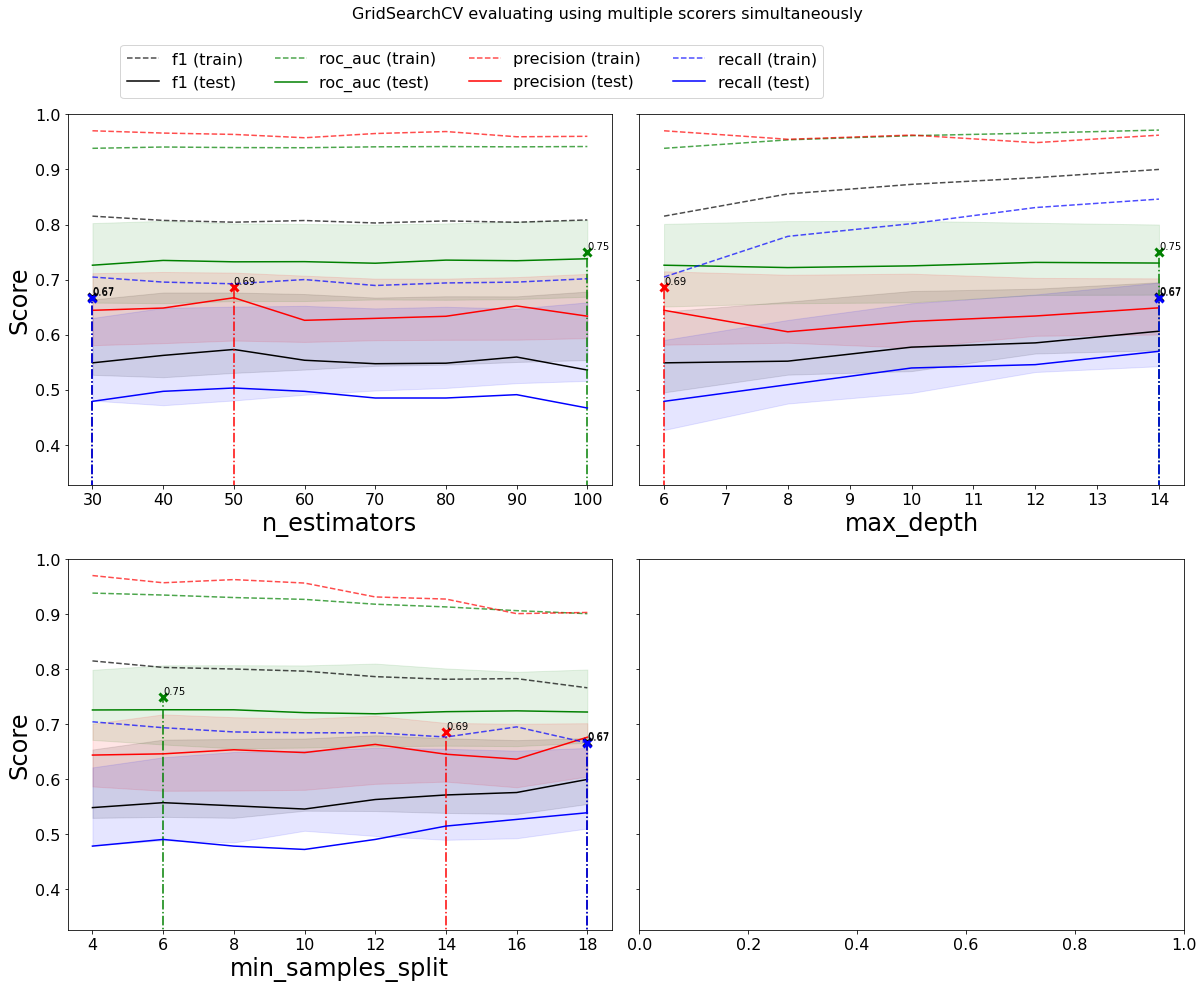

In [ ]:
# SÓ RODA SE run_hyperparameters_search = True
# CÓDIGO ADAPTADO DO EXEMPLO
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
if run_hyperparameters_search:
  check_type = np.vectorize(type)

  GridCV_best_results_df = pd.DataFrame([],columns=['parametro','best_param','best_score','metrica'])

  N = len(param_grid)
  ncols = min(2,max(2,np.floor(N/2).astype(int)))
  nrows = max(1,np.ceil(N/ncols).astype(int))

  if nrows>1:
    ax_id_list = list(product(range(nrows),range(ncols)))
  else:
    ax_id_list = list(range(ncols))

  fig, all_ax = plt.subplots(nrows, ncols, figsize=(20,15), sharey=True)
  fig.suptitle("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)
  fig.subplots_adjust(wspace=0.05)

  ymin=np.inf
  for ax_id, param_name in enumerate(param_grid.keys()):
    ax = all_ax[ax_id_list[ax_id]]
    arr = results[f'param_{param_name}'].data.copy()
    if arr.dtype==np.object:
      if np.any(check_type(arr))==str:
        # converter para categorico
        arr = pd.Series(arr).astype('category').cat.codes.values
      else: 
        # assumindo que há somente 1 único valor não-numérico
        arr = np.nan_to_num(arr.astype(float), nan=-1)

    
    _, idxs = np.unique(arr, return_index=True)
    X_axis = np.array(arr[idxs], dtype=float) # Get the regular numpy array from the MaskedArray
    for scorer, color in zip(scoring , ['k','g','r','b']): 
        
        for sample, style in (('train', '--'), ('test', '-')):
          # Gets mean and std of {score} for split {sample}
          sample_score_mean = np.zeros(X_axis.shape)
          sample_score_std  = np.zeros(X_axis.shape)
          for i, param_val in enumerate(X_axis):
              sample_score_mean[i] = results[f'mean_{sample}_{scorer}'][arr==param_val].mean() 
              sample_score_std[i]  = results[f'std_{sample}_{scorer}'][arr==param_val].mean() 
          
          # highlight 1 std of area over mean values
          ax.fill_between(X_axis, 
                          (sample_score_mean - sample_score_std),
                          (sample_score_mean + sample_score_std),
                          alpha=0.1 if sample == 'test' else 0, color=color)
          # plot curve of mean values vs. parameter values
          ax.plot(X_axis, results[f'mean_{sample}_{scorer}'][idxs], style, color=color, alpha=1 if sample == 'test' else 0.7, label=f"{scorer} ({sample})")
          # gets best score for annotation
        
        arr1 = results[f'rank_test_{scorer}']
        best_index = np.nonzero(arr1 == 1)[0][0]
        arr2 = results[f'mean_test_{scorer}']
        
        best_score = arr2[best_index]
        # best_param_val = results[f'param_{param_name}'].data[idxs[best_index]]
        best_param_val = results[f'param_{param_name}'].data[best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([arr[best_index], ] * 2, [0, best_score], linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate(f"{best_score:0.2f}", (arr[best_index], best_score + 0.005))

        curr_ymin = (sample_score_mean - sample_score_std).min()-0.1
        if curr_ymin<ymin:
          ymin = curr_ymin
          ax.set_ylim(ymin, 1)

        ax.set_xlabel(param_name)
        if nrows==1:
          ax.set_ylabel("Score")
        elif ax_id_list[ax_id][1]==0:
          ax.set_ylabel("Score")
        
        # save results
        results_to_append = pd.DataFrame([[param_name,  best_param_val, best_score, scorer]],columns=GridCV_best_results_df.columns.to_list())
        GridCV_best_results_df = GridCV_best_results_df.append(results_to_append)
    
    if ax_id_list[ax_id]==ax_id_list[0]:
      fig.legend(ncol=len(scoring),loc=(0.1,.9))
    ax.grid(False)
  plt.show()

#### **ANÁLISE NUMÉRICA DOS RESULTADOS DO ``GridSearchCV`` (opcional)** 

Após os resultados, podemos analisar todas as métricas coletadas e ver quais os valores são os mais adequados para cada métrica.  
Porém, note que o melhor modelo no _ranking_ interno da função será o que obtiver a melhor métrica do parâmetro ``refit``. Nesse caso, optamos pelo ``"f1"``.

In [ ]:
# SÓ RODA SE run_hyperparameters_search = True
if run_hyperparameters_search:
  display(pd.DataFrame(GridCV_best_results_df.reset_index(drop=True).groupby(['metrica','parametro','best_param'])['best_score'].max()))

best_score
metrica   parametro         best_param            
f1        max_depth         14            0.668403
          min_samples_split 18            0.668403
          n_estimators      30            0.668403
precision max_depth         6             0.685797
          min_samples_split 14            0.685797
          n_estimators      50            0.685797
recall    max_depth         14            0.666667
          min_samples_split 18            0.666667
          n_estimators      30            0.666667
roc_auc   max_depth         14            0.749442
          min_samples_split 6             0.749442
          n_estimators      100           0.749442

### FIT DO MELHOR MODELO

Finalmente, agora que conhecemos os melhores parâmetros do melhor modelo, vamos fazer o ajuste final do modelo de previsão de internação.  

Antes de prosseguir, se estiver executando o caderno de maneira exploratória, desmarque a opção ``ignore_GridSearchCV``. Assim, os parâmetros do modelo final vão ser os resultantes da busca do ``GridSearchCV`` (se tiver sido executado). Caso contrário, vai usar valores pré-definidos ao fim dos estudos deste projeto.

In [ ]:
#@title IGNORAR RESULTADOS DA BUSCA DE HIPERPARÂMETROS?

#@markdown Marque a opção abaixo se quiser ignorar os resultados do ``GridSearchCV`` para busca de hiperparâmetros (irrelevante se ``run_hyperparameters_search=False``.  

#@markdown > **``if False``**: Caso não marque E rode a busca de hiperparâmetros, vai usar o resultado encontrado nesta execução do caderno.
#@markdown > 
#@markdown >  **``if True``**: **Caso selecionado, vai usar parâmetros encontrados durante os estudos para o ajuste final do modelo.**

ignore_GridSearchCV = True #@param {type:"boolean"}

In [ ]:
if run_hyperparameters_search and not ignore_GridSearchCV:
  best_params = gs.best_params_
  print(gs.best_estimator_)

**AJUSTE DO MODELO COM OS MELHORES PARÂMETROS**

> <font color=##7733BB> **NOTA**: o modelo será treinado usando **todos os dados** (da janela ``0-2``, apenas _features_ selecionadas) de **todos os pacientes**. A ideia aqui é que este é **O MODELO que vai ser usado na prática.**. Logo, não há mais necessidade de separar um pedaço dos dados para testes. </font>

In [ ]:
modelo_escolhido = modelo_para_otimizar(**best_params, **params_fixed)
modelo_treinado  = modelo_escolhido.fit(X_final.values, y_final.values)
modelo_treinado

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=45678,
                       verbose=0, warm_start=False)

#### IMPORTÂNCIA DAS FEATURES DO MODELO TREINADO

Existe um atributo ``feature_importances_``, correspondente à importância das _features_, salvo no objeto do modelo ``RandomForestClassifier`` após o seu ajuste.  

De acordo com [documentação do ``scikit-learn`` sobre esse atributo](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_):
> _The impurity-based feature importances._
>
> _The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance._

Ou seja, é uma métrica de importância das _features_ para as decisões do modelo, baseada em um critério de "impureza". Quanto maior o valor da métrica, maior a importância da _feature_.  

Abaixo, é mostrado um gráfico de barras com essas importâncias ordenadas e normalizadas pelo valor máximo da distribuição.

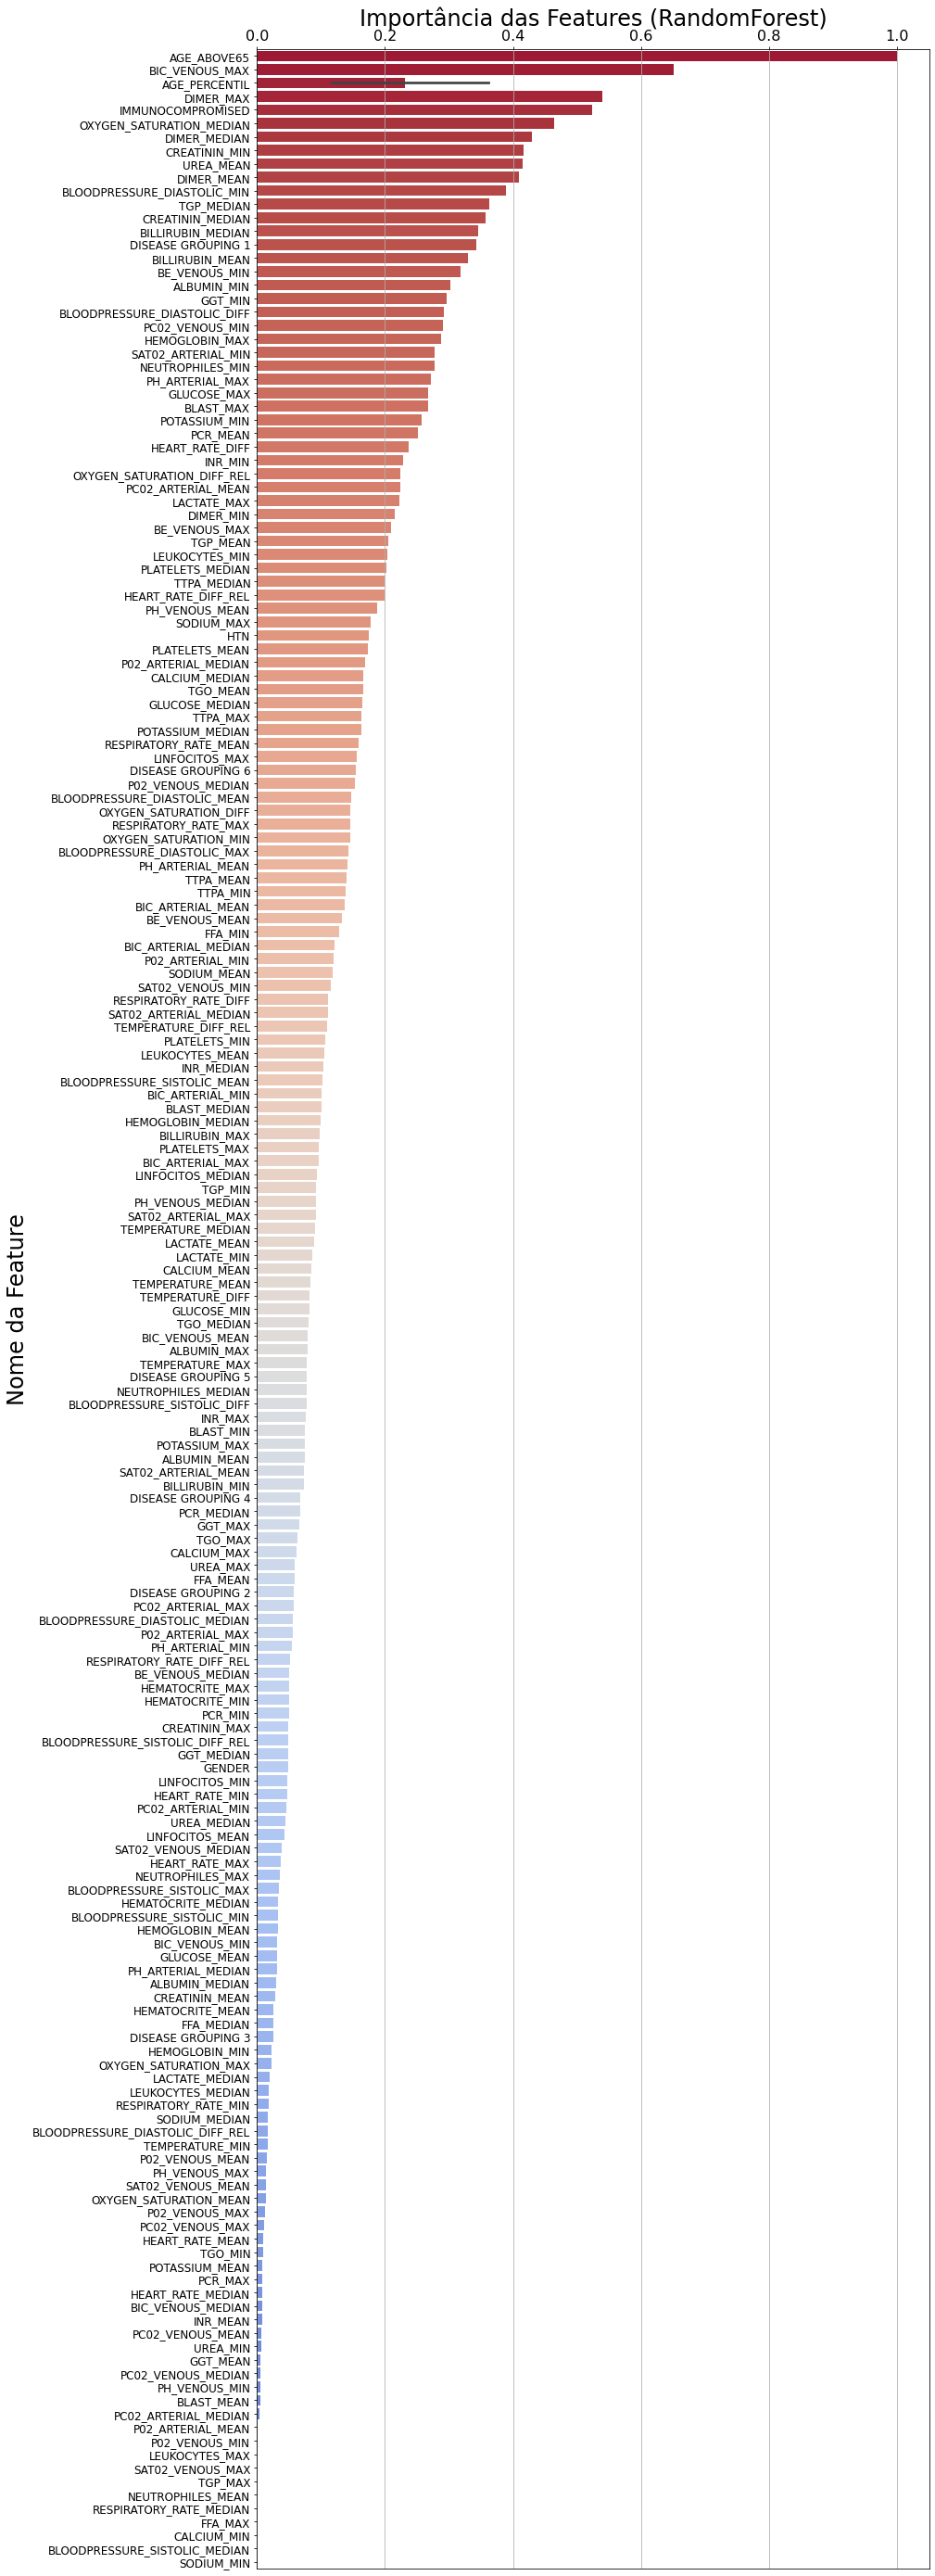

In [ ]:
feature_importance_RandomForestClassifier_df = pd.DataFrame(np.hstack([modelo_treinado.feature_importances_.reshape(-1,1),
                                                                       X.droplevel(1,axis=1).columns.values.reshape(-1,1)]),
                                                            columns=['Feature_Importance','Feature_Name'])

feature_importance_RandomForestClassifier_df['Feature_Importance'] /= feature_importance_RandomForestClassifier_df['Feature_Importance'].max()

fig, ax = plt.subplots(1,1, figsize=(13,50))
cm_obj = sns.color_palette('coolwarm', n_colors=X.shape[1], as_cmap=True)
customPalette = sns.set_palette(sns.color_palette(cm.get_cmap(cm_obj)(np.linspace(0,1,X.shape[1]))[::-1]))

sns.barplot(data=feature_importance_RandomForestClassifier_df.sort_values(by='Feature_Importance',ascending=False),
            x='Feature_Importance',
            y='Feature_Name',
            palette=customPalette,
            ax=ax)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Importância das Features (RandomForest)')
ax.set_ylabel('Nome da Feature')
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(12) 
ax.xaxis.grid(which='major')

# plt.savefig('./feature_importance.png', dpi=300, transparent=True, bbox_inches='tight')


Aqui é muito importante ressaltar alguns pontos:
- confirma-se a importância da idade na determinação da previsão
- muitos exames de sangue que não foram destacados na análise exploratória dos dados mostram-se bastante relevantes na ordem de importância (``SAT_02``, ``LINFOCITOS``, ``INR``, etc.)
- as variáveis ``LACTATE_`` que pareciam determinantes de acordo com as conclusões preliminares da análise exploratória não parecem tão relevantes assim no modelo final (veja os detalhes na tabela abaixo).


In [ ]:
feature_importance_RandomForestClassifier_df[feature_importance_RandomForestClassifier_df['Feature_Name'].str.startswith('LACTATE')]

,Feature_Importance,Feature_Name
98,0.222815,LACTATE_MAX
99,0.0893218,LACTATE_MEAN
100,0.0199522,LACTATE_MEDIAN
101,0.0861228,LACTATE_MIN


<a name="ML_val"></a>
### Validação: acompanhando a evolução dos pacientes e as previsões do modelo
[(voltar para o sumário)](#toc2)

A fim de simular o desempenho desse modelo, e também para aproveitar os dados das janelas que não foram usadas no treino, elaborei **uma metodologia para fazer uma validação dos resultados do modelo "acompanhando" a evolução dos pacientes**.  

Funciona da seguinte maneira: 

> Considere que estamos na janela $n$ de observação ($n=1,\ldots, N$). Nesse instante, temos disponíveis os dados dos pacientes coletados durante essa mesma janela. Nenhum paciente foi internado ainda.  
>
> Então passamos esses dados como entrada no modelo treinado, e o modelo devolve as previsões de internação de cada paciente.
> 
> Aqui, usamos nosso poder de onisciência, _GenieAided_, para dividir os pacientes em dois grupos:  
>> **Grupo 1.** os pacientes que realmente vão ser internados na janela $n+1$ (note que nenhum tem rótulo ``ICU_timeless=0``).  
>> **Grupo 2**. os pacientes que não vão ser internados na janela $n+1$ (mas podem ser internados ou não em janelas futuras $n+2$, $n+3$, etc).  
>
> Com essa informação privilegiada do futuro, podemos calcular uma matriz de confusão pra cada grupo.
>> - Os erros na matriz de confusão do Grupo 1 são denominados "**erros definitivos**", ou seja, não teremos outra oportunidade de acertar com esses pacientes, eles serão internados na próxima janela ($n+1$). Como esse grupo só contém pacientes que vão ser internados, a única métrica que existe para ser calculada é o ``recall``.  
>> - Os erros na matriz de confusão do Grupo 2 chamamos de "erros parciais", porque esses pacientes ainda poderão ser observados na próxima janela ($n+1$), e o modelo terá uma nova chance de fazer previsões com novos dados de cada paciente. Nesse caso, até a penúltima janela, pode acontecer todo tipo de erro, então podemos avaliar ``recall``, ``precision`` e ``f1``. Na penúltima janela ($N-1$), todos os pacientes que restavam para serem internados estarão no grupo 1, e portanto, a única métrica importante serão os **falsos positivos** (que influenciam diretamente na métrica ``precision`` da classe 1).
> 
> Agora, seguimos para a janela $n+1$. Os pacientes internados nesta janela não entram mais nas análises. Para o restante dos pacientes, coletamos os novos dados de entrada e atualizamos a entrada do modelo com os dados do instante $n+1$, gerando novas previsões para os pacientes que ainda não foram internados.
>
> Repete-se todo procedimento de análise de erros, até a última janela. 

A Figura abaixo tenta ilustrar o cenário.

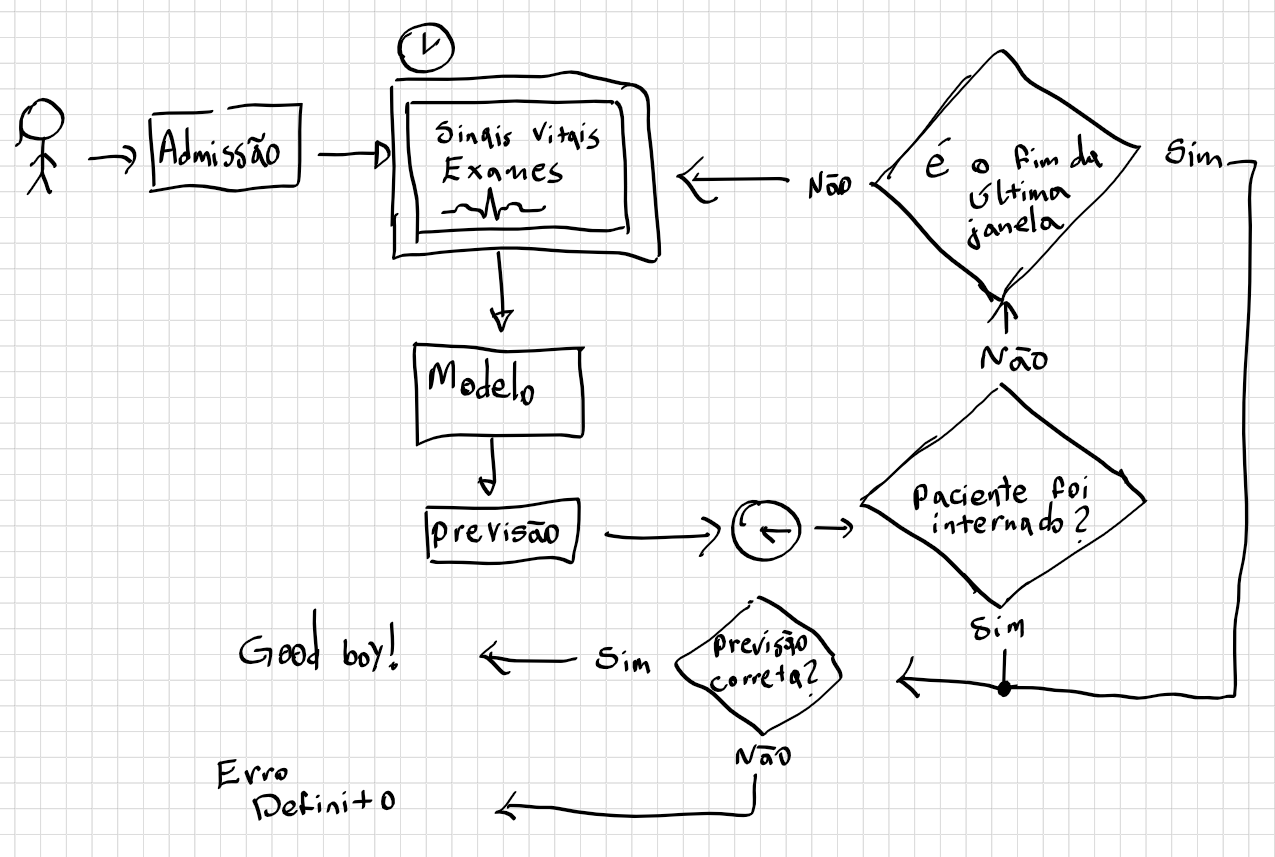

O código abaixo executa a simulação descrita anteriormente.  

Ao fim do código, são geradas as duas matrizes de confusão de cada janela (erros parciais e erros definitivos).

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



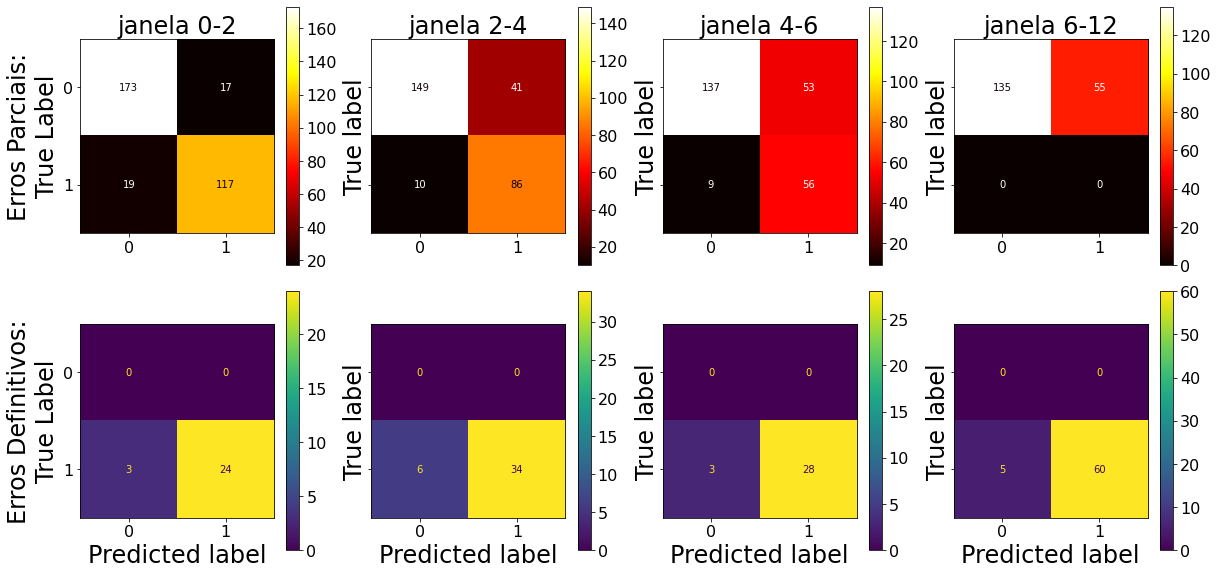

In [ ]:
todos_os_pacientes  = set(df_ML_pivot.index.to_list())
todos_os_subindices = df_ML_pivot.columns.get_level_values(1).unique().to_list()

pacientes_atuais     = todos_os_pacientes
pacientes_internados = set()

score_parcial_janelas    = []
score_definitivo_janelas = []

fig, ax = plt.subplots(2,4,figsize=(20,10),sharex=False,sharey=True)
fig.subplots_adjust(hspace=.1)

for i in range(0,4):
  sub_indices_validos   = [idx for idx in todos_os_subindices if idx not in lista_de_janelas[:i] + lista_de_janelas[i+1:]]
  
  df_pacientes_janela_i = df_ML_pivot.loc[:, (slice(None),sub_indices_validos)][features_selecionadas_copia].droplevel(1,axis=1)
  df_pacientes_janela_i = df_pacientes_janela_i.loc[pacientes_atuais]

  X_janela_i = df_pacientes_janela_i[X_cols]
  Y_janela_i = df_pacientes_janela_i[Y_col]

  previsoes_do_modelo = modelo_treinado.predict(X_janela_i.values)

  pacientes_internados_proxima_janela = df_pacientes_janela_i['WINDOW'].where(lambda x : x==i+1).dropna().index
  pacientes_internados = pacientes_internados.union(pacientes_internados_proxima_janela)
  filtro_erros_definitivos = Y_janela_i.index.to_series().apply(lambda x: True if x in pacientes_internados_proxima_janela else False)

  pacientes_atuais = pacientes_atuais.difference(pacientes_internados_proxima_janela) # pacientes_seguem_sem_internacao
  filtro_erros_parciais = Y_janela_i.index.to_series().apply(lambda x: True if x not in pacientes_internados_proxima_janela else False)

  # Erros Parciais
  y_pred = previsoes_do_modelo[filtro_erros_parciais]
  y_true = Y_janela_i.loc[pacientes_atuais].values # 
  cm = confusion_matrix(y_true, y_pred, normalize=None) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  f1 = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot(cmap='hot',values_format="d", ax=ax[0,i])
  if i==0:
    ax[0,i].set_ylabel(f'Erros Parciais:\nTrue Label')
  ax[0,i].set_title(f'janela {lista_de_janelas[i]}')
  ax[0,i].set_xlabel('')
  score_parcial_janelas.append([func(y_true, y_pred) for func in [f1_score, recall_score, precision_score]])

  # Erros definitivos
  y_pred = previsoes_do_modelo[filtro_erros_definitivos]
  y_true = Y_janela_i.loc[pacientes_internados_proxima_janela].values # 
  cm = confusion_matrix(y_true, y_pred, normalize=None)
  f2 = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot(cmap='viridis',values_format="d", ax=ax[1,i])

  if i==0:
    ax[1,i].set_ylabel(f'Erros Definitivos:\nTrue Label')
  # ax[1,i].set_title(f'janela {lista_de_janelas[i]}')
  score_definitivo_janelas.append([func(y_true, y_pred) for func in [f1_score, recall_score, precision_score]])


Combinando os resultados das matrizes de confusão na Figura anterior com as Tabelas resumidas das métricas, mostrada logo a seguir, podemos fazer a seguinte análise:


- **Erros Definitivos:**
 - só considera o ``recall``, pois todos os pacientes tem rótulo $1$ (todos são pacientes que vão ser internados na próxima janela)
 - o ``recall`` é uma métrica influenciada pelos falsos negativos
 - no total, o modelo errou $21$ casos de internação, de um total de $163$ (ignorando erros paciais, ou seja, só consideramos o erro $1\to0$ se o modelo não foi capaz de prever na janela anterior à de internação do paciente)
 - o recall total ($87\%$) é muito próximo do ``recall`` "instantâneo" dos erros definitivos em cada janela.

In [ ]:
print("Scores Definitivos:")
display(pd.DataFrame(np.around(np.array(score_definitivo_janelas)[:,1],2),columns=['recall']).rename_axis(index='janela').T.rename(columns={i:lista_de_janelas[i] for i in range(5)}))

Scores Definitivos:


janela,0-2,2-4,4-6,6-12
recall,0.89,0.85,0.9,0.92


- **Erros Parciais**:
 - considera todas as métricas até a penúltima janela
 - o ``recall`` dos erros paciais é semelhante ao dos erros definitivos, em todas as janelas
 - o ``precision`` da classe 1 é o responsável pelo decaimento da métrica ``f1`` com o passar do tempo
 - na penúltima janela, todos os pacientes da matriz de confusão de erros parciais tem rótulo ``ICU=0``, por isso as métricas da classe 1 não são calculadas; nesse caso, o número de ``falsos positivos`` é $48$, gerando um ``precision`` da classe 0 de $74{,}73\%$ (dos $190$ pacientes não internados)
 - na primeira janela, temos um overfit das métricas da classe 0 (precisão da classe 0 de $92{,}1\%$; curiosamente, esse overfit não aparece na classe 1.



In [ ]:
print("Scores Paciais:")
display(pd.DataFrame(np.around(np.array(score_parcial_janelas)[:-1,:],2),columns=['f1','recall','precision']).rename_axis(index='janela').T.rename(columns={i:lista_de_janelas[i] for i in range(5)}))

Scores Paciais:


janela,0-2,2-4,4-6
f1,0.87,0.77,0.64
recall,0.86,0.90,0.86
precision,0.87,0.68,0.51


# Anexos: alguns resultados de desempenho usados para analisar diferentes estratégias

In [ ]:
# Testar automatico novamente, mas agora:
# - eliminar vars. de baixa dispersão
# - manter altamente correlacionadas

## A. Análise dos Resultados de Validação Cruzada
<a name="anexo_A"></a>


Aqui estão algumas anotações onde analisei os resultados obtidos considerando vários cenários, tentando comparar os diferentes modelos em relação a todas as métricas. Os critérios utilizados são explicados na seção ["Analisando os resultados obtidos"](#cv_results_analysis).

In [ ]:
# resultados sem otimização de hiperparâmetros, exceto onde for indicado que houve
# SPLIT: 
'''test'''
# ------------------------------------------------------------------------------
# Método para as Features:  1. Automatic {low_std_th: 0.15, high_corr_th: 0.75}
# ------------------------------------------------------------------------------
    # Opção de Class-Weight: none 
''' MEDIA
    LogisticRegression	    0.612	0.699	0.581	0.654
    RandomForestClassifier	0.626	0.733	0.598	0.665   f1, auc, rec, prec
    LinearSVC	              0.620	0.702	0.591	0.661
    '''

''' STD
    LogisticRegression	    0.061	0.055	0.084	0.067
    RandomForestClassifier	0.063	0.052	0.086	0.068   auc, 
    LinearSVC	              0.058	0.052	0.081	0.061   f1, auc, rec, prec
'''

''' INTERVALO
    LogisticRegression	    (0.43, 0.8)	  (0.53, 0.86)	(0.33, 0.83)	(0.45, 0.86)
    RandomForestClassifier	(0.44, 0.82)	(0.58, 0.89)	(0.34, 0.85)	(0.46, 0.87)
    LinearSVC	              (0.45, 0.8)	  (0.55, 0.86)	(0.35, 0.83)	(0.48, 0.84)
    
    MELHOR MIN              LinearSVC     RandForest    LinearSVC     LinearSVC  
    MELHOR MAX              RandForest    RandForest    RandForest    RandForest
'''

    # VENCEDOR DO BLOCO: no detalhe, LinearSVC, mas todos tiveram desempenhos semelhantes

    # Opção de Class-Weight: balanced 
''' MEDIA
    LogisticRegression	    0.630	0.698	0.630	0.636   
    RandomForestClassifier	0.641	0.731	0.631	0.658   f1, auc, prec
    SVC	                    0.624	0.719	0.633	0.622   rec, 
    LinearSVC	              0.634	0.701	0.628	0.647   
    '''

''' STD
    LogisticRegression	    0.060	0.055	0.084	0.061   f1   
    RandomForestClassifier	0.060	0.053	0.081	0.064   f1
    SVC	                    0.060	0.054	0.085	0.061   f1
    LinearSVC	              0.055	0.052	0.080	0.058   auc, rec, prec
'''

''' INTERVALO
    LogisticRegression	    (0.45, 0.81)	(0.53, 0.86)	(0.38, 0.88)	(0.45, 0.82)
    RandomForestClassifier	(0.46, 0.82)	(0.57, 0.89)	(0.39, 0.87)	(0.47, 0.85)
    SVC	                    (0.45, 0.8)	  (0.56, 0.88)	(0.38, 0.89)	(0.44, 0.81)
    LinearSVC	              (0.47, 0.8)	  (0.55, 0.86)	(0.39, 0.87)	(0.47, 0.82)

    MELHOR MIN              LinearSVC     RandForest    LinSVC/RndFor LinSVC/RndFor  
    MELHOR MAX              RandForest    RandForest    SVC           RandForest
'''

    # VENCEDOR DO BLOCO: RandomForestClassifier, embora SVC e LinearSVC tenahm chegado perto, e novamente, todos os resultados muito parecidos

# ------------------------------------------------------------------------------
# Método para as Features: 2. TODAS AS FEATURES
# ------------------------------------------------------------------------------
    
    # ----------------------------------------------------------------- WINNING
    # Opção de Class-Weight: none 
''' MEDIA :
    LogisticRegression    	0.624	0.776	0.702	0.562
    RandomForestClassifier	0.725	0.871	0.803	0.662   f1, auc, rec, prec
    '''

''' STD:
    LogisticRegression    	0.016	0.011	0.034	0.021   f1, auc, rec, prec
    RandomForestClassifier	0.018	0.011	0.036	0.027   auc
    '''

''' INTERVALO
    LogisticRegression	    (0.57, 0.67)	(0.74, 0.81)	(0.6, 0.8)	(0.5,  0.62)
    RandomForestClassifier	(0.67, 0.78)	(0.84, 0.9)	  (0.7, 0.91)	(0.58, 0.74)

    MELHOR MIN              RandForest    RandForest    RandForest    RandForest  
    MELHOR MAX              RandForest    RandForest    RandForest    RandForest
    '''

    # VENCEDOR DO BLOCO: RandomForestClassifier


    #Opção de Class-Weight: balanced 
''' MEDIA :
    LogisticRegression	    0.639	0.707	0.627	0.658   f1,  rec
    RandomForestClassifier	0.631	0.735	0.612	0.661   auc, prec
    LinearSVC	              0.626	0.694	0.609	0.651
    '''

'''STD
    LogisticRegression	    0.058	0.053	0.077	0.066   f1,  rec
    RandomForestClassifier	0.067	0.049	0.095	0.061   auc, prec
    LinearSVC	              0.058	0.050	0.079	0.063   f1
    '''

''' INTERVALO
    LogisticRegression	    (0.47, 0.81)	(0.55, 0.86)	(0.39, 0.86)	(0.46, 0.86)
    RandomForestClassifier	(0.43, 0.83)	(0.59, 0.88)	(0.33, 0.9)	  (0.48, 0.84)
    LinearSVC	              (0.45, 0.8)	  (0.54, 0.84)	(0.37, 0.85)	(0.46, 0.84)

    MELHOR MIN              LogisticReg   RandForest    LogisticReg   RandForest  
    MELHOR MAX              RandForest    RandForest    RandForest    LogisticReg
    '''

    # VENCEDOR DO BLOCO: aqui é um empate técnico: 
    #       LogisticRegression     com melhores f1  / recall 
    #       RandomForestClassifier com melhores auc / precision

# ------------------------------------------------------------------------------
# Método para as Features: 3. MANUAL
# ------------------------------------------------------------------------------    

# FEATURES USADAS:
"""continuous
'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
'BLOODPRESSURE_SISTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MEAN',
'HEART_RATE_MAX','HEART_RATE_MEAN', 'HEART_RATE_MIN',
'OXYGEN_SATURATION_MAX', 'OXYGEN_SATURATION_MEAN', 
'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MIN',
'TEMPERATURE_MAX', 'TEMPERATURE_MEAN', 'TEMPERATURE_MIN',
'LACTATE_MEAN', 'LACTATE_MAX', 'LACTATE_MIN', 'LACTATE_MEDIAN', 'LACTATE_DIFF'
"""

"""categorical
'AGE_ABOVE65', 'GENDER', 'HTN', 'DISEASE GROUPING 4'
"""

    # Opção de Class-Weight: none 
''' MEDIA
    LogisticRegression	    0.608	0.687	0.575	0.652   
    RandomForestClassifier	0.570	0.698	0.515	0.654   auc, prec
    SVC	                    0.641	0.698	0.658	0.631   f1, auc, rec
'''

''' STD
    LogisticRegression	    0.071	0.061	0.089	0.075   
    RandomForestClassifier	0.068	0.060	0.093	0.082
    SVC	                    0.055	0.059	0.078	0.064   f1, auc, rec, prec
'''

''' INTERVALO
    LogisticRegression	    (0.39, 0.82)	(0.51, 0.87)	(0.31, 0.84)	(0.43, 0.88)
    RandomForestClassifier	(0.37, 0.78)	(0.52, 0.88)	(0.24, 0.79)	(0.41, 0.9)
    SVC	                    (0.48, 0.81)	(0.52, 0.87)	(0.42, 0.89)	(0.44, 0.82)

    MELHOR MIN              SVC           ----------    SVC           SVC  
    MELHOR MAX              LogisticReg   ----------    SVC           RandForest
'''

    # VENCEDOR DO BLOCO: SVC tem a maioria das maiores médias e melhores MIN/MAX do intervalo


    # Opção de Class-Weight: balanced 
''' MEDIA
    LogisticRegression	    0.628	0.687	0.632	0.631   prec
    RandomForestClassifier	0.601	0.696	0.586	0.628   
    SVC	                    0.652	0.699	0.684	0.626   f1, auc, rec, 
'''

''' STD
    LogisticRegression	    0.067	0.060	0.093	0.069   
    RandomForestClassifier	0.073	0.059	0.105	0.067   auc, 
    SVC	                    0.054	0.059	0.075	0.057   f1, auc, rec, prec
'''

''' INTERVALO
    LogisticRegression	    (0.43, 0.83)	(0.51, 0.87)	(0.35, 0.91)	(0.42, 0.84)
    RandomForestClassifier	(0.38, 0.82)	(0.52, 0.87)	(0.27, 0.9)	  (0.43, 0.83)
    SVC	                    (0.49, 0.81)	(0.52, 0.88)	(0.46, 0.91)	(0.46, 0.8)

    MELHOR MIN              SVC           ----------    SVC           SVC  
    MELHOR MAX              LogisticReg   ----------    ------------  LogisticReg
'''

    # VENCEDOR DO BLOCO: SVC tem a maioria das maiores médias e melhores MIN/MAX do intervalo



' INTERVALO\n    LogisticRegression\t    (0.43, 0.83)\t(0.51, 0.87)\t(0.35, 0.91)\t(0.42, 0.84)\n    RandomForestClassifier\t(0.38, 0.82)\t(0.52, 0.87)\t(0.27, 0.9)\t  (0.43, 0.83)\n    SVC\t                    (0.49, 0.81)\t(0.52, 0.88)\t(0.46, 0.91)\t(0.46, 0.8)\n\n    MELHOR MIN              SVC           ----------    SVC           SVC  \n    MELHOR MAX              LogisticReg   ----------    ------------  LogisticReg\n'

## B. Análise do Modelo Treinado com os Dados de Validação

Mesmo após decidir o melhor modelo, rodei o caderno algumas vezes com outros modelos e em outros cenários, para comparar o desempenho deles com os dados de Validação, simulando a aplicação prática dos mesmos.

Os resultados anotados abaixo correspondem aos testes que são realizados na seção "[Validação: acompanhando a evolução dos pacientes e as previsões do modelo](#ML_val)".

In [ ]:
# resultados sem otimização de hiperparâmetros, exceto onde for indicado que houve
'''feature_selection_method 2. TODAS AS FEATURES
-----------------------------------
RandomForestClassifier
-----------------------------------
Scores Paciais:
janela	  0	    1	    2
f1	      0.87	0.79	0.72
recall	  0.81	0.88	0.89
precision	0.94	0.72	0.60

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.85	0.85	0.81	0.85

-----------------------------------
LogisticRegression
-----------------------------------
Scores Paciais:
janela	  0	    1	    2
f1	      0.70	0.62	0.58
recall	  0.68	0.68	0.72
precision	0.72	0.57	0.48

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.85	0.78	0.81	0.72

-----------------------------------
SVC
-----------------------------------
Scores Paciais:
janela	  0	    1	    2
f1	      0.61	0.58	0.50
recall	  0.55	0.62	0.62
precision	0.68	0.55	0.43

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.78	0.72	0.74	0.63
'''

'''feature_selection_method 1. Automatic {low_std_th: 0.15, high_corr_th: 0.75}
-----------------------------------
RandomForestClassifier
-----------------------------------
Scores Paciais:
janela	  0	    1	    2
f1	      0.87	0.74	0.61
recall	  0.82	0.81	0.77
precision	0.92	0.68	0.51

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.85	0.88	0.94	0.71

-----------------------------------
LogisticRegression
-----------------------------------
Scores Paciais:
janela	  0	    1	    2
f1	      0.66	0.57	0.56
recall	  0.63	0.59	0.69
precision	0.68	0.54	0.47

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.81	0.72	0.58	0.69

-----------------------------------
SVC
-----------------------------------
Scores Paciais:
janela  	0	    1	    2
f1	      0.67	0.65	0.57
recall	  0.62	0.68	0.65
precision	0.71	0.63	0.51

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.81	0.72	0.71	0.6

'''

'''feature_selection_method 1. Automatic {low_std_th: 0.05, high_corr_th: .95}
-----------------------------------
RandomForestClassifier
-----------------------------------
### GridSearchCV: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40}

Scores Paciais:
janela	  0	    1	    2
f1	      0.88	0.76	0.65
recall	  0.85	0.90	0.88
precision	0.91	0.66	0.52

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.89	0.88	0.84	0.89
'''

'''feature_selection_method 1. Automatic {low_std_th: 0.0, high_corr_th: 1.0}
-----------------------------------
RandomForestClassifier
-----------------------------------
### GridSearchCV: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 90}
Scores Paciais:
janela	  0	    1	    2
f1	      0.86	0.77	0.66
recall  	0.85	0.90	0.89
precision	0.87	0.67	0.53

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.93	0.85	0.84	0.95
'''



'''feature_selection_method 3. Manual
-----------------------------------
RandomForestClassifier
-----------------------------------
### GridSearchCV: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
:: continuous
'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
'BLOODPRESSURE_SISTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MEAN',
'HEART_RATE_MAX','HEART_RATE_MEAN', 'HEART_RATE_MIN',
'OXYGEN_SATURATION_MAX', 'OXYGEN_SATURATION_MEAN', 
'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MIN',
'TEMPERATURE_MAX', 'TEMPERATURE_MEAN', 'TEMPERATURE_MIN',
'LACTATE_MEAN', 'LACTATE_MAX', 'LACTATE_MIN', 'LACTATE_MEDIAN', 'LACTATE_DIFF'

:: categorical
'AGE_ABOVE65', 'GENDER', 'HTN', 'DISEASE GROUPING 4'


Scores Paciais:
janela	  0	    1	    2
f1	      0.74	0.63	0.52
recall	  0.71	0.71	0.72
precision	0.78	0.56	0.41

Scores Definitivos:
janela	0	    1	    2	    3
recall	0.85	0.8	  0.84	0.68
'''

"feature_selection_method 3. Manual\n-----------------------------------\nRandomForestClassifier\n-----------------------------------\n### GridSearchCV: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}\n:: continuous\n'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MIN',\n'BLOODPRESSURE_SISTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MEAN',\n'HEART_RATE_MAX','HEART_RATE_MEAN', 'HEART_RATE_MIN',\n'OXYGEN_SATURATION_MAX', 'OXYGEN_SATURATION_MEAN', \n'RESPIRATORY_RATE_MAX', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MIN',\n'TEMPERATURE_MAX', 'TEMPERATURE_MEAN', 'TEMPERATURE_MIN',\n'LACTATE_MEAN', 'LACTATE_MAX', 'LACTATE_MIN', 'LACTATE_MEDIAN', 'LACTATE_DIFF'\n\n:: categorical\n'AGE_ABOVE65', 'GENDER', 'HTN', 'DISEASE GROUPING 4'\n\n\nScores Paciais:\njanela\t  0\t    1\t    2\nf1\t      0.74\t0.63\t0.52\nrecall\t  0.71\t0.71\t0.72\nprecision\t0.78\t0.56\t0.41\n\nScores Definitivos:\njanela\t0\t    1\t    2\t    3\nrecall\t0.85\t0.8\t  0.84\t0.68\n"